In [1]:
from google.colab import drive
drive.mount('/content/drive')


import os

import torch
os.chdir('/content/drive/MyDrive/ImitationLearning/Invariant-Causal-Imitation-Learning-main/')


Mounted at /content/drive


# load

In [2]:
!pip install mpi4py 
!pip install box2d-py
!pip install box2d 
!pip3 install gym[Box_2D] 
!pip install gym==0.17.2 -qqq
!pip install numpy~=1.18.2 -qqq
!pip install pandas~=1.0.4 -qqq
!pip install PyYAML~=5.4.1 -qqq
!pip install scikit-learn~=0.22.2 -qqq
!pip install scipy~=1.1.0 -qqq
!pip install stable-baselines~=2.10.1 -qqq
!pip install tensorflow~=1.15.0 -qqq
!pip install torch>=1.6.0 -qqq
!pip install tqdm~=4.32.1 -qqq


     |████████████████████████████████| 2.5 MB 26.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185269 sha256=a47b90db9879d67bb5e8c36ad3e9d2139aad2cbb932a5a1daed1ab045b41100d
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
     |████████████████████████████████| 448 kB 30.9 MB/s 
     |████████████████████████████████| 1.3 MB 9.5 MB/s 
     |████████████████████████████████| 1.6 MB 36.8 MB/s 
     |████████████████████████████████| 20.1 MB 721 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requ

#config

In [3]:

config = {
    "ALG": "NFiVAE_IRMStudent_Apr28",
    "NUM_TRAJS_GIVEN": 20, #
    "NUM_TRAINING_ENVS": 2,
    "NOISE_DIM": 4,
    "REP_SIZE": 16,
    "TRAJ_SHIFT": 20, # 20,
    "SAMPLING_RATE": 5,
    "NUM_STEPS_TRAIN": 10000,
    "NUM_TRAJS_VALID": 100,
    "NUM_REPETITIONS": 15,
    "BATCH_SIZE": 64,
    "MLP_WIDTHS": 64,
    "ADAM_ALPHA": 1e-3,
    "SGLD_BUFFER_SIZE": 10000,
    "SGLD_LEARN_RATE": 0.01,
    "SGLD_NOISE_COEF": 0.01,
    "SGLD_NUM_STEPS": 100,
    "SGLD_REINIT_FREQ": 0.05,
    "NUM_STEPS_TRAIN_ENERGY_MODEL": 1000,
    'TRIAL': 0
}


#config['ENV'] = "LunarLander-v2"
config['ENV'] = "CartPole-v1"

#config['METHOD'] = "BC"
config['METHOD'] = "iVAE_IRM"



if config['METHOD'] == 'BCIRM':
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10000
    config['penalty_anneal_iters'] = 2500
elif config['METHOD'] == "iVAE_IRM":
    config["NUM_STEPS_TRAIN_VAE_MODEL"] = 1500 # phase1
    config["NUM_STEPS_TRAIN"] = 10000 # phase 3
    config['PHASE2_SAMPLES'] = 25000 # phase 2
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10
    config['BATCH_SIZE'] = 50000
    config['MODEL_TYPE'] = 'NFiVAE'
    config['SELECT_PARENTS'] = True
    config['PARENT_THRESHOLD'] = -1
   



config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

config['METHOD'] = "iVAE_IRM"



#testing/il

In [4]:
import argparse
import os
import pickle

import gym
import numpy as np
import pandas as pd
import yaml
import numpy as np

from testing.paths import get_model_path, get_trajs_path  # pylint: disable=reimported

from contrib.energy_model import EnergyModel
from contrib.env_wrapper import EnvWrapper, get_test_mult_factors
from network import EnvDiscriminator
from network import FeaturesDecoder
from network import FeaturesEncoder
from network import MineNetwork 
from network import ObservationsDecoder
from network import StudentNetwork, StudentNetwork_2hidden


from student import ICILStudent, BCStudent, BCIRMStudent, iVAE_IRMStudent, NFiVAE_IRMStudent
from testing.train_utils import fill_buffer, make_agent, save_results
from vae.ivae_wrapper import VAE_wrapper
from vae.nfivae_wrapper import NFiVAE_wrapper
  
from torch import nn

/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


#NFiVAE

In [ ]:
from numbers import Number

import numpy as np
import torch
from torch import distributions as dist
from torch import nn
from torch.nn import functional as F
from torch import autograd
import copy


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, activation='none', slope=.1, device='cpu'):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.device = device
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
            else:
                #print("c", c)
                #print("self.fc", self.fc[c])
                #print("h", h)
                #print("self.act_f", self._act_f[c])
                
                h = self._act_f[c](self.fc[c](h))
        return h


class Dist:
    def __init__(self):
        pass

    def sample(self, *args):
        pass

    def log_pdf(self, *args, **kwargs):
        pass


class Normal(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.c = 2 * np.pi * torch.ones(1).to(self.device)
        self._dist = dist.normal.Normal(torch.zeros(1).to(self.device), torch.ones(1).to(self.device))
        self.name = 'gauss'

    def sample(self, mu, v):
        eps = self._dist.sample(mu.size()).squeeze()
        scaled = eps.mul(v.sqrt())
        return scaled.add(mu)

    def log_pdf(self, x, mu, v, reduce=True, param_shape=None):
        """compute the log-pdf of a normal distribution with diagonal covariance"""
        if param_shape is not None:
            mu, v = mu.view(param_shape), v.view(param_shape)
        lpdf = -0.5 * (torch.log(self.c) + v.log() + (x - mu).pow(2).div(v))
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf

    def log_pdf_full(self, x, mu, v):
        """
        compute the log-pdf of a normal distribution with full covariance
        v is a batch of "pseudo sqrt" of covariance matrices of shape (batch_size, d_latent, d_latent)
        mu is batch of means of shape (batch_size, d_latent)
        """
        batch_size, d = mu.size()
        cov = torch.einsum('bik,bjk->bij', v, v)  # compute batch cov from its "pseudo sqrt"
        assert cov.size() == (batch_size, d, d)
        inv_cov = torch.inverse(cov)  # works on batches
        c = d * torch.log(self.c)
        # matrix log det doesn't work on batches!
        _, logabsdets = self._batch_slogdet(cov)
        xmu = x - mu
        return -0.5 * (c + logabsdets + torch.einsum('bi,bij,bj->b', [xmu, inv_cov, xmu]))

    def _batch_slogdet(self, cov_batch: torch.Tensor):
        """
        compute the log of the absolute value of determinants for a batch of 2D matrices. Uses torch.slogdet
        this implementation is just a for loop, but that is what's suggested in torch forums
        gpu compatible
        """
        batch_size = cov_batch.size(0)
        signs = torch.empty(batch_size, requires_grad=False).to(self.device)
        logabsdets = torch.empty(batch_size, requires_grad=False).to(self.device)
        for i, cov in enumerate(cov_batch):
            signs[i], logabsdets[i] = torch.slogdet(cov)
        return signs, logabsdets


class Laplace(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self._dist = dist.laplace.Laplace(torch.zeros(1).to(self.device), torch.ones(1).to(self.device) / np.sqrt(2))
        self.name = 'laplace'

    def sample(self, mu, b):
        eps = self._dist.sample(mu.size())
        scaled = eps.mul(b)
        return scaled.add(mu)

    def log_pdf(self, x, mu, b, reduce=True, param_shape=None):
        """compute the log-pdf of a laplace distribution with diagonal covariance"""
        if param_shape is not None:
            mu, b = mu.view(param_shape), b.view(param_shape)
        lpdf = -torch.log(2 * b) - (x - mu).abs().div(b)
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf


class Bernoulli(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self._dist = dist.bernoulli.Bernoulli(0.5 * torch.ones(1).to(self.device))
        self.name = 'bernoulli'

    def sample(self, p):
        eps = self._dist.sample(p.size())
        return eps

    def log_pdf(self, x, f, reduce=True, param_shape=None):
        """compute the log-pdf of a laplace distribution with diagonal covariance"""
        if param_shape is not None:
            f = f.view(param_shape)
        lpdf = x * torch.log(f) + (1 - x) * torch.log(1 - f)
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf






class NFiVAE(nn.Module):
    def __init__(self, latent_dim, data_dim, aux_dim, prior=None, decoder=None, encoder=None,
                 n_layers=3, hidden_dim=50, activation='lrelu', slope=.1, device='cpu', anneal=False, 
                 NF_priors_output_dim=20, NF_priors_n_layers=3, NF_priors_hidden_dim=50, ):
        super().__init__()

        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.aux_dim = aux_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.activation = activation
        self.slope = slope
        self.anneal_params = anneal

        if prior is None:
            self.prior_dist = Normal(device=device)
        else:
            self.prior_dist = prior

        if decoder is None:
            self.decoder_dist = Normal(device=device)
        else:
            self.decoder_dist = decoder

        if encoder is None:
            self.encoder_dist = Normal(device=device)
        else:
            self.encoder_dist = encoder

        
        self.logl = MLP(aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope, device=device)
        # decoder params
        self.f = MLP(latent_dim, data_dim, hidden_dim, n_layers, activation=activation, slope=slope, device=device)
        self.decoder_var = .01 * torch.ones(1).to(device)
        # encoder params
        self.g = MLP(data_dim + aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope,
                     device=device)
        self.logv = MLP(data_dim + aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope,
                        device=device)

        self.device = device

        # prior_params
        self.prior_mean = torch.zeros(1).to(device)
        
        # 1.1 T_NN(x)
        self.T_NN_x = MLP(latent_dim, NF_priors_output_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        # 1.2 lambda_NN(Y,E)
        self.lambda_NN_YE = MLP(aux_dim, NF_priors_output_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        
        # 2. T_f(x) and lambda_f(Y,E) are in the second dot product term
          # 2.1 T_f(x) = concat([X, X^2]). This is data dependent, we will define it later during training/evaluation process
          # 2.2 lambda_f(Y,E)
        self.lambda_f_YE = MLP(aux_dim, 2*latent_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        #self.T_f_x = torch.hstack([z, z**2])



        self.apply(weights_init)

        self._training_hyperparams = [1., 1., 1., 1., 1]
        
        print("\n***** VAE wrapper created with NFiVAE *****\n")

    def encoder_params(self, x, u):
        xu = torch.cat((x, u), 1)
        g = self.g(xu)
        logv = self.logv(xu)
        return g, logv.exp()

    def decoder_params(self, s):
        f = self.f(s)
        return f, self.decoder_var

    def prior_params(self, z, u):
        T_NN_x = self.T_NN_x(z)
        lambda_NN_YE = self.lambda_NN_YE(u)
        T_f_x = torch.hstack([z, z**2])
        lambda_f_YE = self.lambda_f_YE(u)

        log_x_ye = torch.sum(T_NN_x * lambda_NN_YE, axis = 1) + torch.sum(T_f_x * lambda_f_YE, axis = 1)
        #p_x_ye = log_x_ye.exp()
        #grad = autograd.grad(p_x_ye, [z], create_graph=True)[0]

        return log_x_ye.exp()

    def forward(self, x, u):
        
        encoder_params = self.encoder_params(x, u)
        z = self.encoder_dist.sample(*encoder_params)
        decoder_params = self.decoder_params(z)
        prior_params = self.prior_params(z, u)
        #return decoder_params, encoder_params, z, prior_params
        return decoder_params, encoder_params, z, prior_params

    def prior_1st_derivative_matching(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = copy.deepcopy(z.detach()) - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz

            derivative_of_log_encoder = ( self.encoder_params(z_plus_new, u) - self.encoder_params(z_minus_new, u) ) / (2*dz)
            derivative_of_log_prior = ( self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u) ) / (2*dz)
            

            
            #sum_derivative += 0.5 * ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
            sum_derivative += ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
            
        
        #print("self.prior_params(z_plus_new, u)", self.prior_params(z_plus_new, u))
        #print("self.prior_params(z_minus_new, u)", self.prior_params(z_minus_new, u))
      
        return sum_derivative
    
    def prior_2nd_derivative(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = z.detach() - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz
            
            sum_derivative += (self.prior_params(z_plus_new, u) - 2*self.prior_params(z, u) + self.prior_params(z_minus_new, u)) / dz / dz

        return sum_derivative
        

    def prior_1st_derivative(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = copy.deepcopy(z.detach()) - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz

            #print("z_plus_new", z_plus_new)
            #print("z_minus_new", z_minus_new)
            
            sum_derivative += 0.5* ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
        
        #print("self.prior_params(z_plus_new, u)", self.prior_params(z_plus_new, u))
        #print("self.prior_params(z_minus_new, u)", self.prior_params(z_minus_new, u))
      
        return sum_derivative





    def elbo(self, x, u):
        decoder_params, (g, v), z, prior_params = self.forward(x, u)
        log_px_z = self.decoder_dist.log_pdf(x, *decoder_params)
        log_qz_xu = self.encoder_dist.log_pdf(z, g, v)
        #log_pz_u = self.prior_dist.log_pdf(z, *prior_params)
        log_pz_u = torch.log(prior_params[1])
        
        #####
        #weight_norm = torch.tensor(0.).cuda()
        #for w in self.T_NN_x.parameters():
        #    weight_norm += w.norm().pow(2)    
        #for w in self.lambda_NN_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #for w in self.lambda_f_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #for w in self.lambda_f_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #####
        
        
        if self.anneal_params:
            a, b, c, d, N = self._training_hyperparams
            M = z.size(0)
            log_qz_tmp = self.encoder_dist.log_pdf(z.view(M, 1, self.latent_dim), g.view(1, M, self.latent_dim),
                                                   v.view(1, M, self.latent_dim), reduce=False)
            log_qz = torch.logsumexp(log_qz_tmp.sum(dim=-1), dim=1, keepdim=False) - np.log(M * N)
            log_qz_i = (torch.logsumexp(log_qz_tmp, dim=1, keepdim=False) - np.log(M * N)).sum(dim=-1)

            return (a * log_px_z - b * (log_qz_xu - log_qz) - c * (log_qz - log_qz_i) - d * (
                    log_qz_i - log_pz_u)).mean(), z

        else:
            print("part1 & 2 = ", (log_px_z + log_pz_u.detach() - log_qz_xu).mean().detach().cpu().numpy(), 
                                  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean().detach().cpu().numpy(),
                                  z.norm().detach().cpu().numpy() )
            #print("       part2 = ", (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean())
            #return (log_px_z + log_pz_u.detach() - log_qz_xu).mean() - self.prior_1st_derivative(z, u).mean() , z 
            #return (log_px_z + log_pz_u.detach() - log_qz_xu).mean(),  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean(), z 
            return (log_px_z + log_pz_u.detach() - log_qz_xu).mean() -  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean(), z 
            
            


    def anneal(self, N, max_iter, it):
        thr = int(max_iter / 1.6)
        a = 0.5 / self.decoder_var.item()
        self._training_hyperparams[-1] = N
        self._training_hyperparams[0] = min(2 * a, a + a * it / thr)
        self._training_hyperparams[1] = max(1, a * .3 * (1 - it / thr))
        self._training_hyperparams[2] = min(1, it / thr)
        self._training_hyperparams[3] = max(1, a * .5 * (1 - it / thr))
        if it > thr:
            self.anneal_params = False


#NFiVAE-*wrapper*

In [ ]:
import torch
import torch.optim as optim
from torch import autograd, nn
from tqdm import tqdm
from fcit import fcit
import pickle
import numpy as np
#from vae.ivae import iVAE
#from vae.nfivae import NFiVAE
from torch._C import dtype
import torch.nn.functional as F
import random 


class NFiVAE_wrapper:
    def __init__(
        self,
        buffer, 
        data_dim,
        action_dim,
        env_dim = 2,
        latent_dim = 8,
        activation = 'lrelu',
        n_layers = 3,
        hidden_dim = 32,
        lr = 1e-3,
        seed = 0,
        #max_iter = 7e4,
        use_a = True, 
        use_e = False,
        num_updates = 1000,
        ckpt_file = './vae/nfivae_ckpt.pt',
        pa_dict_file = './vae/nfivae_padict.pkl',
        model_type = 'NFiVAE',
        parents_threshold = 2,
        ):
      
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        torch.manual_seed(seed)
        np.random.seed(seed)

        self.state_dim = data_dim
        self.action_dim = action_dim 
        self.latent_dim = latent_dim

        self.buffer = buffer

        if use_a and use_e:
            aux_dim = action_dim + env_dim 
            print("use both actions and env as aux variables")
        elif use_e == False:
            aux_dim = action_dim
            print("use only actions as aux variable")
        
        if model_type == 'iVAE':
            self.model = iVAE(latent_dim, data_dim, aux_dim, activation='lrelu', device=self.device,
                     n_layers=n_layers, hidden_dim=hidden_dim)
        elif model_type == 'NFiVAE':
            self.model = NFiVAE(latent_dim, data_dim, aux_dim, activation='lrelu', device=self.device,
                     n_layers=n_layers, hidden_dim=hidden_dim)
            
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        #self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.1, patience=100, verbose=True)
        self.ckpt_file = ckpt_file
        self.pa_dict_file = pa_dict_file

        self.use_a = use_a 
        self.use_e = use_e

        self.env_dim = env_dim
        print("learning rate of NFiVAE in phase 1:", lr)
        
        self.parents_threshold = parents_threshold


    def train(self, num_updates = 10000):
        
        print("NFiVAE wrapper train buffer sample size = ", self.buffer.sample()['state'].shape)
        
        loss_list = []
        best_window_loss = np.inf
        best_window_loss_num = 0
        self.model.train()
        for update_index in (range(num_updates)):
            loss = self._update_vae_model()
            loss_list.append(loss.detach().cpu())
            
            #if np.mean(loss_list[-100:]) < best_window_loss:
            if loss < best_window_loss:
                #best_window_loss = np.mean(loss_list[-100:])
                best_window_loss = loss
                best_window_loss_num = update_index
                torch.save(self.model.state_dict(), self.ckpt_file)
            """
            if len(loss_list) > 150: # train at least 150 epochs
                if np.mean(loss_list[-100:]) > best_window_loss:
                    self.model.load_state_dict(torch.load(self.ckpt_file))
                    return loss_list
            """
        
            if update_index % 100 ==0:
                print('\repoch {}/{} \tloss: {}'.format(update_index, num_updates, loss), end="")
                #print(update_index, loss)
        #torch.save(self.model.state_dict(), self.ckpt_file)
        
        self.model.load_state_dict(torch.load(self.ckpt_file))
        
        print("best loss model loaded, stored at update #", best_window_loss_num, "with loss", best_window_loss.detach().cpu().numpy())
        
        return loss_list


    def _update_vae_model(self):
        samples = self.buffer.sample()

        x = torch.FloatTensor(samples["state"]).to(self.device)

        a = F.one_hot(torch.LongTensor(samples['action']), num_classes = self.action_dim)#.to(self.device)
        
        if self.use_a and self.use_e:
            e = F.one_hot(torch.LongTensor(samples['env']), num_classes = self.env_dim)#.to(self.device)
            ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
        elif self.use_e == False:
            ae = a.to(torch.float32).to(self.device)

        self.optimizer.zero_grad()
        #elbo_VAE, elbo_SM, z_est = self.model.elbo(x, ae)
        elbo, z_est = self.model.elbo(x, ae)
        #elbo = elbo_VAE - elbo_SM
        elbo.mul(-1).backward() #loss.backward()
        
        self.optimizer.step()

        #return elbo_VAE.mul(-1)
        return elbo.mul(-1)
        


    def predict_latent(self, samples):
        self.model.eval()
        x = torch.FloatTensor(samples["state"]).to(self.device)

        a = F.one_hot(torch.LongTensor(samples['action']), num_classes = self.action_dim)#.to(self.device)
        
        if self.use_a and self.use_e:
            e = F.one_hot(torch.LongTensor(samples['env']), num_classes = self.env_dim)#.to(self.device)
            ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
        elif self.use_e == False:
            ae = a.to(torch.float32).to(self.device)

        _, _, z, _ = self.model(x, ae)
        return z


    def _get_random_states(self, num_states):
        return torch.FloatTensor(num_states, self.in_dim).uniform_(-1, 1)








    ############################        phase 2.       #########################
    ############################        phase 2.       #########################
    ############################        phase 2.       #########################


    def phase2_sampled_data(self, n_samples = 1000):

        
        n_queries = n_samples // self.buffer.batch_size + 1
      
        actions = []
        states = []
        latents = []

        for i in range(n_queries):
            samples = self.buffer.sample()
            actions.append(samples['action'].reshape(-1,1))
            states.append(samples['state'])
            z = self.predict_latent(samples)
            latents.append(z.detach().cpu().numpy())

        actions = np.concatenate(np.vstack(actions))[:n_samples].reshape(-1,1).astype(int)
        states = np.concatenate((states), axis = 0)[:n_samples]
        latents = np.concatenate((latents), axis = 0)[:n_samples]

        actions = np.eye(actions.max()+1)[actions][:,0,:] # convert to one-hoc encoding
        
        
        """
        samples = self.buffer.sample_all()
        actions = (samples['action'].reshape(-1,1)).astype(int)
        states = (samples['state'])
        z = self.predict_latent(samples)
        latents = (z.detach().cpu().numpy())

        actions = np.eye(actions.max()+1)[actions][:,0,:] # convert to one-hoc encoding
        """

        return states, latents, actions

        
    def phase2_find_parents(self, latents, actions):

        parents = []

        num_vars = latents.shape[1]

        for i in range(num_vars-1):
            for j in range(i+1, num_vars):
                pval_d = fcit.test(latents[:,i].reshape(-1,1), latents[:,j].reshape(-1,1))
                pval_i = fcit.test(latents[:,i].reshape(-1,1), latents[:,j].reshape(-1,1), actions)
                if pval_d < pval_i:
                    print('{} and {} are independent with pval_d={} and pval_i={}'.format(i, j, pval_d, pval_i))
                else:
                    print('{} and {} are DEPENDENT with pval_d={} and pval_i={}'.format(i, j, pval_d, pval_i))
                    parents.append(i)
                    parents.append(j)

        parents_set = set(parents)

        parents_dict = {}
        for p in parents_set:
            parents_dict[p] = parents.count(p)
            
        for i in range(num_vars):
            if i not in parents_set:
                parents_dict[i] = 0

        parents_dict_sorted = {}
        for w in sorted(parents_dict, key=parents_dict.get, reverse=True):
            print(w, parents_dict[w])
            if parents_dict[w]>self.parents_threshold:
                parents_dict_sorted[w] = parents_dict[w]

        return list(parents_dict_sorted.keys()), parents_dict_sorted


    def start_phase2(self, n_samples = 50000, save = True):

        print("\n***** Starts Phase 2 *****")
        
        #n_samples = self.buffer.sample_all()['state'].shape[0] * 2
        
        print("phase 2: n_samples = ", n_samples)
        
        states, latents, actions = self.phase2_sampled_data(n_samples)
        pa_list, pa_dict = self.phase2_find_parents(latents, actions)

        self.pa_list = sorted(pa_list)
        self.pa_dict = pa_dict 
        
        print("parent list:", self.pa_list)

        if save:
            pickle.dump(self.pa_dict, open(self.pa_dict_file, "wb"))

        return pa_list, pa_dict


    
    

# tests

In [ ]:
traj_num = 5

config["NUM_TRAJS_GIVEN"] = traj_num
config["TRAJ_SHIFT"] = traj_num


config['ALG'] = "May1_phase1test2_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


###############.  settings   ###############

#if config['METHOD'] == 'iVAE_IRM':


all_results_trail = []


trail = 0

config['TRIAL'] = trail 

print("batch size = ", config['BATCH_SIZE'])


###############.  start a trail   ###############

config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
print("Config: %s" % config)

TRIAL = config["TRIAL"] #args.trial
print("Trial number %s" % TRIAL)

results_dir_base = "testing/results/"
results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
results_file_path = os.path.join(results_dir, results_file_name)

if os.path.exists(os.path.join(results_dir, config_file)):
    raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




###############.  10 runs for each trail   ###############

print("config method = ", config['METHOD'])
print("config env = ", config['ENV'])

run_seed = 0

batch size =  50000
Config: {'ALG': 'May1_phase1test2_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 7}
Trial number 0


NameError: ignored

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  7
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -234.15903 -0.065635875
epoch 0/1500 	loss: 234.15902709960938part1 & 2 =  -232.07784 -0.10449472
part1 & 2 =  -213.53918 -0.13542148
part1 & 2 =  -198.97205 -0.2082406
part1 & 2 =  -190.21495 -0.21051423
part1 & 2 =  -183.44409 -0.2906936
part1 & 2 =  -168.40103 -0.32147142
part1 & 2 =  -161.33516 -0.39985627
part1 & 2 =  -154.46866 -0.4934607
part1 & 2 =  -145.35278 -0.41092926
part1 & 2 =  -137.98218 -0.5486948
part1 & 2 =  -131.62706 -0.59489137
part1 & 2 =  -121.45851 -0.62815565
part1 & 2 =  -120.165085 -0.6230617
part1 & 2 =  -111.8159 -1.1225668
part1 & 2 =  -110.54225 -1.0398219
part1 & 2 =  -103.63931 -0.8955945
part1 & 2 =  -100.426094 -1.1335027
part1 & 2 =  -93.425934 -0.8055814
part1 & 2 =  -89.670654 -1.3318288
part1 & 2 =

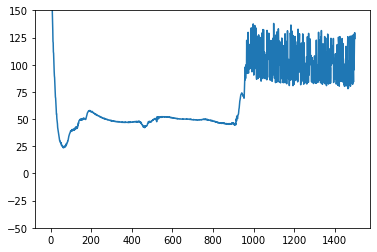

In [ ]:
env = gym.make(config["ENV"])
trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
action_dim = env.action_space.n
num_training_envs = config["NUM_TRAINING_ENVS"]

# run_seed = run_seed
batch_size = config["BATCH_SIZE"]
teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
teacher.load_pretrained()

buffer = fill_buffer(
    trajs_path=teacher.trajs_paths,
    batch_size=batch_size,
    run_seed=run_seed,
    traj_shift=config["TRAJ_SHIFT"],
    buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
    sampling_rate=config["SAMPLING_RATE"],
)

if buffer.total_size < batch_size:
    batch_size = buffer.total_size



##########################      COMMON      ##########################

print("state_dim", state_dim)

causal_features_encoder = FeaturesEncoder(
    input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
)

policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])




##########################       iVAE IRM       #######################


print("\n ***** Start Phase 1 ***** \n")

config['LATENT_DIM'] = state_dim  -1 # - 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

print("latent dim = ", config['LATENT_DIM'] )


ckpt_file = './vae/' + 'CartPole_partA_nfivae_ckpt.pt' #'./vae/' + config['ENV'] +'nfivae_ckpt.pt',
pa_dict_file =  './vae/' + 'CartPole_partA_nfivae_padict.pkl' #'./vae/' + config['ENV'] +'nfivae_padict.pkl',

vae_wrapper =  NFiVAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                            use_e = True, model_type= config['MODEL_TYPE'], lr = 1e-3, pa_dict_file = pa_dict_file, ckpt_file = ckpt_file, parents_threshold = config['PARENT_THRESHOLD'])

loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])#.cpu()

import matplotlib.pyplot as plt
plt.plot((np.array(loss_list)))
plt.ylim(-50,150)
plt.show()



# make student

In [5]:
config['MODEL_TYPE'] = 'iVAE'

In [9]:


# pylint: disable=redefined-outer-name
def make_student(run_seed, config):
    env = gym.make(config["ENV"])
    trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
    model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

    state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
    action_dim = env.action_space.n
    num_training_envs = config["NUM_TRAINING_ENVS"]

    # run_seed = run_seed
    batch_size = config["BATCH_SIZE"]
    teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
    teacher.load_pretrained()

    buffer = fill_buffer(
        trajs_path=teacher.trajs_paths,
        batch_size=batch_size,
        run_seed=run_seed,
        traj_shift=config["TRAJ_SHIFT"],
        buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
        sampling_rate=config["SAMPLING_RATE"],
    )

    if buffer.total_size < batch_size:
        batch_size = buffer.total_size



    ##########################      COMMON      ##########################

    print("state_dim", state_dim)

    causal_features_encoder = FeaturesEncoder(
        input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
    )

    policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])



    ##########################       BC       #######################

    if config['METHOD'] == 'BC':

        return BCStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


    ##########################       BC IRM       #######################


    elif config['METHOD'] == 'BCIRM':

        return BCIRMStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )



    ##########################       iVAE IRM       #######################

    elif config['METHOD'] == 'iVAE_IRM':


        print("\n ***** Start Phase 1 ***** \n")

        config['LATENT_DIM'] = state_dim # - 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

        print("latent dim = ", config['LATENT_DIM'] )


        ckpt_file = './vae/' + 'CartPole_partA_nfivae_ckpt.pt' #'./vae/' + config['ENV'] +'nfivae_ckpt.pt',
        pa_dict_file =  './vae/' + 'CartPole_partA_nfivae_padict.pkl' #'./vae/' + config['ENV'] +'nfivae_padict.pkl',

        vae_wrapper =  NFiVAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                                   use_e = True, model_type= config['MODEL_TYPE'], lr = 1e-3, pa_dict_file = pa_dict_file, ckpt_file = ckpt_file, parents_threshold = config['PARENT_THRESHOLD'])
 
        loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])#.cpu()

        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot((np.array(loss_list)))
        plt.yscale("log")
        #plt.ylim(-50,150)
        plt.show()


        plt.figure()
        plt.plot((np.array(loss_list)))
        #plt.yscale("log")
        plt.ylim(-50,150)
        plt.show()




        ########################################

        print("\n ***** Start Phase 2 ***** \n")
        if config['SELECT_PARENTS'] == True:
            vae_wrapper.start_phase2(n_samples = config['PHASE2_SAMPLES'])
        else:
            vae_wrapper.pa_list = [0,1,2,3,4,5,6,7] #, 8, 9, 10, 11]
        
        policy_network = StudentNetwork(in_dim=len(vae_wrapper.pa_list), out_dim=action_dim, width=config["MLP_WIDTHS"])
        
        #phase3_obs_to_latent_encoder = Phase3ObstoLatentEncoder(obs_size = state_dim, latent_size = len(vae_wrapper.pa_list))
            #input_size=state_dim, representation_size=len(vae_wrapper.pa_list), width=config["MLP_WIDTHS"] )
        
        
        return NFiVAE_IRMStudent(
            env=env,
            vae_wrapper = vae_wrapper,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            #phase3_obs_to_latent_encoder = phase3_obs_to_latent_encoder,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )
        


    ##########################       ICIL        #######################

    elif config['METHOD'] == 'ICIL':
        energy_model = EnergyModel(
            in_dim=state_dim,
            width=config["MLP_WIDTHS"],
            batch_size=batch_size,
            adam_alpha=config["ADAM_ALPHA"],
            buffer=buffer,
            sgld_buffer_size=config["SGLD_BUFFER_SIZE"],
            sgld_learn_rate=config["SGLD_LEARN_RATE"],
            sgld_noise_coef=config["SGLD_NOISE_COEF"],
            sgld_num_steps=config["SGLD_NUM_STEPS"],
            sgld_reinit_freq=config["SGLD_REINIT_FREQ"],
        )
        energy_model.train(num_updates=config["NUM_STEPS_TRAIN_ENERGY_MODEL"])

        causal_features_decoder = FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        observations_decoder = ObservationsDecoder(representation_size=config["REP_SIZE"], out_size=state_dim, width=config["MLP_WIDTHS"] )

        env_discriminator = EnvDiscriminator(representation_size=config["REP_SIZE"], num_envs=config["NUM_TRAINING_ENVS"], width=config["MLP_WIDTHS"])

        noise_features_encoders = [FeaturesEncoder(input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])  
            for i in range(num_training_envs)]
        
        noise_features_decoders = [FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])
            for i in range(num_training_envs)]

        mine_network = MineNetwork(x_dim=config["REP_SIZE"], z_dim=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        return ICILStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            noise_features_encoders=noise_features_encoders,
            causal_features_decoder=causal_features_decoder,
            noise_features_decoders=noise_features_decoders,
            observations_decoder=observations_decoder,
            env_discriminator=env_discriminator,
            policy_network=policy_network,
            energy_model=energy_model,
            mine_network=mine_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--env_name", default="CartPole-v1")
    parser.add_argument("--num_trajectories", default=20, type=int)
    parser.add_argument("--trial", default=0, type=int)
    return parser.parse_args()


# iVAE [threshold = 1]

In [8]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 1

batch size =  50000
Config: {'ALG': 'May2_iVAE_test1_th1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'iVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 1, 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.903217792510986best loss model loaded, stored at update # 1467


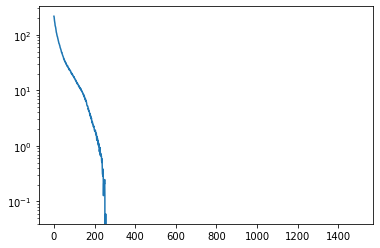

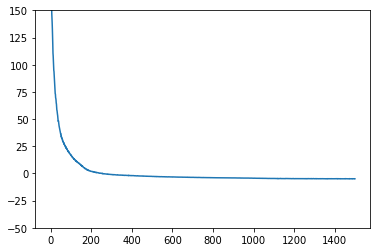


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.046704164426871676 and pval_i=0.9071061269692335
0 and 2 are independent with pval_d=0.4887607265114926 and pval_i=0.979764728057732
0 and 3 are DEPENDENT with pval_d=5.501862872926743e-05 and pval_i=2.616639180500179e-05
0 and 4 are independent with pval_d=0.7761200986502068 and pval_i=0.9997628796493164
0 and 5 are independent with pval_d=0.012681522498423185 and pval_i=0.9997165177490143
0 and 6 are independent with pval_d=0.7808529873326449 and pval_i=0.9778039130931143
0 and 7 are independent with pval_d=0.9933030403062958 and pval_i=0.9997911035095013
1 and 2 are DEPENDENT with pval_d=1.7562725408267027e-05 and pval_i=9.446384980668296e-08
1 and 3 are independent with pval_d=1.2019000578502023e-09 and pval_i=1.3478502239971365e-09
1 and 4 are independent with pval_d=0.029613677313365453 and pval_i=0.7335336422541004
1 and 5 are independent with pval_d=0.0002

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/student/nfivae_irm_student.py:287: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  x = torch.FloatTensor(all_states).to(self.device)


generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:02<03:31,  2.14s/it]

0 96.40484091639519


  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

1 91.08942840993404


  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

2 90.97139924764633


  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

3 90.90979181230068


  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

4 90.85547505319118


  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

5 90.84287630021572


  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

6 90.83834651112556


  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

7 90.79152649641037


  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

8 90.63685055077076


 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

9 90.68296597898006


 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

10 90.65597888827324


 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

11 90.69404019415379


 13%|█▎        | 13/100 [00:27<03:06,  2.15s/it]

12 90.59841699898243


 14%|█▍        | 14/100 [00:29<03:03,  2.14s/it]

13 90.56237033009529


 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

14 90.52711322903633


 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

15 90.57345992326736


 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

16 90.50301702320576


 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

17 90.49876345694065


 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

18 90.48681400716305


 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

19 90.46434792876244


 21%|██        | 21/100 [00:44<02:48,  2.13s/it]

20 90.50620241463184


 22%|██▏       | 22/100 [00:46<02:45,  2.13s/it]

21 90.4684968739748


 23%|██▎       | 23/100 [00:48<02:44,  2.13s/it]

22 90.50244557857513


 24%|██▍       | 24/100 [00:51<02:41,  2.12s/it]

23 90.39305485785007


 25%|██▌       | 25/100 [00:53<02:39,  2.13s/it]

24 90.41697360575199


 26%|██▌       | 26/100 [00:55<02:37,  2.13s/it]

25 90.43089807033539


 27%|██▋       | 27/100 [00:57<02:35,  2.13s/it]

26 90.39093978703022


 28%|██▊       | 28/100 [00:59<02:33,  2.13s/it]

27 90.36807265877724


 29%|██▉       | 29/100 [01:01<02:31,  2.13s/it]

28 90.41278478503227


 30%|███       | 30/100 [01:03<02:29,  2.14s/it]

29 90.39538110792637


 31%|███       | 31/100 [01:05<02:26,  2.13s/it]

30 90.4064394980669


 32%|███▏      | 32/100 [01:08<02:25,  2.13s/it]

31 90.39852902293205


 33%|███▎      | 33/100 [01:10<02:22,  2.12s/it]

32 90.39986965060234


 34%|███▍      | 34/100 [01:12<02:20,  2.12s/it]

33 90.34121251106262


 35%|███▌      | 35/100 [01:14<02:17,  2.12s/it]

34 90.32451336085796


 36%|███▌      | 36/100 [01:16<02:15,  2.11s/it]

35 90.40374663472176


 37%|███▋      | 37/100 [01:18<02:13,  2.12s/it]

36 90.34113450348377


 38%|███▊      | 38/100 [01:20<02:11,  2.12s/it]

37 90.3598011136055


 39%|███▉      | 39/100 [01:22<02:09,  2.13s/it]

38 90.37964133918285


 40%|████      | 40/100 [01:25<02:07,  2.13s/it]

39 90.39377804100513


 41%|████      | 41/100 [01:27<02:05,  2.13s/it]

40 90.33839198946953


 42%|████▏     | 42/100 [01:29<02:03,  2.13s/it]

41 90.31451070308685


 43%|████▎     | 43/100 [01:31<02:01,  2.13s/it]

42 90.32118239998817


 44%|████▍     | 44/100 [01:33<01:59,  2.13s/it]

43 90.34704524278641


 45%|████▌     | 45/100 [01:35<01:57,  2.14s/it]

44 90.34029886126518


 46%|████▌     | 46/100 [01:37<01:55,  2.15s/it]

45 90.32760941982269


 47%|████▋     | 47/100 [01:40<01:53,  2.13s/it]

46 90.3227728009224


 48%|████▊     | 48/100 [01:42<01:50,  2.13s/it]

47 90.4133003950119


 49%|████▉     | 49/100 [01:44<01:48,  2.13s/it]

48 90.34222657978535


 50%|█████     | 50/100 [01:46<01:46,  2.13s/it]

49 90.35194118320942


 51%|█████     | 51/100 [01:48<01:44,  2.12s/it]

50 90.26477354764938


 52%|█████▏    | 52/100 [01:50<01:41,  2.12s/it]

51 90.31952422857285


 53%|█████▎    | 53/100 [01:52<01:40,  2.13s/it]

52 90.33106236159801


 54%|█████▍    | 54/100 [01:54<01:37,  2.13s/it]

53 90.31433236598969


 55%|█████▌    | 55/100 [01:57<01:35,  2.12s/it]

54 90.34037679433823


 56%|█████▌    | 56/100 [01:59<01:33,  2.11s/it]

55 90.31278674304485


 57%|█████▋    | 57/100 [02:01<01:31,  2.12s/it]

56 90.3016811311245


 58%|█████▊    | 58/100 [02:03<01:29,  2.14s/it]

57 90.33435483276844


 59%|█████▉    | 59/100 [02:05<01:27,  2.13s/it]

58 90.36573176085949


 60%|██████    | 60/100 [02:07<01:25,  2.14s/it]

59 90.34087350964546


 61%|██████    | 61/100 [02:09<01:23,  2.13s/it]

60 90.31139999628067


 62%|██████▏   | 62/100 [02:11<01:20,  2.13s/it]

61 90.36068895459175


 63%|██████▎   | 63/100 [02:14<01:18,  2.12s/it]

62 90.28298312425613


 64%|██████▍   | 64/100 [02:16<01:16,  2.13s/it]

63 90.2963756620884


 65%|██████▌   | 65/100 [02:18<01:14,  2.12s/it]

64 90.34661346673965


 66%|██████▌   | 66/100 [02:20<01:11,  2.12s/it]

65 90.28521928191185


 67%|██████▋   | 67/100 [02:22<01:09,  2.12s/it]

66 90.32887177169323


 68%|██████▊   | 68/100 [02:24<01:07,  2.11s/it]

67 90.31701222062111


 69%|██████▉   | 69/100 [02:26<01:05,  2.11s/it]

68 90.33077220618725


 70%|███████   | 70/100 [02:28<01:03,  2.12s/it]

69 90.27521003782749


 71%|███████   | 71/100 [02:30<01:01,  2.11s/it]

70 90.27960985898972


 72%|███████▏  | 72/100 [02:33<00:59,  2.12s/it]

71 90.31637914478779


 73%|███████▎  | 73/100 [02:35<00:57,  2.13s/it]

72 90.2961019128561


 74%|███████▍  | 74/100 [02:37<00:55,  2.13s/it]

73 90.30509127676487


 75%|███████▌  | 75/100 [02:39<00:53,  2.13s/it]

74 90.34216704964638


 76%|███████▌  | 76/100 [02:41<00:50,  2.12s/it]

75 90.29134692251682


 77%|███████▋  | 77/100 [02:43<00:48,  2.11s/it]

76 90.30562463402748


 78%|███████▊  | 78/100 [02:45<00:46,  2.11s/it]

77 90.3065720051527


 79%|███████▉  | 79/100 [02:47<00:44,  2.12s/it]

78 90.31922556459904


 80%|████████  | 80/100 [02:50<00:42,  2.12s/it]

79 90.32333563268185


 81%|████████  | 81/100 [02:52<00:40,  2.12s/it]

80 90.293068125844


 82%|████████▏ | 82/100 [02:54<00:38,  2.12s/it]

81 90.30429916083813


 83%|████████▎ | 83/100 [02:56<00:36,  2.12s/it]

82 90.30695196986198


 84%|████████▍ | 84/100 [02:58<00:34,  2.13s/it]

83 90.285973533988


 85%|████████▌ | 85/100 [03:00<00:31,  2.13s/it]

84 90.32085989415646


 86%|████████▌ | 86/100 [03:02<00:29,  2.12s/it]

85 90.2753042280674


 87%|████████▋ | 87/100 [03:05<00:27,  2.14s/it]

86 90.29505056142807


 88%|████████▊ | 88/100 [03:07<00:25,  2.13s/it]

87 90.30682767927647


 89%|████████▉ | 89/100 [03:09<00:23,  2.13s/it]

88 90.28272946178913


 90%|█████████ | 90/100 [03:11<00:21,  2.13s/it]

89 90.28553974628448


 91%|█████████ | 91/100 [03:13<00:19,  2.13s/it]

90 90.31311900913715


 92%|█████████▏| 92/100 [03:15<00:16,  2.12s/it]

91 90.33539009094238


 93%|█████████▎| 93/100 [03:17<00:14,  2.14s/it]

92 90.3080422282219


 94%|█████████▍| 94/100 [03:19<00:12,  2.14s/it]

93 90.2726783901453


 95%|█████████▌| 95/100 [03:22<00:10,  2.13s/it]

94 90.30861128866673


 96%|█████████▌| 96/100 [03:24<00:08,  2.11s/it]

95 90.26310162246227


 97%|█████████▋| 97/100 [03:26<00:06,  2.12s/it]

96 90.32840000092983


 98%|█████████▊| 98/100 [03:28<00:04,  2.12s/it]

97 90.2822800129652


 99%|█████████▉| 99/100 [03:30<00:02,  2.13s/it]

98 90.31310719251633


100%|██████████| 100/100 [03:32<00:00,  2.13s/it]

99 90.27418404817581

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.0755009576678276	

epoch 9000/10000, policy loss 0.05427476763725281	
***** test student *****
epoch 0/100 return: 74.0
epoch 1/100 return: 57.0
epoch 2/100 return: 38.0
epoch 3/100 return: 33.0
epoch 4/100 return: 34.0
epoch 5/100 return: 56.0
epoch 6/100 return: 56.0
epoch 7/100 return: 100.0
epoch 8/100 return: 56.0
epoch 9/100 return: 55.0
epoch 10/100 return: 38.0
epoch 11/100 return: 71.0
epoch 12/100 return: 69.0
epoch 13/100 return: 61.0
epoch 14/100 return: 38.0
epoch 15/100 return: 34.0
epoch 16/100 return: 78.0
epoch 17/100 return: 54.0
epoch 18/100 return: 50.0
epoch 19/100 return: 44.0
epoch 20/100 return: 40.0
epoch 21/100 return: 36.0
epoch 22/100 return: 53.0
epoch 23/100 return: 28.0
epoch 24/100 return: 27.0
epoch 25/100 return: 33.0
epoch 26/100 return: 146.0
epoch 27/100 return: 33.0
epoch 28/100 return: 44.0
epoch 29/100 return: 43.0
epoch 30/100 return: 52.0
epoch 31/100 return: 103.0
epoch 32/100 return: 53.0
epoch 33/100 return: 40.0
epoch 34/100 return: 30.0
epoch 35/100 return: 

In [9]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May2_iVAE_test1_th1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [12]:
policy_loss_list_iVAE_1 = policy_loss_list

In [10]:
return_std

21.828465360624875

In [11]:
return_mean

53.59

In [14]:
policy_loss_list_iVAE_1[-1]

tensor(0.0540, device='cuda:0')

# iVAE [threshold = -1]

In [16]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

batch size =  50000
Config: {'ALG': 'May2_iVAE_test1_thneg1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'iVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.903217792510986best loss model loaded, stored at update # 1467


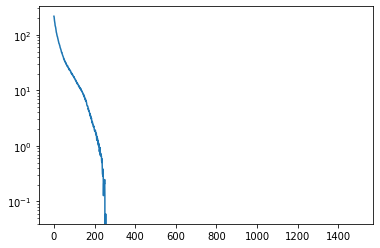

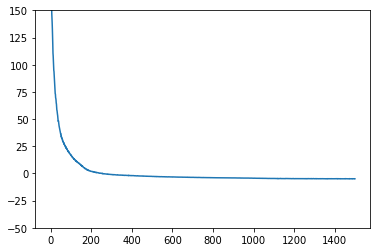


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.046704164426871676 and pval_i=0.9071061269692335
0 and 2 are independent with pval_d=0.4887607265114926 and pval_i=0.979764728057732
0 and 3 are DEPENDENT with pval_d=5.501862872926743e-05 and pval_i=2.616639180500179e-05
0 and 4 are independent with pval_d=0.7761200986502068 and pval_i=0.9997628796493164
0 and 5 are independent with pval_d=0.012681522498423185 and pval_i=0.9997165177490143
0 and 6 are independent with pval_d=0.7808529873326449 and pval_i=0.9778039130931143
0 and 7 are independent with pval_d=0.9933030403062958 and pval_i=0.9997911035095013
1 and 2 are DEPENDENT with pval_d=1.7562725408267027e-05 and pval_i=9.446384980668296e-08
1 and 3 are independent with pval_d=1.2019000578502023e-09 and pval_i=1.3478502239971365e-09
1 and 4 are independent with pval_d=0.029613677313365453 and pval_i=0.7335336422541004
1 and 5 are independent with pval_d=0.0002

  1%|          | 1/100 [00:02<03:30,  2.12s/it]

0 77.70198053121567


  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

1 73.64874278008938


  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

2 73.51651705801487


  4%|▍         | 4/100 [00:08<03:24,  2.14s/it]

3 73.51286640763283


  5%|▌         | 5/100 [00:10<03:21,  2.13s/it]

4 73.3567329198122


  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

5 73.388192653656


  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

6 73.33570994436741


  8%|▊         | 8/100 [00:17<03:17,  2.14s/it]

7 73.35791347920895


  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

8 73.24770650267601


 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

9 73.2988345772028


 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

10 73.25163233280182


 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

11 73.28201705217361


 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

12 73.22592125833035


 14%|█▍        | 14/100 [00:29<03:02,  2.13s/it]

13 73.18857015669346


 15%|█▌        | 15/100 [00:32<03:00,  2.13s/it]

14 73.17984180152416


 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

15 73.22220854461193


 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

16 73.16138136386871


 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

17 73.17533530294895


 19%|█▉        | 19/100 [00:41<03:06,  2.31s/it]

18 73.14808867871761


 20%|██        | 20/100 [00:43<03:01,  2.27s/it]

19 73.15825229883194


 21%|██        | 21/100 [00:45<02:56,  2.23s/it]

20 73.15757627785206


 22%|██▏       | 22/100 [00:47<02:52,  2.21s/it]

21 73.12468186020851


 23%|██▎       | 23/100 [00:49<02:48,  2.19s/it]

22 73.14448295533657


 24%|██▍       | 24/100 [00:51<02:44,  2.17s/it]

23 73.05365233123302


 25%|██▌       | 25/100 [00:54<02:42,  2.16s/it]

24 73.09940895438194


 26%|██▌       | 26/100 [00:56<02:40,  2.17s/it]

25 73.08753074705601


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 73.0389820933342


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 73.05198606848717


 29%|██▉       | 29/100 [01:02<02:32,  2.15s/it]

28 73.06413424015045


 30%|███       | 30/100 [01:04<02:30,  2.15s/it]

29 73.0539824962616


 31%|███       | 31/100 [01:06<02:28,  2.16s/it]

30 73.05616727471352


 32%|███▏      | 32/100 [01:09<02:26,  2.15s/it]

31 73.05598402023315


 33%|███▎      | 33/100 [01:11<02:23,  2.15s/it]

32 73.04672683775425


 34%|███▍      | 34/100 [01:13<02:21,  2.14s/it]

33 73.0061661452055


 35%|███▌      | 35/100 [01:15<02:18,  2.14s/it]

34 73.03076849877834


 36%|███▌      | 36/100 [01:17<02:17,  2.15s/it]

35 73.01734054088593


 37%|███▋      | 37/100 [01:19<02:15,  2.14s/it]

36 73.02621525526047


 38%|███▊      | 38/100 [01:21<02:13,  2.15s/it]

37 73.03702665865421


 39%|███▉      | 39/100 [01:24<02:10,  2.14s/it]

38 73.02706995606422


 40%|████      | 40/100 [01:26<02:08,  2.14s/it]

39 73.05595462024212


 41%|████      | 41/100 [01:28<02:06,  2.15s/it]

40 73.04135946929455


 42%|████▏     | 42/100 [01:30<02:03,  2.13s/it]

41 72.99617789685726


 43%|████▎     | 43/100 [01:32<02:01,  2.13s/it]

42 73.02713380753994


 44%|████▍     | 44/100 [01:34<01:59,  2.13s/it]

43 73.0144769847393


 45%|████▌     | 45/100 [01:36<01:57,  2.14s/it]

44 73.01446445286274


 46%|████▌     | 46/100 [01:39<01:55,  2.14s/it]

45 72.98642462491989


 47%|████▋     | 47/100 [01:41<01:53,  2.15s/it]

46 72.99292147159576


 48%|████▊     | 48/100 [01:43<01:52,  2.16s/it]

47 73.03878849744797


 49%|████▉     | 49/100 [01:45<01:50,  2.16s/it]

48 73.03404362499714


 50%|█████     | 50/100 [01:47<01:48,  2.16s/it]

49 73.00815892219543


 51%|█████     | 51/100 [01:49<01:45,  2.16s/it]

50 72.98202301561832


 52%|█████▏    | 52/100 [01:51<01:43,  2.15s/it]

51 73.00417396426201


 53%|█████▎    | 53/100 [01:54<01:40,  2.13s/it]

52 73.01707774400711


 54%|█████▍    | 54/100 [01:56<01:38,  2.14s/it]

53 72.99288067221642


 55%|█████▌    | 55/100 [01:58<01:36,  2.15s/it]

54 73.00671960413456


 56%|█████▌    | 56/100 [02:00<01:34,  2.15s/it]

55 72.99864400923252


 57%|█████▋    | 57/100 [02:02<01:32,  2.14s/it]

56 72.99801695346832


 58%|█████▊    | 58/100 [02:04<01:29,  2.14s/it]

57 72.99585400521755


 59%|█████▉    | 59/100 [02:06<01:27,  2.13s/it]

58 73.02445970475674


 60%|██████    | 60/100 [02:09<01:25,  2.14s/it]

59 73.01795701682568


 61%|██████    | 61/100 [02:11<01:23,  2.15s/it]

60 72.98838020861149


 62%|██████▏   | 62/100 [02:13<01:21,  2.14s/it]

61 73.0191356241703


 63%|██████▎   | 63/100 [02:15<01:19,  2.14s/it]

62 72.97391989827156


 64%|██████▍   | 64/100 [02:17<01:17,  2.14s/it]

63 72.9742775708437


 65%|██████▌   | 65/100 [02:19<01:14,  2.14s/it]

64 73.00185486674309


 66%|██████▌   | 66/100 [02:21<01:12,  2.14s/it]

65 72.99005328118801


 67%|██████▋   | 67/100 [02:24<01:10,  2.14s/it]

66 73.00004084408283


 68%|██████▊   | 68/100 [02:26<01:07,  2.12s/it]

67 72.98088431358337


 69%|██████▉   | 69/100 [02:28<01:06,  2.14s/it]

68 73.02037200331688


 70%|███████   | 70/100 [02:30<01:03,  2.13s/it]

69 72.97301986813545


 71%|███████   | 71/100 [02:32<01:01,  2.12s/it]

70 72.98698130249977


 72%|███████▏  | 72/100 [02:34<00:59,  2.11s/it]

71 72.98636223375797


 73%|███████▎  | 73/100 [02:36<00:56,  2.10s/it]

72 72.98177383840084


 74%|███████▍  | 74/100 [02:38<00:54,  2.11s/it]

73 73.0111813545227


 75%|███████▌  | 75/100 [02:40<00:52,  2.12s/it]

74 73.00441633164883


 76%|███████▌  | 76/100 [02:43<00:50,  2.12s/it]

75 72.98573340475559


 77%|███████▋  | 77/100 [02:45<00:48,  2.12s/it]

76 72.99796915054321


 78%|███████▊  | 78/100 [02:47<00:46,  2.13s/it]

77 72.9801077246666


 79%|███████▉  | 79/100 [02:49<00:44,  2.14s/it]

78 72.99438385665417


 80%|████████  | 80/100 [02:51<00:42,  2.14s/it]

79 73.00757250189781


 81%|████████  | 81/100 [02:53<00:40,  2.13s/it]

80 72.97995983064175


 82%|████████▏ | 82/100 [02:55<00:38,  2.13s/it]

81 72.98324857652187


 83%|████████▎ | 83/100 [02:58<00:36,  2.13s/it]

82 72.98525284230709


 84%|████████▍ | 84/100 [03:00<00:34,  2.14s/it]

83 72.97875614464283


 85%|████████▌ | 85/100 [03:02<00:32,  2.14s/it]

84 73.00525312125683


 86%|████████▌ | 86/100 [03:04<00:29,  2.13s/it]

85 72.98099833726883


 87%|████████▋ | 87/100 [03:06<00:27,  2.12s/it]

86 72.99144540727139


 88%|████████▊ | 88/100 [03:08<00:25,  2.12s/it]

87 72.9906819164753


 89%|████████▉ | 89/100 [03:10<00:23,  2.13s/it]

88 72.95707976818085


 90%|█████████ | 90/100 [03:12<00:21,  2.13s/it]

89 72.99086448550224


 91%|█████████ | 91/100 [03:15<00:19,  2.13s/it]

90 72.98477932810783


 92%|█████████▏| 92/100 [03:17<00:17,  2.13s/it]

91 72.99440525472164


 93%|█████████▎| 93/100 [03:19<00:14,  2.13s/it]

92 73.00109349191189


 94%|█████████▍| 94/100 [03:21<00:12,  2.12s/it]

93 72.97699296474457


 95%|█████████▌| 95/100 [03:23<00:10,  2.13s/it]

94 72.9883026778698


 96%|█████████▌| 96/100 [03:25<00:08,  2.12s/it]

95 72.9872899800539


 97%|█████████▋| 97/100 [03:27<00:06,  2.12s/it]

96 72.97911715507507


 98%|█████████▊| 98/100 [03:29<00:04,  2.12s/it]

97 72.97057622671127


 99%|█████████▉| 99/100 [03:32<00:02,  2.11s/it]

98 72.96374003589153


100%|██████████| 100/100 [03:34<00:00,  2.14s/it]

99 72.96535517275333

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.08412966132164001	

epoch 9000/10000, policy loss 0.048820480704307556	
***** test student *****
epoch 0/100 return: 19.0
epoch 1/100 return: 16.0
epoch 2/100 return: 19.0
epoch 3/100 return: 14.0
epoch 4/100 return: 16.0
epoch 5/100 return: 16.0
epoch 6/100 return: 15.0
epoch 7/100 return: 16.0
epoch 8/100 return: 14.0
epoch 9/100 return: 16.0
epoch 10/100 return: 18.0
epoch 11/100 return: 18.0
epoch 12/100 return: 17.0
epoch 13/100 return: 19.0
epoch 14/100 return: 19.0
epoch 15/100 return: 17.0
epoch 16/100 return: 17.0
epoch 17/100 return: 16.0
epoch 18/100 return: 17.0
epoch 19/100 return: 17.0
epoch 20/100 return: 18.0
epoch 21/100 return: 16.0
epoch 22/100 return: 15.0
epoch 23/100 return: 16.0
epoch 24/100 return: 13.0
epoch 25/100 return: 16.0
epoch 26/100 return: 16.0
epoch 27/100 return: 14.0
epoch 28/100 return: 19.0
epoch 29/100 return: 19.0
epoch 30/100 return: 16.0
epoch 31/100 return: 18.0
epoch 32/100 return: 19.0
epoch 33/100 return: 14.0
epoch 34/100 return: 18.0
epoch 35/100 return: 16

In [17]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May2_iVAE_test1_thneg1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_iVAE_neg1 = policy_loss_list

In [ ]:
return_std

21.828465360624875

In [ ]:
return_mean

53.59

# iVAE [threshold = -1, state_dim = 5]

In [22]:
config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

batch size =  50000
Config: {'ALG': 'May2_iVAE_test1_thneg1_statedim5_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'iVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 1 out of 10

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.977195739746094best loss model loaded, stored at update # 1498


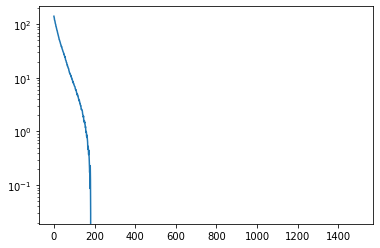

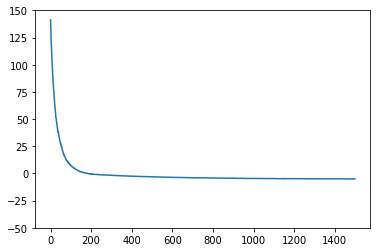


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.9545551405286101 and pval_i=0.9878399174350629
0 and 2 are independent with pval_d=6.256212436163299e-07 and pval_i=0.00011089376989760296
0 and 3 are independent with pval_d=1.4911745073727106e-05 and pval_i=0.00010714524640179586
0 and 4 are DEPENDENT with pval_d=0.35842422133285123 and pval_i=2.851534665782951e-06
1 and 2 are DEPENDENT with pval_d=1.0474143181633404e-07 and pval_i=4.152887046154224e-08
1 and 3 are independent with pval_d=0.0005981954012227699 and pval_i=0.0019039939391036474
1 and 4 are independent with pval_d=0.7895309644787046 and pval_i=0.9511245418794843
2 and 3 are DEPENDENT with pval_d=1.2892026024034217e-07 and pval_i=9.361260420307685e-08
2 and 4 are DEPENDENT with pval_d=1.5511831928714222e-05 and pval_i=8.345257117141303e-06
3 and 4 are DEPENDENT with pval_d=2.576191541405419e-07 and pval_i=9.137079364311718e-08
2 3
4 3
3 2
0 1
1 1
pa

  1%|          | 1/100 [00:02<03:29,  2.11s/it]

0 87.87578305602074


  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

1 80.67123420536518


  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

2 80.67089077830315


  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

3 80.45615769922733


  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

4 80.48162716627121


  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

5 80.52705225348473


  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

6 80.34124071896076


  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

7 80.3835891932249


  9%|▉         | 9/100 [00:19<03:15,  2.14s/it]

8 80.25272756814957


 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

9 80.23243092000484


 11%|█         | 11/100 [00:23<03:10,  2.15s/it]

10 80.2606268376112


 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

11 80.2398879379034


 13%|█▎        | 13/100 [00:27<03:05,  2.14s/it]

12 80.19221079349518


 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

13 80.17498429119587


 15%|█▌        | 15/100 [00:32<03:01,  2.14s/it]

14 80.16996863484383


 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

15 80.12432153522968


 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

16 80.14276072382927


 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

17 80.09857374429703


 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

18 80.00658620893955


 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

19 80.08013269305229


 21%|██        | 21/100 [00:44<02:49,  2.14s/it]

20 80.05893856287003


 22%|██▏       | 22/100 [00:47<02:46,  2.14s/it]

21 80.06549142301083


 23%|██▎       | 23/100 [00:49<02:44,  2.14s/it]

22 80.02725909650326


 24%|██▍       | 24/100 [00:51<02:42,  2.14s/it]

23 80.04353620111942


 25%|██▌       | 25/100 [00:53<02:40,  2.15s/it]

24 80.02188996970654


 26%|██▌       | 26/100 [00:55<02:39,  2.15s/it]

25 80.04702048003674


 27%|██▋       | 27/100 [00:57<02:36,  2.14s/it]

26 79.95142237842083


 28%|██▊       | 28/100 [00:59<02:33,  2.14s/it]

27 80.02045522630215


 29%|██▉       | 29/100 [01:01<02:31,  2.13s/it]

28 80.02724894881248


 30%|███       | 30/100 [01:04<02:28,  2.12s/it]

29 79.95834602415562


 31%|███       | 31/100 [01:06<02:26,  2.12s/it]

30 79.97955040633678


 32%|███▏      | 32/100 [01:08<02:24,  2.13s/it]

31 79.91843211650848


 33%|███▎      | 33/100 [01:10<02:22,  2.13s/it]

32 79.99291674792767


 34%|███▍      | 34/100 [01:12<02:20,  2.14s/it]

33 79.96938872337341


 35%|███▌      | 35/100 [01:14<02:19,  2.15s/it]

34 79.96181890368462


 36%|███▌      | 36/100 [01:17<02:29,  2.33s/it]

35 79.98443004488945


 37%|███▋      | 37/100 [01:19<02:23,  2.28s/it]

36 79.92850711941719


 38%|███▊      | 38/100 [01:21<02:18,  2.24s/it]

37 79.93577940762043


 39%|███▉      | 39/100 [01:24<02:14,  2.21s/it]

38 79.95031601190567


 40%|████      | 40/100 [01:26<02:10,  2.18s/it]

39 79.92385648190975


 41%|████      | 41/100 [01:28<02:08,  2.18s/it]

40 79.9603840559721


 42%|████▏     | 42/100 [01:30<02:05,  2.16s/it]

41 79.9539669752121


 43%|████▎     | 43/100 [01:32<02:03,  2.16s/it]

42 79.97828315198421


 44%|████▍     | 44/100 [01:34<02:00,  2.15s/it]

43 79.93884211778641


 45%|████▌     | 45/100 [01:36<01:57,  2.14s/it]

44 79.96496100723743


 46%|████▌     | 46/100 [01:38<01:55,  2.15s/it]

45 79.9077346175909


 47%|████▋     | 47/100 [01:41<01:53,  2.15s/it]

46 79.88104996085167


 48%|████▊     | 48/100 [01:43<01:51,  2.14s/it]

47 79.90654663741589


 49%|████▉     | 49/100 [01:45<01:49,  2.14s/it]

48 79.9114759862423


 50%|█████     | 50/100 [01:47<01:47,  2.15s/it]

49 79.94738899171352


 51%|█████     | 51/100 [01:49<01:45,  2.16s/it]

50 79.97898185253143


 52%|█████▏    | 52/100 [01:51<01:43,  2.16s/it]

51 79.92055010795593


 53%|█████▎    | 53/100 [01:54<01:41,  2.17s/it]

52 79.88598366081715


 54%|█████▍    | 54/100 [01:56<01:39,  2.17s/it]

53 79.9053893238306


 55%|█████▌    | 55/100 [01:58<01:37,  2.16s/it]

54 79.95476795732975


 56%|█████▌    | 56/100 [02:00<01:34,  2.15s/it]

55 79.86246936023235


 57%|█████▋    | 57/100 [02:02<01:32,  2.15s/it]

56 79.88504959642887


 58%|█████▊    | 58/100 [02:04<01:30,  2.15s/it]

57 79.88778227567673


 59%|█████▉    | 59/100 [02:06<01:27,  2.14s/it]

58 79.8876828700304


 60%|██████    | 60/100 [02:09<01:25,  2.14s/it]

59 79.91135893762112


 61%|██████    | 61/100 [02:11<01:23,  2.14s/it]

60 79.90876844525337


 62%|██████▏   | 62/100 [02:13<01:21,  2.15s/it]

61 79.85521014034748


 63%|██████▎   | 63/100 [02:15<01:19,  2.15s/it]

62 79.86898800730705


 64%|██████▍   | 64/100 [02:17<01:16,  2.14s/it]

63 79.86683729290962


 65%|██████▌   | 65/100 [02:19<01:14,  2.14s/it]

64 79.83345657587051


 66%|██████▌   | 66/100 [02:21<01:12,  2.14s/it]

65 79.91459628939629


 67%|██████▋   | 67/100 [02:24<01:10,  2.14s/it]

66 79.8999237716198


 68%|██████▊   | 68/100 [02:26<01:08,  2.15s/it]

67 79.8776075989008


 69%|██████▉   | 69/100 [02:28<01:06,  2.15s/it]

68 79.89068095386028


 70%|███████   | 70/100 [02:30<01:04,  2.16s/it]

69 79.89382241666317


 71%|███████   | 71/100 [02:32<01:02,  2.15s/it]

70 79.86809301376343


 72%|███████▏  | 72/100 [02:34<01:00,  2.14s/it]

71 79.87631951272488


 73%|███████▎  | 73/100 [02:37<00:57,  2.14s/it]

72 79.90001022815704


 74%|███████▍  | 74/100 [02:39<00:55,  2.14s/it]

73 79.86400020122528


 75%|███████▌  | 75/100 [02:41<00:53,  2.14s/it]

74 79.9097567498684


 76%|███████▌  | 76/100 [02:43<00:51,  2.14s/it]

75 79.87500736117363


 77%|███████▋  | 77/100 [02:45<00:49,  2.14s/it]

76 79.92727993428707


 78%|███████▊  | 78/100 [02:47<00:47,  2.14s/it]

77 79.88711878657341


 79%|███████▉  | 79/100 [02:49<00:45,  2.15s/it]

78 79.82845199108124


 80%|████████  | 80/100 [02:52<00:43,  2.15s/it]

79 79.88425789773464


 81%|████████  | 81/100 [02:54<00:41,  2.16s/it]

80 79.86585000157356


 82%|████████▏ | 82/100 [02:56<00:38,  2.15s/it]

81 79.94795198738575


 83%|████████▎ | 83/100 [02:58<00:36,  2.15s/it]

82 79.80550216138363


 84%|████████▍ | 84/100 [03:00<00:34,  2.14s/it]

83 79.86995042860508


 85%|████████▌ | 85/100 [03:02<00:32,  2.15s/it]

84 79.88464672863483


 86%|████████▌ | 86/100 [03:04<00:30,  2.14s/it]

85 79.86794674396515


 87%|████████▋ | 87/100 [03:07<00:27,  2.13s/it]

86 79.83417801558971


 88%|████████▊ | 88/100 [03:09<00:25,  2.12s/it]

87 79.81864705681801


 89%|████████▉ | 89/100 [03:11<00:23,  2.13s/it]

88 79.85343281924725


 90%|█████████ | 90/100 [03:13<00:21,  2.14s/it]

89 79.86430791020393


 91%|█████████ | 91/100 [03:15<00:19,  2.13s/it]

90 79.8755159676075


 92%|█████████▏| 92/100 [03:17<00:17,  2.13s/it]

91 79.8367780148983


 93%|█████████▎| 93/100 [03:19<00:14,  2.14s/it]

92 79.90044716000557


 94%|█████████▍| 94/100 [03:21<00:12,  2.14s/it]

93 79.84572596848011


 95%|█████████▌| 95/100 [03:24<00:10,  2.15s/it]

94 79.88385485112667


 96%|█████████▌| 96/100 [03:26<00:08,  2.15s/it]

95 79.85020510852337


 97%|█████████▋| 97/100 [03:28<00:06,  2.16s/it]

96 79.87751758098602


 98%|█████████▊| 98/100 [03:30<00:04,  2.15s/it]

97 79.85584233701229


 99%|█████████▉| 99/100 [03:32<00:02,  2.15s/it]

98 79.87783528864384


100%|██████████| 100/100 [03:34<00:00,  2.15s/it]

99 79.85772746801376

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07672376185655594	

epoch 9000/10000, policy loss 0.044479504227638245	
***** test student *****
epoch 0/100 return: 49.0
epoch 1/100 return: 45.0
epoch 2/100 return: 45.0
epoch 3/100 return: 107.0
epoch 4/100 return: 62.0
epoch 5/100 return: 43.0
epoch 6/100 return: 48.0
epoch 7/100 return: 93.0
epoch 8/100 return: 53.0
epoch 9/100 return: 46.0
epoch 10/100 return: 39.0
epoch 11/100 return: 95.0
epoch 12/100 return: 38.0
epoch 13/100 return: 55.0
epoch 14/100 return: 38.0
epoch 15/100 return: 59.0
epoch 16/100 return: 47.0
epoch 17/100 return: 46.0
epoch 18/100 return: 69.0
epoch 19/100 return: 46.0
epoch 20/100 return: 84.0
epoch 21/100 return: 128.0
epoch 22/100 return: 53.0
epoch 23/100 return: 53.0
epoch 24/100 return: 71.0
epoch 25/100 return: 50.0
epoch 26/100 return: 48.0
epoch 27/100 return: 44.0
epoch 28/100 return: 56.0
epoch 29/100 return: 41.0
epoch 30/100 return: 35.0
epoch 31/100 return: 72.0
epoch 32/100 return: 43.0
epoch 33/100 return: 47.0
epoch 34/100 return: 52.0
epoch 35/100 return: 

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.999739646911621best loss model loaded, stored at update # 1432


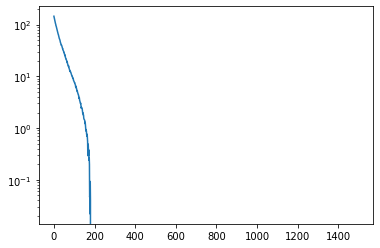

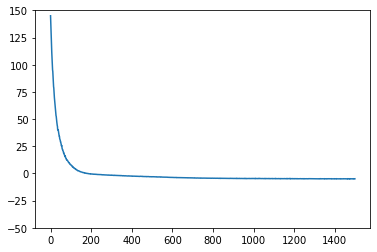


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.6840643176188708 and pval_i=0.8040385828864728
0 and 2 are DEPENDENT with pval_d=4.248267399309185e-08 and pval_i=2.0667110280565477e-08
0 and 3 are independent with pval_d=3.836540590152696e-07 and pval_i=2.9507150651996036e-06
0 and 4 are DEPENDENT with pval_d=5.2451354750345686e-05 and pval_i=4.4507814272735394e-06
1 and 2 are DEPENDENT with pval_d=4.496737391527062e-08 and pval_i=2.6718737482052387e-09
1 and 3 are independent with pval_d=0.002154796820361567 and pval_i=0.024078883745205094
1 and 4 are independent with pval_d=0.0006132015960474219 and pval_i=0.08946335764005525
2 and 3 are independent with pval_d=1.8435256667583445e-06 and pval_i=7.5777305183498e-06
2 and 4 are independent with pval_d=7.407445231434009e-05 and pval_i=0.00031185745016895357
3 and 4 are DEPENDENT with pval_d=1.0000502618275322e-06 and pval_i=4.066787905564208e-07
0 2
2 2
4 2
1 1


  1%|          | 1/100 [00:02<03:32,  2.15s/it]

0 134.22713468968868


  2%|▏         | 2/100 [00:04<03:34,  2.18s/it]

1 126.09958003461361


  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

2 126.0995584577322


  4%|▍         | 4/100 [00:08<03:28,  2.17s/it]

3 126.08527439832687


  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

4 125.84843565523624


  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

5 125.90062238276005


  7%|▋         | 7/100 [00:15<03:22,  2.17s/it]

6 125.74907147884369


  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

7 125.89304549992085


  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

8 125.63693179190159


 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

9 125.53574854135513


 11%|█         | 11/100 [00:23<03:10,  2.15s/it]

10 125.58830861747265


 12%|█▏        | 12/100 [00:25<03:08,  2.15s/it]

11 125.50954554975033


 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

12 125.45700532197952


 14%|█▍        | 14/100 [00:30<03:04,  2.14s/it]

13 125.4095563441515


 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

14 125.32573772966862


 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

15 125.40850494801998


 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

16 125.33114808797836


 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

17 125.35418212413788


 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

18 125.30114774405956


 20%|██        | 20/100 [00:43<02:53,  2.16s/it]

19 125.32479667663574


 21%|██        | 21/100 [00:45<02:50,  2.16s/it]

20 125.24955300986767


 22%|██▏       | 22/100 [00:47<02:48,  2.15s/it]

21 125.30458591878414


 23%|██▎       | 23/100 [00:49<02:45,  2.15s/it]

22 125.2578437179327


 24%|██▍       | 24/100 [00:51<02:43,  2.15s/it]

23 125.27485238015652


 25%|██▌       | 25/100 [00:53<02:40,  2.14s/it]

24 125.24047760665417


 26%|██▌       | 26/100 [00:56<02:39,  2.15s/it]

25 125.23848128318787


 27%|██▋       | 27/100 [00:58<02:37,  2.15s/it]

26 125.28361414372921


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 125.27872540056705


 29%|██▉       | 29/100 [01:02<02:32,  2.15s/it]

28 125.25281037390232


 30%|███       | 30/100 [01:04<02:30,  2.15s/it]

29 125.17177417874336


 31%|███       | 31/100 [01:06<02:28,  2.15s/it]

30 125.22684098780155


 32%|███▏      | 32/100 [01:09<02:27,  2.17s/it]

31 125.19493556022644


 33%|███▎      | 33/100 [01:11<02:25,  2.17s/it]

32 125.24183131754398


 34%|███▍      | 34/100 [01:13<02:23,  2.17s/it]

33 125.24916286766529


 35%|███▌      | 35/100 [01:15<02:20,  2.16s/it]

34 125.16959623992443


 36%|███▌      | 36/100 [01:17<02:17,  2.15s/it]

35 125.17992965877056


 37%|███▋      | 37/100 [01:19<02:16,  2.16s/it]

36 125.23591601848602


 38%|███▊      | 38/100 [01:22<02:14,  2.17s/it]

37 125.17785932123661


 39%|███▉      | 39/100 [01:24<02:12,  2.17s/it]

38 125.22132140398026


 40%|████      | 40/100 [01:26<02:10,  2.17s/it]

39 125.1984626352787


 41%|████      | 41/100 [01:28<02:07,  2.17s/it]

40 125.14658308029175


 42%|████▏     | 42/100 [01:30<02:06,  2.18s/it]

41 125.23467628657818


 43%|████▎     | 43/100 [01:32<02:03,  2.17s/it]

42 125.1402726918459


 44%|████▍     | 44/100 [01:35<02:01,  2.16s/it]

43 125.1642114520073


 45%|████▌     | 45/100 [01:37<01:58,  2.15s/it]

44 125.1312920153141


 46%|████▌     | 46/100 [01:39<01:56,  2.15s/it]

45 125.17499724030495


 47%|████▋     | 47/100 [01:41<01:53,  2.15s/it]

46 125.11730325222015


 48%|████▊     | 48/100 [01:43<01:51,  2.14s/it]

47 125.10580277442932


 49%|████▉     | 49/100 [01:45<01:49,  2.14s/it]

48 125.13992910087109


 50%|█████     | 50/100 [01:47<01:47,  2.15s/it]

49 125.16573098301888


 51%|█████     | 51/100 [01:50<01:44,  2.14s/it]

50 125.21769711375237


 52%|█████▏    | 52/100 [01:52<01:43,  2.15s/it]

51 125.13206954300404


 53%|█████▎    | 53/100 [01:54<01:41,  2.15s/it]

52 125.1260791271925


 54%|█████▍    | 54/100 [01:56<01:39,  2.15s/it]

53 125.13754242658615


 55%|█████▌    | 55/100 [01:58<01:37,  2.16s/it]

54 125.17768421769142


 56%|█████▌    | 56/100 [02:00<01:35,  2.16s/it]

55 125.14084173738956


 57%|█████▋    | 57/100 [02:02<01:32,  2.16s/it]

56 125.10464060306549


 58%|█████▊    | 58/100 [02:05<01:30,  2.16s/it]

57 125.13050849735737


 59%|█████▉    | 59/100 [02:07<01:27,  2.14s/it]

58 125.1885851919651


 60%|██████    | 60/100 [02:09<01:25,  2.14s/it]

59 125.11850017309189


 61%|██████    | 61/100 [02:11<01:23,  2.14s/it]

60 125.14565600454807


 62%|██████▏   | 62/100 [02:13<01:21,  2.15s/it]

61 125.1589002609253


 63%|██████▎   | 63/100 [02:15<01:19,  2.15s/it]

62 125.09131249785423


 64%|██████▍   | 64/100 [02:17<01:17,  2.15s/it]

63 125.15539745986462


 65%|██████▌   | 65/100 [02:20<01:15,  2.16s/it]

64 125.1067511588335


 66%|██████▌   | 66/100 [02:22<01:13,  2.17s/it]

65 125.14356988668442


 67%|██████▋   | 67/100 [02:24<01:11,  2.17s/it]

66 125.12232005596161


 68%|██████▊   | 68/100 [02:26<01:09,  2.17s/it]

67 125.17480559647083


 69%|██████▉   | 69/100 [02:28<01:07,  2.16s/it]

68 125.15916241705418


 70%|███████   | 70/100 [02:31<01:04,  2.16s/it]

69 125.13322013616562


 71%|███████   | 71/100 [02:33<01:02,  2.17s/it]

70 125.1278231292963


 72%|███████▏  | 72/100 [02:35<01:00,  2.17s/it]

71 125.12257309257984


 73%|███████▎  | 73/100 [02:37<00:58,  2.16s/it]

72 125.10449275374413


 74%|███████▍  | 74/100 [02:39<00:56,  2.15s/it]

73 125.13721269369125


 75%|███████▌  | 75/100 [02:41<00:53,  2.16s/it]

74 125.13372357189655


 76%|███████▌  | 76/100 [02:43<00:51,  2.15s/it]

75 125.14035911858082


 77%|███████▋  | 77/100 [02:46<00:49,  2.14s/it]

76 125.07432599365711


 78%|███████▊  | 78/100 [02:48<00:47,  2.16s/it]

77 125.17137955129147


 79%|███████▉  | 79/100 [02:50<00:45,  2.16s/it]

78 125.09189991652966


 80%|████████  | 80/100 [02:52<00:43,  2.15s/it]

79 125.08498598635197


 81%|████████  | 81/100 [02:54<00:40,  2.15s/it]

80 125.11655987799168


 82%|████████▏ | 82/100 [02:56<00:38,  2.15s/it]

81 125.14421081542969


 83%|████████▎ | 83/100 [02:59<00:36,  2.16s/it]

82 125.04419453442097


 84%|████████▍ | 84/100 [03:01<00:34,  2.15s/it]

83 125.16074828803539


 85%|████████▌ | 85/100 [03:03<00:32,  2.16s/it]

84 125.12309716641903


 86%|████████▌ | 86/100 [03:05<00:30,  2.17s/it]

85 125.1541044563055


 87%|████████▋ | 87/100 [03:07<00:28,  2.16s/it]

86 125.09123229980469


 88%|████████▊ | 88/100 [03:09<00:25,  2.15s/it]

87 125.0744139701128


 89%|████████▉ | 89/100 [03:11<00:23,  2.15s/it]

88 125.10736952722073


 90%|█████████ | 90/100 [03:14<00:21,  2.16s/it]

89 125.12193594872952


 91%|█████████ | 91/100 [03:16<00:19,  2.16s/it]

90 125.06249749660492


 92%|█████████▏| 92/100 [03:18<00:17,  2.16s/it]

91 125.09943901002407


 93%|█████████▎| 93/100 [03:20<00:15,  2.15s/it]

92 125.18037338554859


 94%|█████████▍| 94/100 [03:22<00:12,  2.15s/it]

93 125.12399435043335


 95%|█████████▌| 95/100 [03:24<00:10,  2.15s/it]

94 125.07543124258518


 96%|█████████▌| 96/100 [03:27<00:08,  2.15s/it]

95 125.13587152957916


 97%|█████████▋| 97/100 [03:29<00:06,  2.15s/it]

96 125.12657949328423


 98%|█████████▊| 98/100 [03:31<00:04,  2.16s/it]

97 125.06557036936283


 99%|█████████▉| 99/100 [03:33<00:02,  2.15s/it]

98 125.12894870340824


100%|██████████| 100/100 [03:35<00:00,  2.16s/it]

99 125.07480646669865

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07772250473499298	

epoch 9000/10000, policy loss 0.04966359585523605	
***** test student *****
epoch 0/100 return: 29.0
epoch 1/100 return: 29.0
epoch 2/100 return: 25.0
epoch 3/100 return: 23.0
epoch 4/100 return: 26.0
epoch 5/100 return: 22.0
epoch 6/100 return: 22.0
epoch 7/100 return: 25.0
epoch 8/100 return: 25.0
epoch 9/100 return: 21.0
epoch 10/100 return: 23.0
epoch 11/100 return: 25.0
epoch 12/100 return: 26.0
epoch 13/100 return: 27.0
epoch 14/100 return: 30.0
epoch 15/100 return: 19.0
epoch 16/100 return: 28.0
epoch 17/100 return: 24.0
epoch 18/100 return: 25.0
epoch 19/100 return: 20.0
epoch 20/100 return: 23.0
epoch 21/100 return: 31.0
epoch 22/100 return: 24.0
epoch 23/100 return: 20.0
epoch 24/100 return: 27.0
epoch 25/100 return: 27.0
epoch 26/100 return: 29.0
epoch 27/100 return: 21.0
epoch 28/100 return: 20.0
epoch 29/100 return: 30.0
epoch 30/100 return: 25.0
epoch 31/100 return: 21.0
epoch 32/100 return: 25.0
epoch 33/100 return: 23.0
epoch 34/100 return: 17.0
epoch 35/100 return: 18.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.909994602203369best loss model loaded, stored at update # 1476


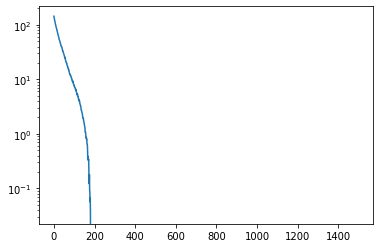

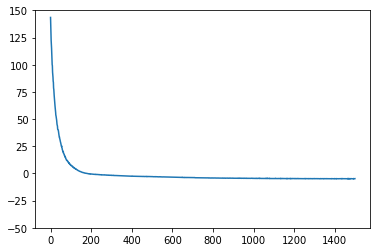


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=1.6127878548533233e-06 and pval_i=4.56876865188336e-05
0 and 2 are independent with pval_d=4.6556204099333334e-09 and pval_i=1.0419882646880419e-08
0 and 3 are independent with pval_d=4.866574301288192e-07 and pval_i=1.452029479301206e-06
0 and 4 are DEPENDENT with pval_d=3.183009637678368e-05 and pval_i=1.9907109207992807e-08
1 and 2 are independent with pval_d=7.493853551635642e-10 and pval_i=1.8115890708510695e-09
1 and 3 are DEPENDENT with pval_d=0.001555624922679929 and pval_i=1.4657367221255125e-06
1 and 4 are DEPENDENT with pval_d=0.001783229705371162 and pval_i=1.523812994538639e-07
2 and 3 are independent with pval_d=3.0081097566492307e-06 and pval_i=5.191454126986781e-06
2 and 4 are DEPENDENT with pval_d=4.0444443547903744e-06 and pval_i=9.078916833751554e-09
3 and 4 are independent with pval_d=2.891605037413205e-07 and pval_i=1.4694766107719888e-05
4 3
1 

  1%|          | 1/100 [00:02<03:30,  2.12s/it]

0 139.95518371462822


  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

1 130.06816945970058


  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

2 129.83783577382565


  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

3 129.90948133170605


  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

4 129.66447788476944


  6%|▌         | 6/100 [00:12<03:22,  2.15s/it]

5 129.65608775615692


  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

6 129.5217220634222


  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

7 129.5448878109455


  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

8 129.40294216573238


 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

9 129.26755072176456


 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

10 129.36779749393463


 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

11 129.32551485300064


 13%|█▎        | 13/100 [00:28<03:08,  2.17s/it]

12 129.25896196067333


 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

13 129.21784688532352


 15%|█▌        | 15/100 [00:32<03:04,  2.18s/it]

14 129.1549032330513


 16%|█▌        | 16/100 [00:34<03:03,  2.18s/it]

15 129.25898899137974


 17%|█▋        | 17/100 [00:36<03:03,  2.21s/it]

16 129.16206662356853


 18%|█▊        | 18/100 [00:39<03:00,  2.21s/it]

17 129.21365927159786


 19%|█▉        | 19/100 [00:41<02:58,  2.20s/it]

18 129.08938835561275


 20%|██        | 20/100 [00:43<02:55,  2.20s/it]

19 129.11674776673317


 21%|██        | 21/100 [00:45<02:52,  2.18s/it]

20 129.0767184793949


 22%|██▏       | 22/100 [00:47<02:49,  2.18s/it]

21 129.10766030848026


 23%|██▎       | 23/100 [00:49<02:47,  2.17s/it]

22 129.02899415791035


 24%|██▍       | 24/100 [00:52<02:45,  2.17s/it]

23 129.09500047564507


 25%|██▌       | 25/100 [00:54<02:42,  2.17s/it]

24 129.02898840606213


 26%|██▌       | 26/100 [00:56<02:40,  2.16s/it]

25 128.987273350358


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 129.07545733451843


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 129.0189572572708


 29%|██▉       | 29/100 [01:02<02:32,  2.15s/it]

28 129.04135844111443


 30%|███       | 30/100 [01:05<02:31,  2.16s/it]

29 128.98971077799797


 31%|███       | 31/100 [01:07<02:29,  2.16s/it]

30 129.04455289244652


 32%|███▏      | 32/100 [01:09<02:27,  2.16s/it]

31 128.96589994430542


 33%|███▎      | 33/100 [01:11<02:25,  2.17s/it]

32 128.96525093913078


 34%|███▍      | 34/100 [01:13<02:23,  2.18s/it]

33 129.0397583991289


 35%|███▌      | 35/100 [01:15<02:21,  2.18s/it]

34 128.96271920204163


 36%|███▌      | 36/100 [01:18<02:19,  2.18s/it]

35 128.94580246508121


 37%|███▋      | 37/100 [01:20<02:18,  2.20s/it]

36 128.96868643164635


 38%|███▊      | 38/100 [01:22<02:15,  2.19s/it]

37 128.97263696789742


 39%|███▉      | 39/100 [01:24<02:13,  2.18s/it]

38 128.97481405735016


 40%|████      | 40/100 [01:26<02:10,  2.18s/it]

39 128.9646115154028


 41%|████      | 41/100 [01:29<02:08,  2.18s/it]

40 128.88549189269543


 42%|████▏     | 42/100 [01:31<02:06,  2.17s/it]

41 129.04020059108734


 43%|████▎     | 43/100 [01:33<02:03,  2.17s/it]

42 128.9204197227955


 44%|████▍     | 44/100 [01:35<02:01,  2.17s/it]

43 128.88896770775318


 45%|████▌     | 45/100 [01:37<01:59,  2.18s/it]

44 128.90943716466427


 46%|████▌     | 46/100 [01:39<01:57,  2.18s/it]

45 128.96870604157448


 47%|████▋     | 47/100 [01:42<01:55,  2.18s/it]

46 128.9307962357998


 48%|████▊     | 48/100 [01:44<01:52,  2.17s/it]

47 128.84280985593796


 49%|████▉     | 49/100 [01:46<01:51,  2.18s/it]

48 128.86998575925827


 50%|█████     | 50/100 [01:48<01:48,  2.17s/it]

49 128.9394500106573


 51%|█████     | 51/100 [01:50<01:46,  2.18s/it]

50 128.97250513732433


 52%|█████▏    | 52/100 [01:52<01:44,  2.18s/it]

51 128.90669614076614


 53%|█████▎    | 53/100 [01:55<01:42,  2.18s/it]

52 128.89038605988026


 54%|█████▍    | 54/100 [01:57<01:40,  2.18s/it]

53 128.93320022523403


 55%|█████▌    | 55/100 [01:59<01:38,  2.19s/it]

54 128.91309386491776


 56%|█████▌    | 56/100 [02:01<01:36,  2.19s/it]

55 128.85922318696976


 57%|█████▋    | 57/100 [02:03<01:34,  2.19s/it]

56 128.86485795676708


 58%|█████▊    | 58/100 [02:06<01:31,  2.18s/it]

57 128.9087841361761


 59%|█████▉    | 59/100 [02:08<01:28,  2.17s/it]

58 128.94346614181995


 60%|██████    | 60/100 [02:10<01:26,  2.17s/it]

59 128.88194511830807


 61%|██████    | 61/100 [02:12<01:24,  2.16s/it]

60 128.90588587522507


 62%|██████▏   | 62/100 [02:14<01:22,  2.17s/it]

61 128.90308263897896


 63%|██████▎   | 63/100 [02:16<01:19,  2.16s/it]

62 128.86174334585667


 64%|██████▍   | 64/100 [02:19<01:17,  2.16s/it]

63 128.86857829988003


 65%|██████▌   | 65/100 [02:21<01:15,  2.16s/it]

64 128.94694413244724


 66%|██████▌   | 66/100 [02:23<01:13,  2.17s/it]

65 128.85731722414494


 67%|██████▋   | 67/100 [02:25<01:11,  2.17s/it]

66 128.8853862285614


 68%|██████▊   | 68/100 [02:27<01:09,  2.17s/it]

67 128.919714063406


 69%|██████▉   | 69/100 [02:29<01:07,  2.17s/it]

68 128.89824421703815


 70%|███████   | 70/100 [02:32<01:05,  2.17s/it]

69 128.86040270328522


 71%|███████   | 71/100 [02:34<01:02,  2.16s/it]

70 128.88715629279613


 72%|███████▏  | 72/100 [02:36<01:00,  2.17s/it]

71 128.8766028136015


 73%|███████▎  | 73/100 [02:38<00:58,  2.17s/it]

72 128.87590873241425


 74%|███████▍  | 74/100 [02:40<00:56,  2.17s/it]

73 128.92045126855373


 75%|███████▌  | 75/100 [02:42<00:54,  2.17s/it]

74 128.83976429700851


 76%|███████▌  | 76/100 [02:45<00:52,  2.17s/it]

75 128.9084157347679


 77%|███████▋  | 77/100 [02:47<00:49,  2.17s/it]

76 128.8333280980587


 78%|███████▊  | 78/100 [02:49<00:47,  2.17s/it]

77 128.93292845785618


 79%|███████▉  | 79/100 [02:51<00:45,  2.17s/it]

78 128.82935686409473


 80%|████████  | 80/100 [02:53<00:43,  2.17s/it]

79 128.87417194247246


 81%|████████  | 81/100 [02:55<00:41,  2.17s/it]

80 128.85221906006336


 82%|████████▏ | 82/100 [02:58<00:39,  2.17s/it]

81 128.9263428300619


 83%|████████▎ | 83/100 [03:00<00:36,  2.16s/it]

82 128.82791839540005


 84%|████████▍ | 84/100 [03:02<00:34,  2.16s/it]

83 128.91583555936813


 85%|████████▌ | 85/100 [03:04<00:32,  2.15s/it]

84 128.87327332794666


 86%|████████▌ | 86/100 [03:06<00:30,  2.16s/it]

85 128.88746958971024


 87%|████████▋ | 87/100 [03:08<00:28,  2.16s/it]

86 128.87297005951405


 88%|████████▊ | 88/100 [03:10<00:25,  2.15s/it]

87 128.83420468866825


 89%|████████▉ | 89/100 [03:13<00:23,  2.16s/it]

88 128.88270762562752


 90%|█████████ | 90/100 [03:15<00:21,  2.16s/it]

89 128.85426235198975


 91%|█████████ | 91/100 [03:17<00:19,  2.17s/it]

90 128.8854706287384


 92%|█████████▏| 92/100 [03:19<00:17,  2.16s/it]

91 128.82961554825306


 93%|█████████▎| 93/100 [03:21<00:15,  2.16s/it]

92 128.8935994952917


 94%|█████████▍| 94/100 [03:23<00:12,  2.16s/it]

93 128.85914559662342


 95%|█████████▌| 95/100 [03:26<00:10,  2.16s/it]

94 128.85651709139347


 96%|█████████▌| 96/100 [03:28<00:08,  2.17s/it]

95 128.92973467707634


 97%|█████████▋| 97/100 [03:30<00:06,  2.17s/it]

96 128.85240507125854


 98%|█████████▊| 98/100 [03:32<00:04,  2.18s/it]

97 128.84501114487648


 99%|█████████▉| 99/100 [03:34<00:02,  2.18s/it]

98 128.85625560581684


100%|██████████| 100/100 [03:37<00:00,  2.17s/it]

99 128.8514460027218

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07561270892620087	

epoch 9000/10000, policy loss 0.04293917492032051	
***** test student *****
epoch 0/100 return: 29.0
epoch 1/100 return: 29.0
epoch 2/100 return: 26.0
epoch 3/100 return: 26.0
epoch 4/100 return: 30.0
epoch 5/100 return: 26.0
epoch 6/100 return: 21.0
epoch 7/100 return: 32.0
epoch 8/100 return: 31.0
epoch 9/100 return: 24.0
epoch 10/100 return: 29.0
epoch 11/100 return: 29.0
epoch 12/100 return: 26.0
epoch 13/100 return: 21.0
epoch 14/100 return: 21.0
epoch 15/100 return: 27.0
epoch 16/100 return: 23.0
epoch 17/100 return: 21.0
epoch 18/100 return: 24.0
epoch 19/100 return: 25.0
epoch 20/100 return: 29.0
epoch 21/100 return: 26.0
epoch 22/100 return: 22.0
epoch 23/100 return: 34.0
epoch 24/100 return: 29.0
epoch 25/100 return: 23.0
epoch 26/100 return: 32.0
epoch 27/100 return: 22.0
epoch 28/100 return: 24.0
epoch 29/100 return: 26.0
epoch 30/100 return: 23.0
epoch 31/100 return: 30.0
epoch 32/100 return: 33.0
epoch 33/100 return: 22.0
epoch 34/100 return: 29.0
epoch 35/100 return: 27.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.94368839263916best loss model loaded, stored at update # 1476


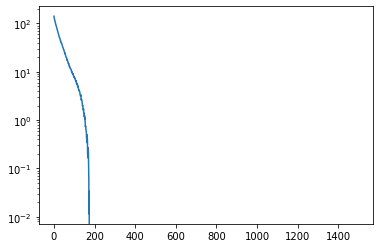

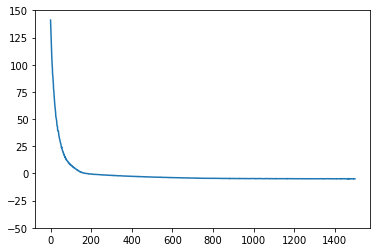


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=0.022857157074015814 and pval_i=3.7116473040101778e-06
0 and 2 are independent with pval_d=3.2395332305031177e-09 and pval_i=2.6326572350706975e-08
0 and 3 are DEPENDENT with pval_d=1.1129133396599062e-07 and pval_i=1.0036000747029792e-07
0 and 4 are independent with pval_d=0.09456115819484076 and pval_i=0.9783008831743247
1 and 2 are DEPENDENT with pval_d=0.03743364821076551 and pval_i=0.03184693691498143
1 and 3 are DEPENDENT with pval_d=2.694000578438431e-06 and pval_i=8.651214067790538e-07
1 and 4 are independent with pval_d=0.3876175810198571 and pval_i=0.987749027716551
2 and 3 are DEPENDENT with pval_d=0.00023604921786691372 and pval_i=3.010145767610532e-05
2 and 4 are independent with pval_d=0.09504192371147316 and pval_i=0.5313928635231239
3 and 4 are independent with pval_d=0.033523817178803816 and pval_i=0.9826129100445279
1 3
3 3
0 2
2 2
4 0
parent list: [

  1%|          | 1/100 [00:02<03:33,  2.16s/it]

0 137.1511514186859


  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

1 128.77026036381721


  3%|▎         | 3/100 [00:06<03:29,  2.15s/it]

2 128.60523577034473


  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

3 128.67712664604187


  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

4 128.53230683505535


  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

5 128.46351212263107


  7%|▋         | 7/100 [00:15<03:19,  2.15s/it]

6 128.36391080915928


  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

7 128.35739248991013


  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

8 128.20674446225166


 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

9 128.16309736669064


 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

10 128.22321218252182


 12%|█▏        | 12/100 [00:25<03:08,  2.15s/it]

11 128.1242066770792


 13%|█▎        | 13/100 [00:27<03:07,  2.15s/it]

12 128.08607046306133


 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

13 128.09945833683014


 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

14 127.98530261218548


 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

15 128.07057413458824


 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

16 128.0177151709795


 18%|█▊        | 18/100 [00:38<02:56,  2.16s/it]

17 128.01035299897194


 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

18 127.9370774179697


 20%|██        | 20/100 [00:43<02:52,  2.15s/it]

19 127.99099785089493


 21%|██        | 21/100 [00:45<02:50,  2.16s/it]

20 127.93524645268917


 22%|██▏       | 22/100 [00:47<02:48,  2.16s/it]

21 127.91538807749748


 23%|██▎       | 23/100 [00:49<02:46,  2.17s/it]

22 127.89444586634636


 24%|██▍       | 24/100 [00:51<02:44,  2.17s/it]

23 127.97776132822037


 25%|██▌       | 25/100 [00:53<02:42,  2.17s/it]

24 127.88934925198555


 26%|██▌       | 26/100 [00:56<02:40,  2.16s/it]

25 127.8678622096777


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 127.86773942410946


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 127.88545103371143


 29%|██▉       | 29/100 [01:02<02:33,  2.16s/it]

28 127.91042046248913


 30%|███       | 30/100 [01:04<02:31,  2.17s/it]

29 127.84464937448502


 31%|███       | 31/100 [01:06<02:30,  2.18s/it]

30 127.91523323953152


 32%|███▏      | 32/100 [01:09<02:28,  2.18s/it]

31 127.83785420656204


 33%|███▎      | 33/100 [01:11<02:25,  2.17s/it]

32 127.88692083954811


 34%|███▍      | 34/100 [01:13<02:23,  2.17s/it]

33 127.86969627439976


 35%|███▌      | 35/100 [01:15<02:20,  2.17s/it]

34 127.87134522199631


 36%|███▌      | 36/100 [01:17<02:18,  2.16s/it]

35 127.8020840883255


 37%|███▋      | 37/100 [01:19<02:15,  2.16s/it]

36 127.83782640099525


 38%|███▊      | 38/100 [01:22<02:14,  2.16s/it]

37 127.78341476619244


 39%|███▉      | 39/100 [01:24<02:12,  2.17s/it]

38 127.82606816291809


 40%|████      | 40/100 [01:26<02:09,  2.17s/it]

39 127.83201842010021


 41%|████      | 41/100 [01:28<02:07,  2.16s/it]

40 127.76844681799412


 42%|████▏     | 42/100 [01:30<02:05,  2.17s/it]

41 127.87331479787827


 43%|████▎     | 43/100 [01:32<02:03,  2.17s/it]

42 127.78073686361313


 44%|████▍     | 44/100 [01:35<02:02,  2.18s/it]

43 127.7798573821783


 45%|████▌     | 45/100 [01:37<02:00,  2.19s/it]

44 127.7382687330246


 46%|████▌     | 46/100 [01:39<01:57,  2.18s/it]

45 127.76518341898918


 47%|████▋     | 47/100 [01:41<01:55,  2.18s/it]

46 127.73293247818947


 48%|████▊     | 48/100 [01:43<01:54,  2.19s/it]

47 127.70133043825626


 49%|████▉     | 49/100 [01:46<01:51,  2.19s/it]

48 127.7826176583767


 50%|█████     | 50/100 [01:48<01:49,  2.18s/it]

49 127.78814479708672


 51%|█████     | 51/100 [01:50<01:46,  2.18s/it]

50 127.81750173866749


 52%|█████▏    | 52/100 [01:52<01:44,  2.18s/it]

51 127.75903640687466


 53%|█████▎    | 53/100 [01:54<01:42,  2.17s/it]

52 127.76692245900631


 54%|█████▍    | 54/100 [01:56<01:39,  2.17s/it]

53 127.74379152059555


 55%|█████▌    | 55/100 [01:59<01:37,  2.16s/it]

54 127.76378928124905


 56%|█████▌    | 56/100 [02:01<01:35,  2.17s/it]

55 127.73520289361477


 57%|█████▋    | 57/100 [02:03<01:33,  2.17s/it]

56 127.7298097461462


 58%|█████▊    | 58/100 [02:05<01:31,  2.17s/it]

57 127.76000295579433


 59%|█████▉    | 59/100 [02:07<01:29,  2.17s/it]

58 127.78554275631905


 60%|██████    | 60/100 [02:09<01:27,  2.18s/it]

59 127.69930747151375


 61%|██████    | 61/100 [02:12<01:24,  2.17s/it]

60 127.78921611607075


 62%|██████▏   | 62/100 [02:14<01:22,  2.17s/it]

61 127.70046515762806


 63%|██████▎   | 63/100 [02:16<01:20,  2.16s/it]

62 127.68350799381733


 64%|██████▍   | 64/100 [02:18<01:17,  2.16s/it]

63 127.73106506466866


 65%|██████▌   | 65/100 [02:20<01:15,  2.17s/it]

64 127.76392278075218


 66%|██████▌   | 66/100 [02:22<01:13,  2.17s/it]

65 127.73285026848316


 67%|██████▋   | 67/100 [02:25<01:11,  2.18s/it]

66 127.6962995827198


 68%|██████▊   | 68/100 [02:27<01:09,  2.18s/it]

67 127.780029758811


 69%|██████▉   | 69/100 [02:29<01:07,  2.17s/it]

68 127.70585229992867


 70%|███████   | 70/100 [02:31<01:04,  2.16s/it]

69 127.69954225420952


 71%|███████   | 71/100 [02:33<01:02,  2.16s/it]

70 127.73126442730427


 72%|███████▏  | 72/100 [02:35<01:00,  2.17s/it]

71 127.71858082711697


 73%|███████▎  | 73/100 [02:38<00:58,  2.17s/it]

72 127.69397078454494


 74%|███████▍  | 74/100 [02:40<00:56,  2.17s/it]

73 127.72765031456947


 75%|███████▌  | 75/100 [02:42<00:54,  2.16s/it]

74 127.68331623077393


 76%|███████▌  | 76/100 [02:44<00:51,  2.16s/it]

75 127.75593967735767


 77%|███████▋  | 77/100 [02:46<00:49,  2.16s/it]

76 127.67576643824577


 78%|███████▊  | 78/100 [02:48<00:47,  2.17s/it]

77 127.74688997864723


 79%|███████▉  | 79/100 [02:51<00:45,  2.16s/it]

78 127.66889157891273


 80%|████████  | 80/100 [02:53<00:43,  2.16s/it]

79 127.70489372313023


 81%|████████  | 81/100 [02:55<00:41,  2.17s/it]

80 127.68408143520355


 82%|████████▏ | 82/100 [02:57<00:39,  2.17s/it]

81 127.7084686756134


 83%|████████▎ | 83/100 [02:59<00:36,  2.17s/it]

82 127.66431891918182


 84%|████████▍ | 84/100 [03:01<00:34,  2.16s/it]

83 127.7181121557951


 85%|████████▌ | 85/100 [03:04<00:32,  2.17s/it]

84 127.7263371348381


 86%|████████▌ | 86/100 [03:06<00:30,  2.17s/it]

85 127.71585302054882


 87%|████████▋ | 87/100 [03:08<00:28,  2.17s/it]

86 127.69616164267063


 88%|████████▊ | 88/100 [03:10<00:26,  2.17s/it]

87 127.70172269642353


 89%|████████▉ | 89/100 [03:12<00:23,  2.16s/it]

88 127.71282348036766


 90%|█████████ | 90/100 [03:14<00:21,  2.16s/it]

89 127.70466893911362


 91%|█████████ | 91/100 [03:17<00:19,  2.16s/it]

90 127.65969228744507


 92%|█████████▏| 92/100 [03:19<00:17,  2.16s/it]

91 127.69634629786015


 93%|█████████▎| 93/100 [03:21<00:15,  2.17s/it]

92 127.73358738422394


 94%|█████████▍| 94/100 [03:23<00:12,  2.16s/it]

93 127.69318927824497


 95%|█████████▌| 95/100 [03:25<00:10,  2.16s/it]

94 127.71601428091526


 96%|█████████▌| 96/100 [03:27<00:08,  2.17s/it]

95 127.68873678147793


 97%|█████████▋| 97/100 [03:30<00:06,  2.16s/it]

96 127.70113453269005


 98%|█████████▊| 98/100 [03:32<00:04,  2.16s/it]

97 127.64574173092842


 99%|█████████▉| 99/100 [03:34<00:02,  2.16s/it]

98 127.69854451715946


100%|██████████| 100/100 [03:36<00:00,  2.17s/it]

99 127.69331130385399

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07487916201353073	

epoch 9000/10000, policy loss 0.04550468549132347	
***** test student *****
epoch 0/100 return: 25.0
epoch 1/100 return: 25.0
epoch 2/100 return: 21.0
epoch 3/100 return: 24.0
epoch 4/100 return: 28.0
epoch 5/100 return: 18.0
epoch 6/100 return: 26.0
epoch 7/100 return: 19.0
epoch 8/100 return: 23.0
epoch 9/100 return: 21.0
epoch 10/100 return: 17.0
epoch 11/100 return: 27.0
epoch 12/100 return: 24.0
epoch 13/100 return: 18.0
epoch 14/100 return: 30.0
epoch 15/100 return: 18.0
epoch 16/100 return: 24.0
epoch 17/100 return: 26.0
epoch 18/100 return: 19.0
epoch 19/100 return: 23.0
epoch 20/100 return: 27.0
epoch 21/100 return: 23.0
epoch 22/100 return: 21.0
epoch 23/100 return: 27.0
epoch 24/100 return: 26.0
epoch 25/100 return: 25.0
epoch 26/100 return: 24.0
epoch 27/100 return: 21.0
epoch 28/100 return: 20.0
epoch 29/100 return: 24.0
epoch 30/100 return: 23.0
epoch 31/100 return: 25.0
epoch 32/100 return: 28.0
epoch 33/100 return: 25.0
epoch 34/100 return: 27.0
epoch 35/100 return: 19.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -5.077497959136963best loss model loaded, stored at update # 1460


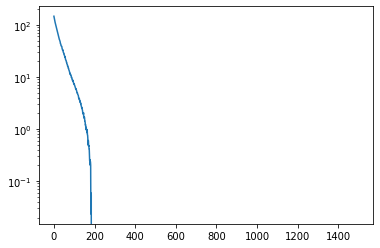

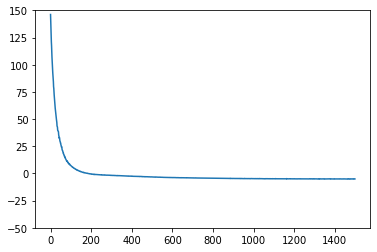


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.08856832943159791 and pval_i=0.961419907242277
0 and 2 are independent with pval_d=3.6367704810724857e-09 and pval_i=7.707223101555954e-09
0 and 3 are independent with pval_d=1.1408581433114498e-07 and pval_i=1.5589276040754708e-07
0 and 4 are DEPENDENT with pval_d=0.00019189636756351838 and pval_i=4.835022372872493e-06
1 and 2 are independent with pval_d=1.392526989223676e-07 and pval_i=1.4048816275344193e-07
1 and 3 are independent with pval_d=0.001397533560836919 and pval_i=0.0033199342707717796
1 and 4 are independent with pval_d=0.0028592724278823827 and pval_i=0.45761070805997867
2 and 3 are independent with pval_d=3.1068813969484995e-08 and pval_i=1.8619301888405766e-06
2 and 4 are independent with pval_d=1.4031993117171826e-05 and pval_i=0.0001894833032370125
3 and 4 are DEPENDENT with pval_d=1.816101391779104e-07 and pval_i=8.284304007209563e-08
4 2
0 1
3

  1%|          | 1/100 [00:02<03:31,  2.14s/it]

0 120.7908826470375


  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

1 113.64663298428059


  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

2 113.59744291007519


  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

3 113.6224359869957


  5%|▌         | 5/100 [00:10<03:24,  2.16s/it]

4 113.47167328000069


  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

5 113.41047585010529


  7%|▋         | 7/100 [00:15<03:21,  2.16s/it]

6 113.33736814558506


  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

7 113.46284472942352


  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

8 113.26808068156242


 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

9 113.14332953095436


 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

10 113.18776643276215


 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

11 113.1088538467884


 13%|█▎        | 13/100 [00:27<03:06,  2.15s/it]

12 113.16348677873611


 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

13 112.99459959566593


 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

14 112.94475799798965


 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

15 113.03296668827534


 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

16 112.93547090888023


 18%|█▊        | 18/100 [00:38<02:56,  2.16s/it]

17 112.98515136539936


 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

18 112.93154466152191


 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

19 112.94771106541157


 21%|██        | 21/100 [00:45<02:50,  2.16s/it]

20 112.88222183287144


 22%|██▏       | 22/100 [00:47<02:48,  2.16s/it]

21 112.97982783615589


 23%|██▎       | 23/100 [00:49<02:46,  2.16s/it]

22 112.91735643148422


 24%|██▍       | 24/100 [00:51<02:44,  2.16s/it]

23 112.92851109802723


 25%|██▌       | 25/100 [00:53<02:41,  2.15s/it]

24 112.90002398192883


 26%|██▌       | 26/100 [00:56<02:39,  2.16s/it]

25 112.8985290825367


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 112.88387759029865


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 112.86031892895699


 29%|██▉       | 29/100 [01:02<02:32,  2.15s/it]

28 112.87542632222176


 30%|███       | 30/100 [01:04<02:30,  2.14s/it]

29 112.81766882538795


 31%|███       | 31/100 [01:06<02:28,  2.15s/it]

30 112.89985024929047


 32%|███▏      | 32/100 [01:08<02:26,  2.15s/it]

31 112.80383031070232


 33%|███▎      | 33/100 [01:11<02:24,  2.16s/it]

32 112.81650938093662


 34%|███▍      | 34/100 [01:13<02:22,  2.16s/it]

33 112.88961111009121


 35%|███▌      | 35/100 [01:15<02:19,  2.15s/it]

34 112.82776817679405


 36%|███▌      | 36/100 [01:17<02:17,  2.15s/it]

35 112.77668406069279


 37%|███▋      | 37/100 [01:19<02:15,  2.15s/it]

36 112.83496406674385


 38%|███▊      | 38/100 [01:21<02:12,  2.14s/it]

37 112.80055844783783


 39%|███▉      | 39/100 [01:24<02:11,  2.15s/it]

38 112.83455181121826


 40%|████      | 40/100 [01:26<02:08,  2.15s/it]

39 112.85515712201595


 41%|████      | 41/100 [01:28<02:07,  2.15s/it]

40 112.77043487131596


 42%|████▏     | 42/100 [01:30<02:04,  2.15s/it]

41 112.84003016352654


 43%|████▎     | 43/100 [01:32<02:02,  2.16s/it]

42 112.78776131570339


 44%|████▍     | 44/100 [01:34<02:00,  2.15s/it]

43 112.80574916303158


 45%|████▌     | 45/100 [01:36<01:58,  2.16s/it]

44 112.80802641808987


 46%|████▌     | 46/100 [01:39<01:56,  2.16s/it]

45 112.817178145051


 47%|████▋     | 47/100 [01:41<01:54,  2.17s/it]

46 112.76724842190742


 48%|████▊     | 48/100 [01:43<01:52,  2.17s/it]

47 112.71976071596146


 49%|████▉     | 49/100 [01:45<01:50,  2.17s/it]

48 112.79876548051834


 50%|█████     | 50/100 [01:47<01:47,  2.15s/it]

49 112.80799458920956


 51%|█████     | 51/100 [01:49<01:45,  2.15s/it]

50 112.82806423306465


 52%|█████▏    | 52/100 [01:52<01:43,  2.16s/it]

51 112.79974211752415


 53%|█████▎    | 53/100 [01:54<01:41,  2.16s/it]

52 112.79064796864986


 54%|█████▍    | 54/100 [01:56<01:38,  2.15s/it]

53 112.7775162011385


 55%|█████▌    | 55/100 [01:58<01:36,  2.15s/it]

54 112.77993452548981


 56%|█████▌    | 56/100 [02:00<01:34,  2.14s/it]

55 112.75276632606983


 57%|█████▋    | 57/100 [02:02<01:32,  2.15s/it]

56 112.73823550343513


 58%|█████▊    | 58/100 [02:04<01:30,  2.15s/it]

57 112.78335431218147


 59%|█████▉    | 59/100 [02:07<01:28,  2.15s/it]

58 112.80722518265247


 60%|██████    | 60/100 [02:09<01:26,  2.16s/it]

59 112.733557254076


 61%|██████    | 61/100 [02:11<01:23,  2.15s/it]

60 112.78487658500671


 62%|██████▏   | 62/100 [02:13<01:22,  2.16s/it]

61 112.77909807860851


 63%|██████▎   | 63/100 [02:15<01:20,  2.17s/it]

62 112.7173973172903


 64%|██████▍   | 64/100 [02:17<01:17,  2.16s/it]

63 112.76395399868488


 65%|██████▌   | 65/100 [02:20<01:15,  2.16s/it]

64 112.74060900509357


 66%|██████▌   | 66/100 [02:22<01:13,  2.17s/it]

65 112.74997864663601


 67%|██████▋   | 67/100 [02:24<01:10,  2.15s/it]

66 112.75618715584278


 68%|██████▊   | 68/100 [02:26<01:08,  2.14s/it]

67 112.8099303394556


 69%|██████▉   | 69/100 [02:28<01:06,  2.15s/it]

68 112.77426573634148


 70%|███████   | 70/100 [02:30<01:04,  2.15s/it]

69 112.75832319259644


 71%|███████   | 71/100 [02:32<01:02,  2.15s/it]

70 112.74024431407452


 72%|███████▏  | 72/100 [02:35<01:00,  2.15s/it]

71 112.73059898614883


 73%|███████▎  | 73/100 [02:37<00:58,  2.16s/it]

72 112.81541320681572


 74%|███████▍  | 74/100 [02:39<00:56,  2.16s/it]

73 112.71661376953125


 75%|███████▌  | 75/100 [02:41<00:54,  2.16s/it]

74 112.73694682121277


 76%|███████▌  | 76/100 [02:43<00:51,  2.17s/it]

75 112.76419131457806


 77%|███████▋  | 77/100 [02:45<00:49,  2.16s/it]

76 112.71391014754772


 78%|███████▊  | 78/100 [02:48<00:47,  2.16s/it]

77 112.8112063407898


 79%|███████▉  | 79/100 [02:50<00:45,  2.15s/it]

78 112.70750227570534


 80%|████████  | 80/100 [02:52<00:42,  2.15s/it]

79 112.75218106806278


 81%|████████  | 81/100 [02:54<00:40,  2.15s/it]

80 112.71260830760002


 82%|████████▏ | 82/100 [02:56<00:38,  2.15s/it]

81 112.75164587795734


 83%|████████▎ | 83/100 [02:58<00:36,  2.15s/it]

82 112.69420173764229


 84%|████████▍ | 84/100 [03:00<00:34,  2.16s/it]

83 112.77765163779259


 85%|████████▌ | 85/100 [03:03<00:32,  2.17s/it]

84 112.74090702831745


 86%|████████▌ | 86/100 [03:05<00:30,  2.16s/it]

85 112.78518371284008


 87%|████████▋ | 87/100 [03:07<00:28,  2.15s/it]

86 112.7283871024847


 88%|████████▊ | 88/100 [03:09<00:25,  2.15s/it]

87 112.7610532939434


 89%|████████▉ | 89/100 [03:11<00:23,  2.15s/it]

88 112.72036802768707


 90%|█████████ | 90/100 [03:13<00:21,  2.14s/it]

89 112.77059699594975


 91%|█████████ | 91/100 [03:16<00:19,  2.15s/it]

90 112.6994900405407


 92%|█████████▏| 92/100 [03:18<00:17,  2.15s/it]

91 112.77037337422371


 93%|█████████▎| 93/100 [03:20<00:15,  2.15s/it]

92 112.78108070790768


 94%|█████████▍| 94/100 [03:22<00:12,  2.15s/it]

93 112.74032996594906


 95%|█████████▌| 95/100 [03:24<00:10,  2.15s/it]

94 112.73576380312443


 96%|█████████▌| 96/100 [03:26<00:08,  2.14s/it]

95 112.73922643065453


 97%|█████████▋| 97/100 [03:28<00:06,  2.14s/it]

96 112.76816047728062


 98%|█████████▊| 98/100 [03:31<00:04,  2.14s/it]

97 112.71234399080276


 99%|█████████▉| 99/100 [03:33<00:02,  2.15s/it]

98 112.73181495070457


100%|██████████| 100/100 [03:35<00:00,  2.15s/it]

99 112.72054915130138

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07705055177211761	

epoch 9000/10000, policy loss 0.047095369547605515	
***** test student *****
epoch 0/100 return: 13.0
epoch 1/100 return: 13.0
epoch 2/100 return: 13.0
epoch 3/100 return: 18.0
epoch 4/100 return: 17.0
epoch 5/100 return: 17.0
epoch 6/100 return: 20.0
epoch 7/100 return: 17.0
epoch 8/100 return: 19.0
epoch 9/100 return: 19.0
epoch 10/100 return: 19.0
epoch 11/100 return: 19.0
epoch 12/100 return: 14.0
epoch 13/100 return: 14.0
epoch 14/100 return: 15.0
epoch 15/100 return: 16.0
epoch 16/100 return: 17.0
epoch 17/100 return: 17.0
epoch 18/100 return: 20.0
epoch 19/100 return: 19.0
epoch 20/100 return: 14.0
epoch 21/100 return: 19.0
epoch 22/100 return: 19.0
epoch 23/100 return: 21.0
epoch 24/100 return: 16.0
epoch 25/100 return: 16.0
epoch 26/100 return: 16.0
epoch 27/100 return: 20.0
epoch 28/100 return: 18.0
epoch 29/100 return: 16.0
epoch 30/100 return: 15.0
epoch 31/100 return: 18.0
epoch 32/100 return: 17.0
epoch 33/100 return: 17.0
epoch 34/100 return: 17.0
epoch 35/100 return: 13

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -5.045992374420166best loss model loaded, stored at update # 1491


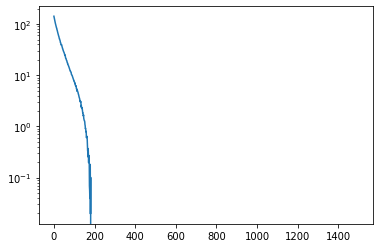

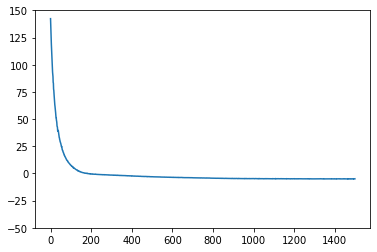


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=0.009078498604084695 and pval_i=7.738119501878582e-06
0 and 2 are independent with pval_d=1.3064879334117186e-08 and pval_i=8.39424361375925e-08
0 and 3 are DEPENDENT with pval_d=1.2478705920542757e-06 and pval_i=2.414920679341346e-07
0 and 4 are independent with pval_d=0.004632996313076855 and pval_i=0.19938579926620703
1 and 2 are independent with pval_d=4.971468354796036e-06 and pval_i=0.011516337982897184
1 and 3 are independent with pval_d=1.4691125342930466e-05 and pval_i=3.23192185140609e-05
1 and 4 are independent with pval_d=0.03858469885999986 and pval_i=0.9978386741507659
2 and 3 are independent with pval_d=4.055706167932109e-05 and pval_i=0.00032388061011731325
2 and 4 are independent with pval_d=0.01480084869064916 and pval_i=0.499268589306021
3 and 4 are independent with pval_d=0.028611471442688954 and pval_i=0.8780444775835357
0 2
1 1
3 1
2 0
4 0
parent

  1%|          | 1/100 [00:02<03:31,  2.13s/it]

0 131.45278416574


  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

1 123.75696082413197


  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

2 123.64212669432163


  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

3 123.69705811142921


  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

4 123.53327585756779


  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

5 123.52630688250065


  7%|▋         | 7/100 [00:15<03:21,  2.16s/it]

6 123.35289508104324


  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

7 123.37436024844646


  9%|▉         | 9/100 [00:19<03:15,  2.14s/it]

8 123.16597439348698


 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

9 123.16373121738434


 11%|█         | 11/100 [00:23<03:11,  2.16s/it]

10 123.2350377291441


 12%|█▏        | 12/100 [00:25<03:10,  2.16s/it]

11 123.13903351128101


 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

12 123.12478584051132


 14%|█▍        | 14/100 [00:30<03:06,  2.16s/it]

13 123.04650467634201


 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

14 122.99835380911827


 16%|█▌        | 16/100 [00:34<03:01,  2.17s/it]

15 123.09854409098625


 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

16 123.01641555130482


 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

17 123.0693803280592


 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

18 122.98679429292679


 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

19 123.00007158517838


 21%|██        | 21/100 [00:45<02:50,  2.16s/it]

20 122.91188582777977


 22%|██▏       | 22/100 [00:47<02:48,  2.16s/it]

21 122.9699672460556


 23%|██▎       | 23/100 [00:49<02:46,  2.16s/it]

22 122.95617853105068


 24%|██▍       | 24/100 [00:51<02:44,  2.17s/it]

23 122.99980102479458


 25%|██▌       | 25/100 [00:53<02:42,  2.17s/it]

24 122.92582796514034


 26%|██▌       | 26/100 [00:56<02:39,  2.16s/it]

25 122.9099422544241


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 122.93734174966812


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 122.91541948914528


 29%|██▉       | 29/100 [01:02<02:33,  2.16s/it]

28 122.93666039407253


 30%|███       | 30/100 [01:04<02:31,  2.16s/it]

29 122.8656540364027


 31%|███       | 31/100 [01:06<02:28,  2.16s/it]

30 122.90465125441551


 32%|███▏      | 32/100 [01:09<02:26,  2.15s/it]

31 122.8754544109106


 33%|███▎      | 33/100 [01:11<02:24,  2.16s/it]

32 122.91780868172646


 34%|███▍      | 34/100 [01:13<02:22,  2.16s/it]

33 122.89397892355919


 35%|███▌      | 35/100 [01:15<02:20,  2.16s/it]

34 122.87471480667591


 36%|███▌      | 36/100 [01:17<02:18,  2.17s/it]

35 122.83042988181114


 37%|███▋      | 37/100 [01:19<02:16,  2.16s/it]

36 122.82754428684711


 38%|███▊      | 38/100 [01:22<02:14,  2.16s/it]

37 122.8471400141716


 39%|███▉      | 39/100 [01:24<02:12,  2.17s/it]

38 122.84274019300938


 40%|████      | 40/100 [01:26<02:10,  2.17s/it]

39 122.87517823278904


 41%|████      | 41/100 [01:28<02:08,  2.17s/it]

40 122.81872053444386


 42%|████▏     | 42/100 [01:30<02:06,  2.18s/it]

41 122.86047817766666


 43%|████▎     | 43/100 [01:32<02:03,  2.16s/it]

42 122.82630477845669


 44%|████▍     | 44/100 [01:35<02:02,  2.18s/it]

43 122.83223485946655


 45%|████▌     | 45/100 [01:37<02:00,  2.18s/it]

44 122.79835560917854


 46%|████▌     | 46/100 [01:39<01:57,  2.18s/it]

45 122.84938982129097


 47%|████▋     | 47/100 [01:41<01:55,  2.18s/it]

46 122.80199760198593


 48%|████▊     | 48/100 [01:43<01:53,  2.18s/it]

47 122.7647433578968


 49%|████▉     | 49/100 [01:46<01:51,  2.19s/it]

48 122.80006763339043


 50%|█████     | 50/100 [01:48<01:49,  2.19s/it]

49 122.82944251596928


 51%|█████     | 51/100 [01:50<01:46,  2.17s/it]

50 122.8435541242361


 52%|█████▏    | 52/100 [01:52<01:43,  2.16s/it]

51 122.8359393030405


 53%|█████▎    | 53/100 [01:54<01:41,  2.15s/it]

52 122.77866216003895


 54%|█████▍    | 54/100 [01:56<01:39,  2.17s/it]

53 122.80372647941113


 55%|█████▌    | 55/100 [01:59<01:37,  2.17s/it]

54 122.81267075240612


 56%|█████▌    | 56/100 [02:01<01:35,  2.17s/it]

55 122.8043509721756


 57%|█████▋    | 57/100 [02:03<01:33,  2.17s/it]

56 122.78692290186882


 58%|█████▊    | 58/100 [02:05<01:30,  2.15s/it]

57 122.81229393184185


 59%|█████▉    | 59/100 [02:07<01:27,  2.15s/it]

58 122.82799662649632


 60%|██████    | 60/100 [02:09<01:25,  2.14s/it]

59 122.75665806233883


 61%|██████    | 61/100 [02:11<01:23,  2.15s/it]

60 122.81968241930008


 62%|██████▏   | 62/100 [02:14<01:21,  2.15s/it]

61 122.76566158235073


 63%|██████▎   | 63/100 [02:16<01:19,  2.16s/it]

62 122.72237680852413


 64%|██████▍   | 64/100 [02:18<01:17,  2.16s/it]

63 122.80639904737473


 65%|██████▌   | 65/100 [02:20<01:15,  2.16s/it]

64 122.78020446002483


 66%|██████▌   | 66/100 [02:22<01:13,  2.16s/it]

65 122.79139126837254


 67%|██████▋   | 67/100 [02:24<01:11,  2.16s/it]

66 122.78372129797935


 68%|██████▊   | 68/100 [02:27<01:08,  2.16s/it]

67 122.81806956231594


 69%|██████▉   | 69/100 [02:29<01:07,  2.16s/it]

68 122.75722116231918


 70%|███████   | 70/100 [02:31<01:04,  2.16s/it]

69 122.76889650523663


 71%|███████   | 71/100 [02:33<01:02,  2.16s/it]

70 122.76657484471798


 72%|███████▏  | 72/100 [02:35<01:00,  2.17s/it]

71 122.74708469212055


 73%|███████▎  | 73/100 [02:37<00:58,  2.18s/it]

72 122.79152417182922


 74%|███████▍  | 74/100 [02:40<00:56,  2.17s/it]

73 122.78822895884514


 75%|███████▌  | 75/100 [02:42<00:54,  2.17s/it]

74 122.75859394669533


 76%|███████▌  | 76/100 [02:44<00:51,  2.16s/it]

75 122.83138366043568


 77%|███████▋  | 77/100 [02:46<00:49,  2.17s/it]

76 122.74047636985779


 78%|███████▊  | 78/100 [02:48<00:47,  2.18s/it]

77 122.80347633361816


 79%|███████▉  | 79/100 [02:50<00:45,  2.17s/it]

78 122.76759573817253


 80%|████████  | 80/100 [02:53<00:43,  2.17s/it]

79 122.75601038336754


 81%|████████  | 81/100 [02:55<00:41,  2.17s/it]

80 122.76547110080719


 82%|████████▏ | 82/100 [02:57<00:38,  2.16s/it]

81 122.7743189483881


 83%|████████▎ | 83/100 [02:59<00:36,  2.16s/it]

82 122.7080006301403


 84%|████████▍ | 84/100 [03:01<00:34,  2.16s/it]

83 122.8045901954174


 85%|████████▌ | 85/100 [03:03<00:32,  2.16s/it]

84 122.74688628315926


 86%|████████▌ | 86/100 [03:06<00:30,  2.17s/it]

85 122.78996308147907


 87%|████████▋ | 87/100 [03:08<00:28,  2.17s/it]

86 122.74276837706566


 88%|████████▊ | 88/100 [03:10<00:26,  2.17s/it]

87 122.75890323519707


 89%|████████▉ | 89/100 [03:12<00:23,  2.17s/it]

88 122.71879288554192


 90%|█████████ | 90/100 [03:14<00:21,  2.18s/it]

89 122.76962430775166


 91%|█████████ | 91/100 [03:16<00:19,  2.17s/it]

90 122.72914844751358


 92%|█████████▏| 92/100 [03:19<00:17,  2.17s/it]

91 122.78099676966667


 93%|█████████▎| 93/100 [03:21<00:15,  2.18s/it]

92 122.74518251419067


 94%|█████████▍| 94/100 [03:23<00:13,  2.17s/it]

93 122.78602288663387


 95%|█████████▌| 95/100 [03:25<00:10,  2.17s/it]

94 122.75173652172089


 96%|█████████▌| 96/100 [03:27<00:08,  2.16s/it]

95 122.74956534802914


 97%|█████████▋| 97/100 [03:29<00:06,  2.16s/it]

96 122.80336038768291


 98%|█████████▊| 98/100 [03:32<00:04,  2.16s/it]

97 122.71494440734386


 99%|█████████▉| 99/100 [03:34<00:02,  2.16s/it]

98 122.74982810020447


100%|██████████| 100/100 [03:36<00:00,  2.16s/it]

99 122.75531730055809

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07579682022333145	

epoch 9000/10000, policy loss 0.04981295391917229	
***** test student *****
epoch 0/100 return: 35.0
epoch 1/100 return: 27.0
epoch 2/100 return: 27.0
epoch 3/100 return: 29.0
epoch 4/100 return: 33.0
epoch 5/100 return: 33.0
epoch 6/100 return: 26.0
epoch 7/100 return: 37.0
epoch 8/100 return: 35.0
epoch 9/100 return: 23.0
epoch 10/100 return: 27.0
epoch 11/100 return: 23.0
epoch 12/100 return: 31.0
epoch 13/100 return: 30.0
epoch 14/100 return: 35.0
epoch 15/100 return: 31.0
epoch 16/100 return: 23.0
epoch 17/100 return: 24.0
epoch 18/100 return: 33.0
epoch 19/100 return: 35.0
epoch 20/100 return: 26.0
epoch 21/100 return: 29.0
epoch 22/100 return: 34.0
epoch 23/100 return: 31.0
epoch 24/100 return: 22.0
epoch 25/100 return: 31.0
epoch 26/100 return: 21.0
epoch 27/100 return: 23.0
epoch 28/100 return: 32.0
epoch 29/100 return: 35.0
epoch 30/100 return: 33.0
epoch 31/100 return: 26.0
epoch 32/100 return: 35.0
epoch 33/100 return: 32.0
epoch 34/100 return: 33.0
epoch 35/100 return: 28.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.9200544357299805best loss model loaded, stored at update # 1490


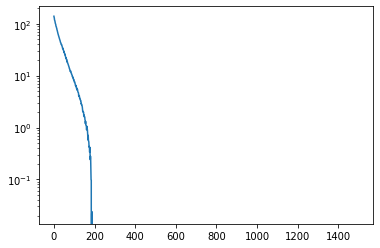

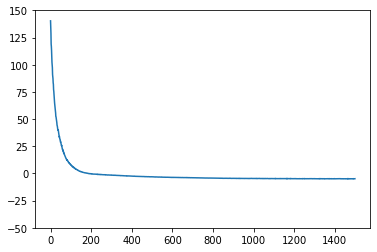


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.07347004480327439 and pval_i=0.9948525168982592
0 and 2 are independent with pval_d=4.139374922117833e-09 and pval_i=4.905177975137738e-08
0 and 3 are DEPENDENT with pval_d=3.315684986500726e-06 and pval_i=9.206762159707589e-07
0 and 4 are DEPENDENT with pval_d=0.00022072126593292282 and pval_i=4.2700735482271944e-07
1 and 2 are DEPENDENT with pval_d=1.7866907480240882e-07 and pval_i=1.1380259427135278e-08
1 and 3 are independent with pval_d=0.042930863975311054 and pval_i=0.9433429596963595
1 and 4 are independent with pval_d=0.0022520373102060177 and pval_i=0.3641862006607652
2 and 3 are independent with pval_d=1.8474029591199665e-06 and pval_i=3.0630492343327974e-06
2 and 4 are DEPENDENT with pval_d=0.00021425461852705576 and pval_i=7.98976343090275e-07
3 and 4 are DEPENDENT with pval_d=9.245582197892632e-06 and pval_i=5.764305578439853e-07
4 3
0 2
2 2
3 2
1 1


  1%|          | 1/100 [00:02<03:31,  2.14s/it]

0 130.24372386932373


  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

1 122.6324305087328


  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

2 122.6715278327465


  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

3 122.68068540096283


  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

4 122.4194602817297


  6%|▌         | 6/100 [00:12<03:22,  2.15s/it]

5 122.40132908523083


  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

6 122.26608970761299


  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

7 122.42236267030239


  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

8 122.20384515821934


 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

9 122.04876762628555


 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

10 122.21027038991451


 12%|█▏        | 12/100 [00:25<03:08,  2.15s/it]

11 122.09434522688389


 13%|█▎        | 13/100 [00:27<03:06,  2.15s/it]

12 122.0454643368721


 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

13 121.99087996780872


 15%|█▌        | 15/100 [00:32<03:03,  2.15s/it]

14 121.941904053092


 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

15 121.98896154761314


 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

16 121.94101917743683


 18%|█▊        | 18/100 [00:38<02:57,  2.17s/it]

17 121.94897004961967


 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

18 121.85442911088467


 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

19 121.93188644945621


 21%|██        | 21/100 [00:45<02:50,  2.16s/it]

20 121.82672989368439


 22%|██▏       | 22/100 [00:47<02:47,  2.15s/it]

21 121.90275228023529


 23%|██▎       | 23/100 [00:49<02:45,  2.15s/it]

22 121.8157602250576


 24%|██▍       | 24/100 [00:51<02:44,  2.16s/it]

23 121.87500433623791


 25%|██▌       | 25/100 [00:53<02:42,  2.17s/it]

24 121.84622286260128


 26%|██▌       | 26/100 [00:56<02:40,  2.17s/it]

25 121.83198656141758


 27%|██▋       | 27/100 [00:58<02:37,  2.15s/it]

26 121.84433284401894


 28%|██▊       | 28/100 [01:00<02:34,  2.15s/it]

27 121.84041291475296


 29%|██▉       | 29/100 [01:02<02:33,  2.16s/it]

28 121.83166283369064


 30%|███       | 30/100 [01:04<02:30,  2.15s/it]

29 121.74680383503437


 31%|███       | 31/100 [01:06<02:28,  2.15s/it]

30 121.84288869798183


 32%|███▏      | 32/100 [01:08<02:26,  2.15s/it]

31 121.79054851830006


 33%|███▎      | 33/100 [01:11<02:23,  2.14s/it]

32 121.80833123624325


 34%|███▍      | 34/100 [01:13<02:21,  2.14s/it]

33 121.83964309096336


 35%|███▌      | 35/100 [01:15<02:19,  2.15s/it]

34 121.79677399992943


 36%|███▌      | 36/100 [01:17<02:17,  2.15s/it]

35 121.75324614346027


 37%|███▋      | 37/100 [01:19<02:15,  2.15s/it]

36 121.80224257707596


 38%|███▊      | 38/100 [01:21<02:13,  2.16s/it]

37 121.77628657221794


 39%|███▉      | 39/100 [01:24<02:11,  2.16s/it]

38 121.81631217896938


 40%|████      | 40/100 [01:26<02:09,  2.16s/it]

39 121.81474938988686


 41%|████      | 41/100 [01:28<02:07,  2.17s/it]

40 121.72619211673737


 42%|████▏     | 42/100 [01:30<02:05,  2.17s/it]

41 121.80582773685455


 43%|████▎     | 43/100 [01:32<02:04,  2.18s/it]

42 121.77222467958927


 44%|████▍     | 44/100 [01:34<02:01,  2.17s/it]

43 121.74392268061638


 45%|████▌     | 45/100 [01:37<01:59,  2.16s/it]

44 121.7375351190567


 46%|████▌     | 46/100 [01:39<01:56,  2.16s/it]

45 121.77772170305252


 47%|████▋     | 47/100 [01:41<01:54,  2.17s/it]

46 121.704585775733


 48%|████▊     | 48/100 [01:43<01:52,  2.16s/it]

47 121.70528683066368


 49%|████▉     | 49/100 [01:45<01:50,  2.16s/it]

48 121.75592029094696


 50%|█████     | 50/100 [01:47<01:47,  2.16s/it]

49 121.76314325630665


 51%|█████     | 51/100 [01:49<01:45,  2.15s/it]

50 121.79948051273823


 52%|█████▏    | 52/100 [01:52<01:43,  2.16s/it]

51 121.72829648852348


 53%|█████▎    | 53/100 [01:54<01:41,  2.15s/it]

52 121.74793681502342


 54%|█████▍    | 54/100 [01:56<01:38,  2.15s/it]

53 121.70886081457138


 55%|█████▌    | 55/100 [01:58<01:36,  2.15s/it]

54 121.75687696039677


 56%|█████▌    | 56/100 [02:00<01:35,  2.16s/it]

55 121.72663675248623


 57%|█████▋    | 57/100 [02:02<01:32,  2.16s/it]

56 121.71778020262718


 58%|█████▊    | 58/100 [02:05<01:30,  2.16s/it]

57 121.73355826735497


 59%|█████▉    | 59/100 [02:07<01:28,  2.16s/it]

58 121.79107989370823


 60%|██████    | 60/100 [02:09<01:26,  2.16s/it]

59 121.6959847509861


 61%|██████    | 61/100 [02:11<01:24,  2.16s/it]

60 121.73842372000217


 62%|██████▏   | 62/100 [02:13<01:21,  2.15s/it]

61 121.72073076665401


 63%|██████▎   | 63/100 [02:15<01:19,  2.15s/it]

62 121.6876741796732


 64%|██████▍   | 64/100 [02:17<01:17,  2.15s/it]

63 121.71737562119961


 65%|██████▌   | 65/100 [02:20<01:15,  2.15s/it]

64 121.73192197084427


 66%|██████▌   | 66/100 [02:22<01:13,  2.15s/it]

65 121.73524163663387


 67%|██████▋   | 67/100 [02:24<01:11,  2.16s/it]

66 121.71666842699051


 68%|██████▊   | 68/100 [02:26<01:09,  2.16s/it]

67 121.75484193861485


 69%|██████▉   | 69/100 [02:28<01:06,  2.15s/it]

68 121.7222485691309


 70%|███████   | 70/100 [02:30<01:04,  2.16s/it]

69 121.71745666861534


 71%|███████   | 71/100 [02:33<01:02,  2.17s/it]

70 121.68783114850521


 72%|███████▏  | 72/100 [02:35<01:00,  2.17s/it]

71 121.75579443573952


 73%|███████▎  | 73/100 [02:37<00:58,  2.17s/it]

72 121.73239652812481


 74%|███████▍  | 74/100 [02:39<00:56,  2.17s/it]

73 121.74561676383018


 75%|███████▌  | 75/100 [02:41<00:53,  2.16s/it]

74 121.73533363640308


 76%|███████▌  | 76/100 [02:43<00:51,  2.16s/it]

75 121.73713733255863


 77%|███████▋  | 77/100 [02:46<00:49,  2.16s/it]

76 121.65368002653122


 78%|███████▊  | 78/100 [02:48<00:47,  2.15s/it]

77 121.77040402591228


 79%|███████▉  | 79/100 [02:50<00:45,  2.15s/it]

78 121.68918208777905


 80%|████████  | 80/100 [02:52<00:43,  2.16s/it]

79 121.68965251743793


 81%|████████  | 81/100 [02:54<00:41,  2.16s/it]

80 121.73663495481014


 82%|████████▏ | 82/100 [02:56<00:39,  2.17s/it]

81 121.73842500150204


 83%|████████▎ | 83/100 [02:59<00:36,  2.17s/it]

82 121.65509608387947


 84%|████████▍ | 84/100 [03:01<00:34,  2.16s/it]

83 121.73492236435413


 85%|████████▌ | 85/100 [03:03<00:32,  2.16s/it]

84 121.72173056006432


 86%|████████▌ | 86/100 [03:05<00:30,  2.16s/it]

85 121.7482705116272


 87%|████████▋ | 87/100 [03:07<00:28,  2.16s/it]

86 121.71336106956005


 88%|████████▊ | 88/100 [03:09<00:25,  2.16s/it]

87 121.69939263164997


 89%|████████▉ | 89/100 [03:11<00:23,  2.16s/it]

88 121.71092201769352


 90%|█████████ | 90/100 [03:14<00:21,  2.16s/it]

89 121.7510719448328


 91%|█████████ | 91/100 [03:16<00:19,  2.17s/it]

90 121.6614433825016


 92%|█████████▏| 92/100 [03:18<00:17,  2.16s/it]

91 121.70411142706871


 93%|█████████▎| 93/100 [03:20<00:15,  2.16s/it]

92 121.75028923153877


 94%|█████████▍| 94/100 [03:22<00:12,  2.15s/it]

93 121.739502876997


 95%|█████████▌| 95/100 [03:24<00:10,  2.15s/it]

94 121.70562885701656


 96%|█████████▌| 96/100 [03:27<00:08,  2.15s/it]

95 121.73585879802704


 97%|█████████▋| 97/100 [03:29<00:06,  2.15s/it]

96 121.74337415397167


 98%|█████████▊| 98/100 [03:31<00:04,  2.15s/it]

97 121.68478572368622


 99%|█████████▉| 99/100 [03:33<00:02,  2.16s/it]

98 121.70614401996136


100%|██████████| 100/100 [03:35<00:00,  2.16s/it]

99 121.6927550882101

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07762794941663742	

epoch 9000/10000, policy loss 0.045624684542417526	
***** test student *****
epoch 0/100 return: 19.0
epoch 1/100 return: 17.0
epoch 2/100 return: 18.0
epoch 3/100 return: 14.0
epoch 4/100 return: 17.0
epoch 5/100 return: 17.0
epoch 6/100 return: 15.0
epoch 7/100 return: 20.0
epoch 8/100 return: 22.0
epoch 9/100 return: 21.0
epoch 10/100 return: 18.0
epoch 11/100 return: 14.0
epoch 12/100 return: 17.0
epoch 13/100 return: 15.0
epoch 14/100 return: 14.0
epoch 15/100 return: 15.0
epoch 16/100 return: 15.0
epoch 17/100 return: 18.0
epoch 18/100 return: 17.0
epoch 19/100 return: 19.0
epoch 20/100 return: 19.0
epoch 21/100 return: 19.0
epoch 22/100 return: 19.0
epoch 23/100 return: 17.0
epoch 24/100 return: 15.0
epoch 25/100 return: 21.0
epoch 26/100 return: 18.0
epoch 27/100 return: 19.0
epoch 28/100 return: 15.0
epoch 29/100 return: 19.0
epoch 30/100 return: 15.0
epoch 31/100 return: 17.0
epoch 32/100 return: 19.0
epoch 33/100 return: 21.0
epoch 34/100 return: 17.0
epoch 35/100 return: 17

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.81809663772583best loss model loaded, stored at update # 1420


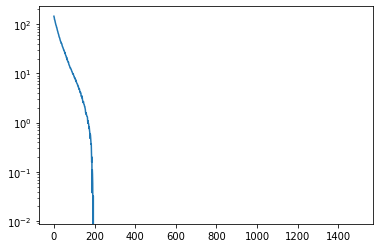

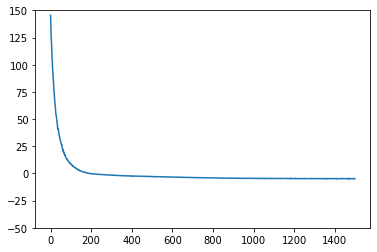


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=7.729309352832568e-05 and pval_i=3.0210491179394215e-07
0 and 2 are independent with pval_d=5.047852578576138e-09 and pval_i=1.6528891472018203e-08
0 and 3 are independent with pval_d=1.7358861037051423e-07 and pval_i=1.8121189795355407e-06
0 and 4 are independent with pval_d=0.0028886975028204814 and pval_i=0.7877725951642061
1 and 2 are independent with pval_d=0.0001652750174536586 and pval_i=0.0002910752920736489
1 and 3 are DEPENDENT with pval_d=3.2670550022841373e-06 and pval_i=2.657293979487244e-08
1 and 4 are independent with pval_d=0.03471485013487748 and pval_i=0.917124142165561
2 and 3 are DEPENDENT with pval_d=2.320913976975114e-05 and pval_i=1.3077267941452793e-05
2 and 4 are DEPENDENT with pval_d=0.7562725872997085 and pval_i=0.6366424645345945
3 and 4 are independent with pval_d=0.007841339319992237 and pval_i=0.02363949992691524
1 2
2 2
3 2
0 1
4 1
pare

  1%|          | 1/100 [00:02<03:29,  2.12s/it]

0 141.09752954542637


  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

1 132.622778698802


  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

2 132.4626830369234


  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

3 132.5240289568901


  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

4 132.29850694537163


  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

5 132.30267219245434


  7%|▋         | 7/100 [00:15<03:19,  2.15s/it]

6 132.12599597871304


  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

7 132.19532324373722


  9%|▉         | 9/100 [00:19<03:16,  2.15s/it]

8 132.0277578830719


 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

9 131.96038983762264


 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

10 132.00784294307232


 12%|█▏        | 12/100 [00:25<03:10,  2.16s/it]

11 131.94440373778343


 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

12 131.86625763773918


 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

13 131.82891055941582


 15%|█▌        | 15/100 [00:32<03:03,  2.15s/it]

14 131.77384814620018


 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

15 131.88248997926712


 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

16 131.735180914402


 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

17 131.79433737695217


 19%|█▉        | 19/100 [00:40<02:54,  2.15s/it]

18 131.72953574359417


 20%|██        | 20/100 [00:43<02:52,  2.15s/it]

19 131.7281066328287


 21%|██        | 21/100 [00:45<02:50,  2.16s/it]

20 131.68852756917477


 22%|██▏       | 22/100 [00:47<02:47,  2.15s/it]

21 131.72631579637527


 23%|██▎       | 23/100 [00:49<02:45,  2.15s/it]

22 131.67700004577637


 24%|██▍       | 24/100 [00:51<02:43,  2.15s/it]

23 131.76933272182941


 25%|██▌       | 25/100 [00:53<02:41,  2.15s/it]

24 131.66013745963573


 26%|██▌       | 26/100 [00:55<02:38,  2.15s/it]

25 131.63613122701645


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 131.70802673697472


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 131.6489263176918


 29%|██▉       | 29/100 [01:02<02:31,  2.14s/it]

28 131.69405283033848


 30%|███       | 30/100 [01:04<02:30,  2.15s/it]

29 131.61969642341137


 31%|███       | 31/100 [01:06<02:29,  2.16s/it]

30 131.66010043025017


 32%|███▏      | 32/100 [01:08<02:27,  2.16s/it]

31 131.6293443441391


 33%|███▎      | 33/100 [01:11<02:23,  2.15s/it]

32 131.66437916457653


 34%|███▍      | 34/100 [01:13<02:21,  2.15s/it]

33 131.63940031826496


 35%|███▌      | 35/100 [01:15<02:19,  2.15s/it]

34 131.64730371534824


 36%|███▌      | 36/100 [01:17<02:17,  2.15s/it]

35 131.60690957307816


 37%|███▋      | 37/100 [01:19<02:15,  2.14s/it]

36 131.60288271307945


 38%|███▊      | 38/100 [01:21<02:12,  2.14s/it]

37 131.59865206480026


 39%|███▉      | 39/100 [01:23<02:10,  2.14s/it]

38 131.62013921141624


 40%|████      | 40/100 [01:26<02:08,  2.14s/it]

39 131.62394589185715


 41%|████      | 41/100 [01:28<02:06,  2.15s/it]

40 131.57729817926884


 42%|████▏     | 42/100 [01:30<02:05,  2.16s/it]

41 131.67973639070988


 43%|████▎     | 43/100 [01:32<02:02,  2.15s/it]

42 131.57647992670536


 44%|████▍     | 44/100 [01:34<02:01,  2.16s/it]

43 131.5760812163353


 45%|████▌     | 45/100 [01:36<01:58,  2.16s/it]

44 131.55544479191303


 46%|████▌     | 46/100 [01:39<01:56,  2.16s/it]

45 131.59224937856197


 47%|████▋     | 47/100 [01:41<01:53,  2.15s/it]

46 131.57132998108864


 48%|████▊     | 48/100 [01:43<01:51,  2.15s/it]

47 131.51203629374504


 49%|████▉     | 49/100 [01:45<01:49,  2.15s/it]

48 131.57607559859753


 50%|█████     | 50/100 [01:47<01:47,  2.15s/it]

49 131.59983672201633


 51%|█████     | 51/100 [01:49<01:45,  2.15s/it]

50 131.6011916846037


 52%|█████▏    | 52/100 [01:51<01:43,  2.15s/it]

51 131.57761727273464


 53%|█████▎    | 53/100 [01:54<01:41,  2.15s/it]

52 131.57067796587944


 54%|█████▍    | 54/100 [01:56<01:39,  2.15s/it]

53 131.58282428979874


 55%|█████▌    | 55/100 [01:58<01:37,  2.16s/it]

54 131.581598803401


 56%|█████▌    | 56/100 [02:00<01:34,  2.15s/it]

55 131.5526515096426


 57%|█████▋    | 57/100 [02:02<01:32,  2.15s/it]

56 131.5367080271244


 58%|█████▊    | 58/100 [02:04<01:30,  2.16s/it]

57 131.56644208729267


 59%|█████▉    | 59/100 [02:07<01:28,  2.16s/it]

58 131.608142927289


 60%|██████    | 60/100 [02:09<01:26,  2.16s/it]

59 131.53168459236622


 61%|██████    | 61/100 [02:11<01:24,  2.16s/it]

60 131.59437315165997


 62%|██████▏   | 62/100 [02:13<01:22,  2.16s/it]

61 131.53215770423412


 63%|██████▎   | 63/100 [02:15<01:19,  2.15s/it]

62 131.49852021038532


 64%|██████▍   | 64/100 [02:17<01:17,  2.15s/it]

63 131.55346077680588


 65%|██████▌   | 65/100 [02:19<01:15,  2.14s/it]

64 131.58329740166664


 66%|██████▌   | 66/100 [02:22<01:12,  2.14s/it]

65 131.5480422079563


 67%|██████▋   | 67/100 [02:24<01:10,  2.15s/it]

66 131.54851242899895


 68%|██████▊   | 68/100 [02:26<01:08,  2.15s/it]

67 131.5975084155798


 69%|██████▉   | 69/100 [02:28<01:06,  2.15s/it]

68 131.54157941043377


 70%|███████   | 70/100 [02:30<01:04,  2.15s/it]

69 131.50682665407658


 71%|███████   | 71/100 [02:32<01:02,  2.14s/it]

70 131.54281909763813


 72%|███████▏  | 72/100 [02:34<01:00,  2.15s/it]

71 131.53643235564232


 73%|███████▎  | 73/100 [02:37<00:58,  2.16s/it]

72 131.539774492383


 74%|███████▍  | 74/100 [02:39<00:56,  2.17s/it]

73 131.54111433029175


 75%|███████▌  | 75/100 [02:41<00:53,  2.16s/it]

74 131.53387826681137


 76%|███████▌  | 76/100 [02:43<00:51,  2.15s/it]

75 131.5676411241293


 77%|███████▋  | 77/100 [02:45<00:49,  2.16s/it]

76 131.51096005737782


 78%|███████▊  | 78/100 [02:47<00:47,  2.16s/it]

77 131.56192708015442


 79%|███████▉  | 79/100 [02:50<00:45,  2.16s/it]

78 131.49354560673237


 80%|████████  | 80/100 [02:52<00:43,  2.15s/it]

79 131.5355080217123


 81%|████████  | 81/100 [02:54<00:41,  2.16s/it]

80 131.5001325905323


 82%|████████▏ | 82/100 [02:56<00:38,  2.16s/it]

81 131.5920290350914


 83%|████████▎ | 83/100 [02:58<00:36,  2.16s/it]

82 131.4904040247202


 84%|████████▍ | 84/100 [03:00<00:34,  2.15s/it]

83 131.5518796145916


 85%|████████▌ | 85/100 [03:03<00:32,  2.15s/it]

84 131.51092843711376


 86%|████████▌ | 86/100 [03:05<00:30,  2.15s/it]

85 131.56685008108616


 87%|████████▋ | 87/100 [03:07<00:27,  2.15s/it]

86 131.54183825850487


 88%|████████▊ | 88/100 [03:09<00:25,  2.16s/it]

87 131.5707098543644


 89%|████████▉ | 89/100 [03:11<00:23,  2.16s/it]

88 131.53421498835087


 90%|█████████ | 90/100 [03:13<00:21,  2.16s/it]

89 131.5431571304798


 91%|█████████ | 91/100 [03:16<00:19,  2.16s/it]

90 131.5071148276329


 92%|█████████▏| 92/100 [03:18<00:17,  2.16s/it]

91 131.5253900140524


 93%|█████████▎| 93/100 [03:20<00:15,  2.17s/it]

92 131.5763414502144


 94%|█████████▍| 94/100 [03:22<00:13,  2.18s/it]

93 131.57097573578358


 95%|█████████▌| 95/100 [03:24<00:10,  2.17s/it]

94 131.5161653906107


 96%|█████████▌| 96/100 [03:26<00:08,  2.16s/it]

95 131.52647745609283


 97%|█████████▋| 97/100 [03:29<00:06,  2.16s/it]

96 131.55419209599495


 98%|█████████▊| 98/100 [03:31<00:04,  2.17s/it]

97 131.50323662161827


 99%|█████████▉| 99/100 [03:33<00:02,  2.17s/it]

98 131.5223030745983


100%|██████████| 100/100 [03:35<00:00,  2.16s/it]

99 131.5370443314314

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07531440258026123	

epoch 9000/10000, policy loss 0.04782737419009209	
***** test student *****
epoch 0/100 return: 28.0
epoch 1/100 return: 23.0
epoch 2/100 return: 29.0
epoch 3/100 return: 26.0
epoch 4/100 return: 23.0
epoch 5/100 return: 19.0
epoch 6/100 return: 26.0
epoch 7/100 return: 18.0
epoch 8/100 return: 21.0
epoch 9/100 return: 24.0
epoch 10/100 return: 22.0
epoch 11/100 return: 18.0
epoch 12/100 return: 24.0
epoch 13/100 return: 22.0
epoch 14/100 return: 19.0
epoch 15/100 return: 21.0
epoch 16/100 return: 20.0
epoch 17/100 return: 23.0
epoch 18/100 return: 21.0
epoch 19/100 return: 21.0
epoch 20/100 return: 21.0
epoch 21/100 return: 21.0
epoch 22/100 return: 17.0
epoch 23/100 return: 19.0
epoch 24/100 return: 25.0
epoch 25/100 return: 24.0
epoch 26/100 return: 25.0
epoch 27/100 return: 26.0
epoch 28/100 return: 21.0
epoch 29/100 return: 18.0
epoch 30/100 return: 28.0
epoch 31/100 return: 21.0
epoch 32/100 return: 28.0
epoch 33/100 return: 22.0
epoch 34/100 return: 26.0
epoch 35/100 return: 28.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.941885948181152best loss model loaded, stored at update # 1478


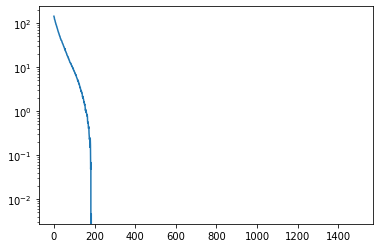

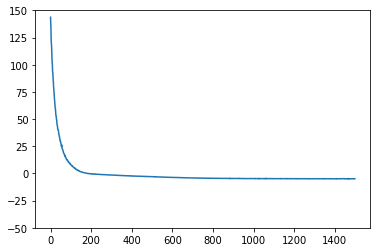


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=7.674448560866487e-05 and pval_i=3.836781680805392e-06
0 and 2 are independent with pval_d=9.508187956637502e-09 and pval_i=2.3629959552783264e-08
0 and 3 are independent with pval_d=5.703314295981496e-08 and pval_i=2.086765158388339e-06
0 and 4 are independent with pval_d=0.06721892071422943 and pval_i=0.5557308537169945
1 and 2 are DEPENDENT with pval_d=0.010449958117784267 and pval_i=0.0023339208610692
1 and 3 are independent with pval_d=1.8267118079458956e-07 and pval_i=2.423467982982231e-07
1 and 4 are independent with pval_d=0.004927233374480343 and pval_i=0.6990250969870443
2 and 3 are independent with pval_d=1.1859509396511879e-06 and pval_i=0.00013050807788025172
2 and 4 are DEPENDENT with pval_d=0.015487702092766098 and pval_i=0.011987898629442374
3 and 4 are independent with pval_d=0.7158960479239527 and pval_i=0.8798483586275113
1 2
2 2
0 1
4 1
3 0
parent 

  1%|          | 1/100 [00:02<03:33,  2.16s/it]

0 136.79558569192886


  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

1 128.6465014219284


  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

2 128.46059241890907


  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

3 128.54099179804325


  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

4 128.36701394617558


  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

5 128.31123752892017


  7%|▋         | 7/100 [00:15<03:21,  2.16s/it]

6 128.11367732286453


  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

7 128.18748693168163


  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

8 128.0793887078762


 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

9 128.00280433893204


 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

10 128.0788379907608


 12%|█▏        | 12/100 [00:25<03:10,  2.16s/it]

11 127.96900010108948


 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

12 127.96101640164852


 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

13 127.87286648154259


 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

14 127.84299816191196


 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

15 127.8975964486599


 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

16 127.83790898323059


 18%|█▊        | 18/100 [00:38<02:58,  2.17s/it]

17 127.85602270066738


 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

18 127.8046885728836


 20%|██        | 20/100 [00:43<02:53,  2.17s/it]

19 127.80994217097759


 21%|██        | 21/100 [00:45<02:51,  2.17s/it]

20 127.75260655581951


 22%|██▏       | 22/100 [00:47<02:48,  2.16s/it]

21 127.78795659542084


 23%|██▎       | 23/100 [00:49<02:47,  2.17s/it]

22 127.76553536951542


 24%|██▍       | 24/100 [00:51<02:44,  2.16s/it]

23 127.84374246001244


 25%|██▌       | 25/100 [00:54<02:42,  2.17s/it]

24 127.72288854420185


 26%|██▌       | 26/100 [00:56<02:40,  2.17s/it]

25 127.67985501885414


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 127.77071744203568


 28%|██▊       | 28/100 [01:00<02:34,  2.15s/it]

27 127.70972545444965


 29%|██▉       | 29/100 [01:02<02:32,  2.15s/it]

28 127.73345571756363


 30%|███       | 30/100 [01:04<02:30,  2.15s/it]

29 127.68603011965752


 31%|███       | 31/100 [01:06<02:28,  2.15s/it]

30 127.73556347191334


 32%|███▏      | 32/100 [01:09<02:26,  2.15s/it]

31 127.708417147398


 33%|███▎      | 33/100 [01:11<02:24,  2.15s/it]

32 127.70423170924187


 34%|███▍      | 34/100 [01:13<02:22,  2.15s/it]

33 127.7345318198204


 35%|███▌      | 35/100 [01:15<02:19,  2.15s/it]

34 127.76096884906292


 36%|███▌      | 36/100 [01:17<02:17,  2.15s/it]

35 127.67121201753616


 37%|███▋      | 37/100 [01:19<02:14,  2.14s/it]

36 127.66238111257553


 38%|███▊      | 38/100 [01:21<02:12,  2.14s/it]

37 127.67049278318882


 39%|███▉      | 39/100 [01:24<02:09,  2.13s/it]

38 127.70967474579811


 40%|████      | 40/100 [01:26<02:08,  2.14s/it]

39 127.70350612699986


 41%|████      | 41/100 [01:28<02:06,  2.14s/it]

40 127.60156765580177


 42%|████▏     | 42/100 [01:30<02:04,  2.15s/it]

41 127.7235267907381


 43%|████▎     | 43/100 [01:32<02:02,  2.14s/it]

42 127.64655663073063


 44%|████▍     | 44/100 [01:34<01:59,  2.14s/it]

43 127.63523475825787


 45%|████▌     | 45/100 [01:36<01:57,  2.14s/it]

44 127.6390888094902


 46%|████▌     | 46/100 [01:39<01:55,  2.13s/it]

45 127.64236332476139


 47%|████▋     | 47/100 [01:41<01:53,  2.13s/it]

46 127.6356506049633


 48%|████▊     | 48/100 [01:43<01:51,  2.14s/it]

47 127.60136938095093


 49%|████▉     | 49/100 [01:45<01:48,  2.13s/it]

48 127.62610664963722


 50%|█████     | 50/100 [01:47<01:46,  2.13s/it]

49 127.6885057091713


 51%|█████     | 51/100 [01:49<01:44,  2.13s/it]

50 127.6679688245058


 52%|█████▏    | 52/100 [01:51<01:42,  2.14s/it]

51 127.63895733654499


 53%|█████▎    | 53/100 [01:53<01:40,  2.13s/it]

52 127.60354353487492


 54%|█████▍    | 54/100 [01:56<01:38,  2.14s/it]

53 127.65479987859726


 55%|█████▌    | 55/100 [01:58<01:36,  2.14s/it]

54 127.65532839298248


 56%|█████▌    | 56/100 [02:00<01:34,  2.14s/it]

55 127.59758016467094


 57%|█████▋    | 57/100 [02:02<01:31,  2.13s/it]

56 127.59530878067017


 58%|█████▊    | 58/100 [02:04<01:29,  2.12s/it]

57 127.64603407680988


 59%|█████▉    | 59/100 [02:06<01:27,  2.13s/it]

58 127.64960522949696


 60%|██████    | 60/100 [02:08<01:24,  2.12s/it]

59 127.59916768968105


 61%|██████    | 61/100 [02:11<01:23,  2.13s/it]

60 127.63762503862381


 62%|██████▏   | 62/100 [02:13<01:21,  2.14s/it]

61 127.587273016572


 63%|██████▎   | 63/100 [02:15<01:19,  2.14s/it]

62 127.54717548191547


 64%|██████▍   | 64/100 [02:17<01:16,  2.13s/it]

63 127.62595936655998


 65%|██████▌   | 65/100 [02:19<01:14,  2.12s/it]

64 127.63644430041313


 66%|██████▌   | 66/100 [02:21<01:12,  2.12s/it]

65 127.60081595182419


 67%|██████▋   | 67/100 [02:23<01:10,  2.13s/it]

66 127.61385253071785


 68%|██████▊   | 68/100 [02:25<01:08,  2.14s/it]

67 127.63394486904144


 69%|██████▉   | 69/100 [02:28<01:06,  2.14s/it]

68 127.5641984641552


 70%|███████   | 70/100 [02:30<01:03,  2.12s/it]

69 127.5667309910059


 71%|███████   | 71/100 [02:32<01:01,  2.13s/it]

70 127.5862148553133


 72%|███████▏  | 72/100 [02:34<00:59,  2.13s/it]

71 127.5847661793232


 73%|███████▎  | 73/100 [02:36<00:57,  2.13s/it]

72 127.58896043896675


 74%|███████▍  | 74/100 [02:38<00:55,  2.12s/it]

73 127.57141394913197


 75%|███████▌  | 75/100 [02:40<00:52,  2.12s/it]

74 127.5671284198761


 76%|███████▌  | 76/100 [02:42<00:50,  2.12s/it]

75 127.59571325778961


 77%|███████▋  | 77/100 [02:45<00:48,  2.12s/it]

76 127.5651158541441


 78%|███████▊  | 78/100 [02:47<00:46,  2.13s/it]

77 127.61327157914639


 79%|███████▉  | 79/100 [02:49<00:44,  2.13s/it]

78 127.55639380216599


 80%|████████  | 80/100 [02:51<00:42,  2.14s/it]

79 127.5922814309597


 81%|████████  | 81/100 [02:53<00:40,  2.15s/it]

80 127.57119719684124


 82%|████████▏ | 82/100 [02:55<00:38,  2.15s/it]

81 127.59908705949783


 83%|████████▎ | 83/100 [02:57<00:36,  2.15s/it]

82 127.5455234348774


 84%|████████▍ | 84/100 [03:00<00:34,  2.14s/it]

83 127.60029597580433


 85%|████████▌ | 85/100 [03:02<00:32,  2.15s/it]

84 127.58569318056107


 86%|████████▌ | 86/100 [03:04<00:30,  2.16s/it]

85 127.59565624594688


 87%|████████▋ | 87/100 [03:06<00:28,  2.16s/it]

86 127.54912076890469


 88%|████████▊ | 88/100 [03:08<00:25,  2.15s/it]

87 127.58428707718849


 89%|████████▉ | 89/100 [03:10<00:23,  2.16s/it]

88 127.54723535478115


 90%|█████████ | 90/100 [03:13<00:21,  2.15s/it]

89 127.57240949571133


 91%|█████████ | 91/100 [03:15<00:19,  2.16s/it]

90 127.55561456084251


 92%|█████████▏| 92/100 [03:17<00:17,  2.15s/it]

91 127.5735759139061


 93%|█████████▎| 93/100 [03:19<00:15,  2.15s/it]

92 127.5989067107439


 94%|█████████▍| 94/100 [03:21<00:12,  2.14s/it]

93 127.60241070389748


 95%|█████████▌| 95/100 [03:23<00:10,  2.14s/it]

94 127.54511448740959


 96%|█████████▌| 96/100 [03:25<00:08,  2.14s/it]

95 127.57099471986294


 97%|█████████▋| 97/100 [03:28<00:06,  2.14s/it]

96 127.62354996800423


 98%|█████████▊| 98/100 [03:30<00:04,  2.14s/it]

97 127.53892983496189


 99%|█████████▉| 99/100 [03:32<00:02,  2.13s/it]

98 127.56250539422035


100%|██████████| 100/100 [03:34<00:00,  2.14s/it]

99 127.52173483371735

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.0753103494644165	

epoch 9000/10000, policy loss 0.04515647515654564	
***** test student *****
epoch 0/100 return: 22.0
epoch 1/100 return: 21.0
epoch 2/100 return: 19.0
epoch 3/100 return: 29.0
epoch 4/100 return: 28.0
epoch 5/100 return: 28.0
epoch 6/100 return: 17.0
epoch 7/100 return: 22.0
epoch 8/100 return: 26.0
epoch 9/100 return: 21.0
epoch 10/100 return: 25.0
epoch 11/100 return: 26.0
epoch 12/100 return: 19.0
epoch 13/100 return: 26.0
epoch 14/100 return: 27.0
epoch 15/100 return: 17.0
epoch 16/100 return: 22.0
epoch 17/100 return: 22.0
epoch 18/100 return: 24.0
epoch 19/100 return: 30.0
epoch 20/100 return: 25.0
epoch 21/100 return: 32.0
epoch 22/100 return: 21.0
epoch 23/100 return: 26.0
epoch 24/100 return: 22.0
epoch 25/100 return: 22.0
epoch 26/100 return: 23.0
epoch 27/100 return: 25.0
epoch 28/100 return: 30.0
epoch 29/100 return: 18.0
epoch 30/100 return: 24.0
epoch 31/100 return: 29.0
epoch 32/100 return: 26.0
epoch 33/100 return: 18.0
epoch 34/100 return: 30.0
epoch 35/100 return: 24.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.959866046905518best loss model loaded, stored at update # 1471


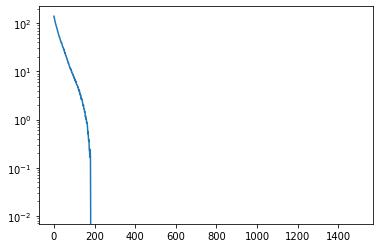

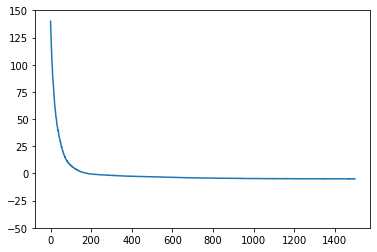


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.2832529776693202 and pval_i=0.8376929732196106
0 and 2 are independent with pval_d=2.1887087665006434e-08 and pval_i=3.923216083565642e-07
0 and 3 are DEPENDENT with pval_d=1.0839781756504699e-05 and pval_i=1.2839893155835665e-06
0 and 4 are DEPENDENT with pval_d=4.625558226803587e-05 and pval_i=3.084860176999634e-06
1 and 2 are DEPENDENT with pval_d=2.234671191522463e-06 and pval_i=1.1791081073659016e-07
1 and 3 are DEPENDENT with pval_d=0.04108200351630784 and pval_i=0.003192845688718346
1 and 4 are DEPENDENT with pval_d=0.07706817241708386 and pval_i=0.03057433026417824
2 and 3 are independent with pval_d=2.477461599387581e-07 and pval_i=2.6197007700209456e-06
2 and 4 are independent with pval_d=1.2373741159636168e-05 and pval_i=4.5828082480900753e-05
3 and 4 are independent with pval_d=1.3055016022235037e-08 and pval_i=1.510411705010917e-08
1 3
0 2
3 2
4 2
2 1

  1%|          | 1/100 [00:02<03:33,  2.15s/it]

0 132.06898705661297


  2%|▏         | 2/100 [00:04<03:32,  2.16s/it]

1 124.68535634875298


  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

2 124.56726463139057


  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

3 124.55701076984406


  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

4 124.37851418554783


  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

5 124.33164046704769


  7%|▋         | 7/100 [00:15<03:19,  2.15s/it]

6 124.21546952426434


  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

7 124.36537615954876


  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

8 124.21389362215996


 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

9 124.07753348350525


 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

10 124.12153249979019


 12%|█▏        | 12/100 [00:25<03:09,  2.16s/it]

11 124.06193608045578


 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

12 124.06500525772572


 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

13 123.96366260945797


 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

14 123.89977970719337


 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

15 123.98061309754848


 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

16 123.89299520850182


 18%|█▊        | 18/100 [00:38<02:58,  2.17s/it]

17 123.9044873714447


 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

18 123.84976504743099


 20%|██        | 20/100 [00:43<02:53,  2.17s/it]

19 123.90938287973404


 21%|██        | 21/100 [00:45<02:51,  2.17s/it]

20 123.80224521458149


 22%|██▏       | 22/100 [00:47<02:49,  2.17s/it]

21 123.82827852666378


 23%|██▎       | 23/100 [00:49<02:47,  2.17s/it]

22 123.796161621809


 24%|██▍       | 24/100 [00:51<02:44,  2.16s/it]

23 123.82904374599457


 25%|██▌       | 25/100 [00:54<02:41,  2.16s/it]

24 123.78353418409824


 26%|██▌       | 26/100 [00:56<02:39,  2.16s/it]

25 123.79630009829998


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 123.81455931067467


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 123.7561711370945


 29%|██▉       | 29/100 [01:02<02:33,  2.16s/it]

28 123.8134510666132


 30%|███       | 30/100 [01:04<02:31,  2.16s/it]

29 123.71149373054504


 31%|███       | 31/100 [01:06<02:28,  2.16s/it]

30 123.79653806984425


 32%|███▏      | 32/100 [01:09<02:26,  2.15s/it]

31 123.73295512795448


 33%|███▎      | 33/100 [01:11<02:24,  2.16s/it]

32 123.81225727498531


 34%|███▍      | 34/100 [01:13<02:21,  2.15s/it]

33 123.78735768795013


 35%|███▌      | 35/100 [01:15<02:20,  2.15s/it]

34 123.75174154341221


 36%|███▌      | 36/100 [01:17<02:18,  2.16s/it]

35 123.73774890601635


 37%|███▋      | 37/100 [01:19<02:15,  2.16s/it]

36 123.75923615694046


 38%|███▊      | 38/100 [01:22<02:13,  2.15s/it]

37 123.76352943480015


 39%|███▉      | 39/100 [01:24<02:12,  2.17s/it]

38 123.76206350326538


 40%|████      | 40/100 [01:26<02:10,  2.17s/it]

39 123.74833862483501


 41%|████      | 41/100 [01:28<02:07,  2.16s/it]

40 123.66546814143658


 42%|████▏     | 42/100 [01:30<02:05,  2.17s/it]

41 123.7559123635292


 43%|████▎     | 43/100 [01:32<02:03,  2.17s/it]

42 123.72706285119057


 44%|████▍     | 44/100 [01:35<02:00,  2.16s/it]

43 123.69450844824314


 45%|████▌     | 45/100 [01:37<01:58,  2.16s/it]

44 123.69292713701725


 46%|████▌     | 46/100 [01:39<01:56,  2.15s/it]

45 123.71769846975803


 47%|████▋     | 47/100 [01:41<01:53,  2.15s/it]

46 123.68410162627697


 48%|████▊     | 48/100 [01:43<01:51,  2.15s/it]

47 123.680523827672


 49%|████▉     | 49/100 [01:45<01:49,  2.14s/it]

48 123.70852260291576


 50%|█████     | 50/100 [01:47<01:47,  2.14s/it]

49 123.70822814106941


 51%|█████     | 51/100 [01:50<01:44,  2.14s/it]

50 123.75107429921627


 52%|█████▏    | 52/100 [01:52<01:43,  2.15s/it]

51 123.68291959166527


 53%|█████▎    | 53/100 [01:54<01:40,  2.15s/it]

52 123.71379628777504


 54%|█████▍    | 54/100 [01:56<01:38,  2.14s/it]

53 123.69403949379921


 55%|█████▌    | 55/100 [01:58<01:36,  2.14s/it]

54 123.68863135576248


 56%|█████▌    | 56/100 [02:00<01:34,  2.15s/it]

55 123.70893070101738


 57%|█████▋    | 57/100 [02:02<01:32,  2.15s/it]

56 123.65531224012375


 58%|█████▊    | 58/100 [02:05<01:30,  2.15s/it]

57 123.66801480948925


 59%|█████▉    | 59/100 [02:07<01:27,  2.14s/it]

58 123.73696088790894


 60%|██████    | 60/100 [02:09<01:25,  2.14s/it]

59 123.6658788472414


 61%|██████    | 61/100 [02:11<01:23,  2.14s/it]

60 123.70150189101696


 62%|██████▏   | 62/100 [02:13<01:21,  2.14s/it]

61 123.70111860334873


 63%|██████▎   | 63/100 [02:15<01:19,  2.14s/it]

62 123.65272754430771


 64%|██████▍   | 64/100 [02:17<01:17,  2.14s/it]

63 123.66660642623901


 65%|██████▌   | 65/100 [02:20<01:14,  2.14s/it]

64 123.65837740898132


 66%|██████▌   | 66/100 [02:22<01:12,  2.14s/it]

65 123.67336238920689


 67%|██████▋   | 67/100 [02:24<01:10,  2.14s/it]

66 123.67134523391724


 68%|██████▊   | 68/100 [02:26<01:08,  2.15s/it]

67 123.6843406111002


 69%|██████▉   | 69/100 [02:28<01:06,  2.15s/it]

68 123.68246035277843


 70%|███████   | 70/100 [02:30<01:04,  2.15s/it]

69 123.66235572099686


 71%|███████   | 71/100 [02:32<01:02,  2.15s/it]

70 123.66855753958225


 72%|███████▏  | 72/100 [02:35<01:00,  2.14s/it]

71 123.63503094017506


 73%|███████▎  | 73/100 [02:37<00:57,  2.14s/it]

72 123.66327807307243


 74%|███████▍  | 74/100 [02:39<00:55,  2.14s/it]

73 123.67136836051941


 75%|███████▌  | 75/100 [02:41<00:53,  2.15s/it]

74 123.67389987409115


 76%|███████▌  | 76/100 [02:43<00:51,  2.15s/it]

75 123.70527373254299


 77%|███████▋  | 77/100 [02:45<00:49,  2.15s/it]

76 123.60945847630501


 78%|███████▊  | 78/100 [02:47<00:47,  2.16s/it]

77 123.72345601022243


 79%|███████▉  | 79/100 [02:50<00:45,  2.16s/it]

78 123.63321992754936


 80%|████████  | 80/100 [02:52<00:43,  2.16s/it]

79 123.67243078351021


 81%|████████  | 81/100 [02:54<00:41,  2.17s/it]

80 123.62951701879501


 82%|████████▏ | 82/100 [02:56<00:38,  2.16s/it]

81 123.67767076194286


 83%|████████▎ | 83/100 [02:58<00:36,  2.14s/it]

82 123.62925672531128


 84%|████████▍ | 84/100 [03:00<00:34,  2.15s/it]

83 123.66246515512466


 85%|████████▌ | 85/100 [03:03<00:32,  2.14s/it]

84 123.65917430818081


 86%|████████▌ | 86/100 [03:05<00:29,  2.14s/it]

85 123.68746893107891


 87%|████████▋ | 87/100 [03:07<00:27,  2.14s/it]

86 123.64607900381088


 88%|████████▊ | 88/100 [03:09<00:25,  2.14s/it]

87 123.65866486728191


 89%|████████▉ | 89/100 [03:11<00:23,  2.14s/it]

88 123.64778551459312


 90%|█████████ | 90/100 [03:13<00:21,  2.14s/it]

89 123.67567099630833


 91%|█████████ | 91/100 [03:15<00:19,  2.14s/it]

90 123.62216627597809


 92%|█████████▏| 92/100 [03:18<00:17,  2.14s/it]

91 123.64380259811878


 93%|█████████▎| 93/100 [03:20<00:14,  2.14s/it]

92 123.69428803026676


 94%|█████████▍| 94/100 [03:22<00:12,  2.14s/it]

93 123.67245411872864


 95%|█████████▌| 95/100 [03:24<00:10,  2.14s/it]

94 123.6299777328968


 96%|█████████▌| 96/100 [03:26<00:08,  2.14s/it]

95 123.68532294034958


 97%|█████████▋| 97/100 [03:28<00:06,  2.14s/it]

96 123.68181371688843


 98%|█████████▊| 98/100 [03:30<00:04,  2.14s/it]

97 123.61473847925663


 99%|█████████▉| 99/100 [03:32<00:02,  2.13s/it]

98 123.67561620473862


100%|██████████| 100/100 [03:35<00:00,  2.15s/it]

99 123.63090623915195

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07590671628713608	

epoch 9000/10000, policy loss 0.04473576694726944	
***** test student *****
epoch 0/100 return: 21.0
epoch 1/100 return: 18.0
epoch 2/100 return: 23.0
epoch 3/100 return: 21.0
epoch 4/100 return: 21.0
epoch 5/100 return: 27.0
epoch 6/100 return: 17.0
epoch 7/100 return: 28.0
epoch 8/100 return: 18.0
epoch 9/100 return: 22.0
epoch 10/100 return: 25.0
epoch 11/100 return: 23.0
epoch 12/100 return: 17.0
epoch 13/100 return: 27.0
epoch 14/100 return: 24.0
epoch 15/100 return: 19.0
epoch 16/100 return: 27.0
epoch 17/100 return: 30.0
epoch 18/100 return: 22.0
epoch 19/100 return: 18.0
epoch 20/100 return: 21.0
epoch 21/100 return: 23.0
epoch 22/100 return: 17.0
epoch 23/100 return: 24.0
epoch 24/100 return: 17.0
epoch 25/100 return: 32.0
epoch 26/100 return: 20.0
epoch 27/100 return: 22.0
epoch 28/100 return: 28.0
epoch 29/100 return: 24.0
epoch 30/100 return: 22.0
epoch 31/100 return: 19.0
epoch 32/100 return: 17.0
epoch 33/100 return: 20.0
epoch 34/100 return: 23.0
epoch 35/100 return: 24.

In [23]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May2_iVAE_test1_thneg1_statedim5_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_iVAE_neg1 = policy_loss_list

In [ ]:
return_std

21.828465360624875

In [ ]:
return_mean

53.59

# iVAE [threshold = 1, state_dim = 8]

In [14]:
config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 0

batch size =  50000
Config: {'ALG': 'May2_iVAE_test_th0_statedim8_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'iVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 0, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 1 out of 10

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -5.008398056030273best loss model loaded, stored at update # 1489


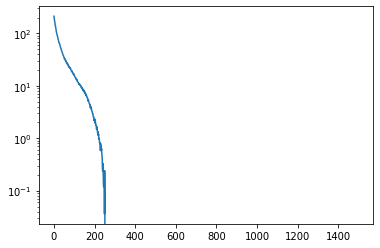

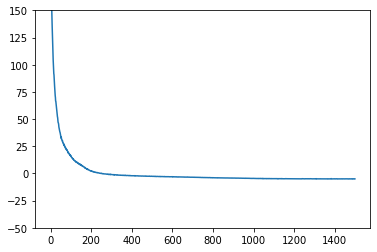


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.158767325828743 and pval_i=0.9999517251823181
0 and 2 are independent with pval_d=0.0499349142555514 and pval_i=0.9864298381199987
0 and 3 are independent with pval_d=6.92572692071491e-07 and pval_i=2.539175402798839e-06
0 and 4 are independent with pval_d=0.9929760946335175 and pval_i=0.9966887894982873
0 and 5 are DEPENDENT with pval_d=0.4256695771188685 and pval_i=0.22033354258035948
0 and 6 are independent with pval_d=0.07175355477641267 and pval_i=0.9232484887771865
0 and 7 are independent with pval_d=0.00545450768526595 and pval_i=0.6775046316421445
1 and 2 are independent with pval_d=0.31479647251555065 and pval_i=0.9990408388137813
1 and 3 are independent with pval_d=1.548154492036266e-05 and pval_i=2.400538372167659e-05
1 and 4 are independent with pval_d=0.8190726306760964 and pval_i=0.9991476519289407
1 and 5 are independent with pval_d=0.21636687047875

  1%|          | 1/100 [00:01<02:34,  1.56s/it]

0 87.20879238843918


  2%|▏         | 2/100 [00:03<02:34,  1.57s/it]

1 83.37082804739475


  3%|▎         | 3/100 [00:04<02:32,  1.57s/it]

2 83.1000706255436


  4%|▍         | 4/100 [00:06<02:31,  1.58s/it]

3 83.01597785949707


  5%|▌         | 5/100 [00:07<02:30,  1.59s/it]

4 83.07679052650928


  6%|▌         | 6/100 [00:09<02:28,  1.58s/it]

5 82.93679387867451


  7%|▋         | 7/100 [00:11<02:26,  1.57s/it]

6 82.83633893728256


  8%|▊         | 8/100 [00:12<02:25,  1.58s/it]

7 82.92218346893787


  9%|▉         | 9/100 [00:14<02:22,  1.57s/it]

8 82.87331455945969


 10%|█         | 10/100 [00:15<02:21,  1.57s/it]

9 82.89042088389397


 11%|█         | 11/100 [00:17<02:19,  1.57s/it]

10 82.76774400472641


 12%|█▏        | 12/100 [00:18<02:18,  1.57s/it]

11 82.78739249706268


 13%|█▎        | 13/100 [00:20<02:16,  1.57s/it]

12 82.81250624358654


 14%|█▍        | 14/100 [00:22<02:16,  1.58s/it]

13 82.7898327857256


 15%|█▌        | 15/100 [00:23<02:14,  1.58s/it]

14 82.78509432077408


 16%|█▌        | 16/100 [00:25<02:12,  1.58s/it]

15 82.75041683018208


 17%|█▋        | 17/100 [00:26<02:11,  1.59s/it]

16 82.76984530687332


 18%|█▊        | 18/100 [00:28<02:09,  1.58s/it]

17 82.72035519778728


 19%|█▉        | 19/100 [00:29<02:08,  1.58s/it]

18 82.73755395412445


 20%|██        | 20/100 [00:31<02:07,  1.59s/it]

19 82.75604432821274


 21%|██        | 21/100 [00:33<02:06,  1.60s/it]

20 82.7351657897234


 22%|██▏       | 22/100 [00:34<02:04,  1.59s/it]

21 82.69405716657639


 23%|██▎       | 23/100 [00:36<02:02,  1.59s/it]

22 82.71717445552349


 24%|██▍       | 24/100 [00:37<02:01,  1.60s/it]

23 82.71203990280628


 25%|██▌       | 25/100 [00:39<02:00,  1.60s/it]

24 82.74625226855278


 26%|██▌       | 26/100 [00:41<01:58,  1.61s/it]

25 82.67336378991604


 27%|██▋       | 27/100 [00:42<01:56,  1.60s/it]

26 82.65332280099392


 28%|██▊       | 28/100 [00:44<01:55,  1.60s/it]

27 82.65718571841717


 29%|██▉       | 29/100 [00:46<01:53,  1.60s/it]

28 82.67682476341724


 30%|███       | 30/100 [00:47<01:51,  1.60s/it]

29 82.66571754217148


 31%|███       | 31/100 [00:49<01:49,  1.59s/it]

30 82.70887066423893


 32%|███▏      | 32/100 [00:50<01:48,  1.59s/it]

31 82.6468002051115


 33%|███▎      | 33/100 [00:52<01:46,  1.59s/it]

32 82.62176290154457


 34%|███▍      | 34/100 [00:53<01:45,  1.60s/it]

33 82.65777203440666


 35%|███▌      | 35/100 [00:55<01:44,  1.61s/it]

34 82.62728944420815


 36%|███▌      | 36/100 [00:57<01:42,  1.60s/it]

35 82.64667855203152


 37%|███▋      | 37/100 [00:58<01:40,  1.60s/it]

36 82.64945475757122


 38%|███▊      | 38/100 [01:00<01:38,  1.60s/it]

37 82.64030975103378


 39%|███▉      | 39/100 [01:01<01:37,  1.59s/it]

38 82.61973558366299


 40%|████      | 40/100 [01:03<01:35,  1.59s/it]

39 82.67550760507584


 41%|████      | 41/100 [01:05<01:33,  1.59s/it]

40 82.58514115214348


 42%|████▏     | 42/100 [01:06<01:32,  1.59s/it]

41 82.60492497682571


 43%|████▎     | 43/100 [01:08<01:30,  1.58s/it]

42 82.62589751183987


 44%|████▍     | 44/100 [01:09<01:30,  1.61s/it]

43 82.62829893827438


 45%|████▌     | 45/100 [01:11<01:27,  1.60s/it]

44 82.63897778093815


 46%|████▌     | 46/100 [01:13<01:25,  1.59s/it]

45 82.602026745677


 47%|████▋     | 47/100 [01:14<01:24,  1.59s/it]

46 82.61755400896072


 48%|████▊     | 48/100 [01:16<01:22,  1.58s/it]

47 82.66804380714893


 49%|████▉     | 49/100 [01:17<01:20,  1.58s/it]

48 82.61213225126266


 50%|█████     | 50/100 [01:19<01:18,  1.57s/it]

49 82.62260150909424


 51%|█████     | 51/100 [01:20<01:17,  1.58s/it]

50 82.6072523444891


 52%|█████▏    | 52/100 [01:22<01:15,  1.58s/it]

51 82.609469845891


 53%|█████▎    | 53/100 [01:24<01:14,  1.58s/it]

52 82.67982949316502


 54%|█████▍    | 54/100 [01:25<01:13,  1.59s/it]

53 82.62453988194466


 55%|█████▌    | 55/100 [01:27<01:11,  1.59s/it]

54 82.61102637648582


 56%|█████▌    | 56/100 [01:28<01:10,  1.60s/it]

55 82.59107014536858


 57%|█████▋    | 57/100 [01:30<01:08,  1.59s/it]

56 82.58563107252121


 58%|█████▊    | 58/100 [01:32<01:06,  1.58s/it]

57 82.59567594528198


 59%|█████▉    | 59/100 [01:33<01:04,  1.58s/it]

58 82.63576027750969


 60%|██████    | 60/100 [01:35<01:03,  1.58s/it]

59 82.56357356905937


 61%|██████    | 61/100 [01:36<01:01,  1.58s/it]

60 82.60707747936249


 62%|██████▏   | 62/100 [01:38<01:00,  1.58s/it]

61 82.59262192249298


 63%|██████▎   | 63/100 [01:40<00:58,  1.58s/it]

62 82.61673939228058


 64%|██████▍   | 64/100 [01:41<00:56,  1.58s/it]

63 82.58919686079025


 65%|██████▌   | 65/100 [01:43<00:55,  1.59s/it]

64 82.57334896922112


 66%|██████▌   | 66/100 [01:44<00:54,  1.59s/it]

65 82.60989126563072


 67%|██████▋   | 67/100 [01:46<00:52,  1.59s/it]

66 82.58020733296871


 68%|██████▊   | 68/100 [01:48<00:51,  1.60s/it]

67 82.57925298810005


 69%|██████▉   | 69/100 [01:49<00:49,  1.60s/it]

68 82.60499249398708


 70%|███████   | 70/100 [01:51<00:47,  1.59s/it]

69 82.54683983325958


 71%|███████   | 71/100 [01:52<00:46,  1.61s/it]

70 82.60519737005234


 72%|███████▏  | 72/100 [01:54<00:44,  1.61s/it]

71 82.58879664540291


 73%|███████▎  | 73/100 [01:56<00:43,  1.60s/it]

72 82.6009424328804


 74%|███████▍  | 74/100 [01:57<00:41,  1.59s/it]

73 82.5831408649683


 75%|███████▌  | 75/100 [01:59<00:39,  1.58s/it]

74 82.6094980686903


 76%|███████▌  | 76/100 [02:00<00:37,  1.58s/it]

75 82.6068177074194


 77%|███████▋  | 77/100 [02:02<00:36,  1.58s/it]

76 82.6206284314394


 78%|███████▊  | 78/100 [02:03<00:34,  1.58s/it]

77 82.61401437222958


 79%|███████▉  | 79/100 [02:05<00:33,  1.58s/it]

78 82.57064607739449


 80%|████████  | 80/100 [02:07<00:31,  1.58s/it]

79 82.5669174194336


 81%|████████  | 81/100 [02:08<00:30,  1.58s/it]

80 82.58305329084396


 82%|████████▏ | 82/100 [02:10<00:28,  1.58s/it]

81 82.57119816541672


 83%|████████▎ | 83/100 [02:11<00:27,  1.60s/it]

82 82.5880710631609


 84%|████████▍ | 84/100 [02:13<00:25,  1.59s/it]

83 82.60758885741234


 85%|████████▌ | 85/100 [02:14<00:23,  1.59s/it]

84 82.55655346810818


 86%|████████▌ | 86/100 [02:16<00:22,  1.58s/it]

85 82.57357989251614


 87%|████████▋ | 87/100 [02:18<00:20,  1.58s/it]

86 82.59739266335964


 88%|████████▊ | 88/100 [02:19<00:18,  1.57s/it]

87 82.57448402047157


 89%|████████▉ | 89/100 [02:21<00:17,  1.56s/it]

88 82.61204901337624


 90%|█████████ | 90/100 [02:22<00:15,  1.57s/it]

89 82.58868533372879


 91%|█████████ | 91/100 [02:24<00:14,  1.57s/it]

90 82.59391756355762


 92%|█████████▏| 92/100 [02:25<00:12,  1.58s/it]

91 82.52586340904236


 93%|█████████▎| 93/100 [02:27<00:11,  1.57s/it]

92 82.61592514812946


 94%|█████████▍| 94/100 [02:29<00:09,  1.57s/it]

93 82.54188865423203


 95%|█████████▌| 95/100 [02:30<00:07,  1.58s/it]

94 82.58167584240437


 96%|█████████▌| 96/100 [02:32<00:06,  1.57s/it]

95 82.562952414155


 97%|█████████▋| 97/100 [02:33<00:04,  1.58s/it]

96 82.60496191680431


 98%|█████████▊| 98/100 [02:35<00:03,  1.57s/it]

97 82.54706586897373


 99%|█████████▉| 99/100 [02:37<00:01,  1.57s/it]

98 82.57182514667511


100%|██████████| 100/100 [02:38<00:00,  1.59s/it]

99 82.57663869857788

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07413832098245621	

epoch 9000/10000, policy loss 0.05627794936299324	
***** test student *****
epoch 0/100 return: 12.0
epoch 1/100 return: 13.0
epoch 2/100 return: 11.0
epoch 3/100 return: 13.0
epoch 4/100 return: 13.0
epoch 5/100 return: 13.0
epoch 6/100 return: 12.0
epoch 7/100 return: 12.0
epoch 8/100 return: 11.0
epoch 9/100 return: 11.0
epoch 10/100 return: 11.0
epoch 11/100 return: 12.0
epoch 12/100 return: 10.0
epoch 13/100 return: 13.0
epoch 14/100 return: 12.0
epoch 15/100 return: 11.0
epoch 16/100 return: 13.0
epoch 17/100 return: 12.0
epoch 18/100 return: 13.0
epoch 19/100 return: 11.0
epoch 20/100 return: 10.0
epoch 21/100 return: 12.0
epoch 22/100 return: 11.0
epoch 23/100 return: 11.0
epoch 24/100 return: 13.0
epoch 25/100 return: 12.0
epoch 26/100 return: 12.0
epoch 27/100 return: 11.0
epoch 28/100 return: 10.0
epoch 29/100 return: 11.0
epoch 30/100 return: 11.0
epoch 31/100 return: 12.0
epoch 32/100 return: 11.0
epoch 33/100 return: 10.0
epoch 34/100 return: 13.0
epoch 35/100 return: 11.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.901029586791992best loss model loaded, stored at update # 1467


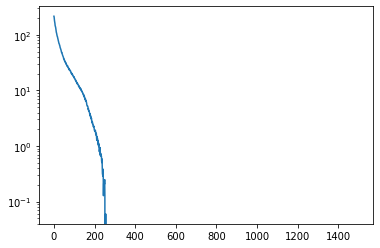

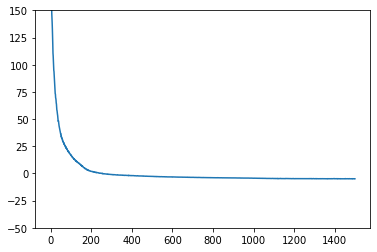


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.5675130179018831 and pval_i=0.8573366951039283
0 and 2 are independent with pval_d=0.3595920225318266 and pval_i=0.991276412425403
0 and 3 are DEPENDENT with pval_d=0.0003090802699291766 and pval_i=9.366735773593976e-06
0 and 4 are independent with pval_d=0.5473397548103365 and pval_i=0.9954772935908114
0 and 5 are independent with pval_d=0.09906380231641744 and pval_i=0.9977550639493173
0 and 6 are independent with pval_d=0.313950785490664 and pval_i=0.9834704112486303
0 and 7 are independent with pval_d=0.6474740379219339 and pval_i=0.9998705728010127
1 and 2 are DEPENDENT with pval_d=0.00021218641271522433 and pval_i=7.014806447506372e-08
1 and 3 are DEPENDENT with pval_d=1.1631535956456391e-09 and pval_i=3.3337091128391664e-10
1 and 4 are independent with pval_d=0.02788120360158226 and pval_i=0.8029892571076702
1 and 5 are independent with pval_d=1.24053806458

  1%|          | 1/100 [00:01<02:37,  1.59s/it]

0 82.42512571811676


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

1 78.31906333565712


  3%|▎         | 3/100 [00:04<02:33,  1.59s/it]

2 78.2101913690567


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

3 78.12770739197731


  5%|▌         | 5/100 [00:07<02:31,  1.59s/it]

4 78.14567226171494


  6%|▌         | 6/100 [00:09<02:30,  1.60s/it]

5 77.98413816094398


  7%|▋         | 7/100 [00:11<02:28,  1.59s/it]

6 77.91816875338554


  8%|▊         | 8/100 [00:12<02:25,  1.58s/it]

7 77.93078322708607


  9%|▉         | 9/100 [00:14<02:24,  1.59s/it]

8 77.94641284644604


 10%|█         | 10/100 [00:15<02:23,  1.60s/it]

9 77.92405271530151


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

10 77.84621202945709


 12%|█▏        | 12/100 [00:19<02:20,  1.59s/it]

11 77.86323387920856


 13%|█▎        | 13/100 [00:20<02:18,  1.60s/it]

12 77.81393720209599


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

13 77.78976100683212


 15%|█▌        | 15/100 [00:23<02:15,  1.59s/it]

14 77.82750804722309


 16%|█▌        | 16/100 [00:25<02:13,  1.59s/it]

15 77.77769164741039


 17%|█▋        | 17/100 [00:27<02:12,  1.60s/it]

16 77.78948929905891


 18%|█▊        | 18/100 [00:28<02:10,  1.59s/it]

17 77.73052752017975


 19%|█▉        | 19/100 [00:30<02:08,  1.59s/it]

18 77.77201214432716


 20%|██        | 20/100 [00:31<02:06,  1.59s/it]

19 77.7381758838892


 21%|██        | 21/100 [00:33<02:05,  1.59s/it]

20 77.71691419184208


 22%|██▏       | 22/100 [00:35<02:04,  1.59s/it]

21 77.71011012792587


 23%|██▎       | 23/100 [00:36<02:02,  1.60s/it]

22 77.67681401968002


 24%|██▍       | 24/100 [00:38<02:01,  1.60s/it]

23 77.67249912023544


 25%|██▌       | 25/100 [00:39<02:00,  1.60s/it]

24 77.69023261964321


 26%|██▌       | 26/100 [00:41<01:58,  1.60s/it]

25 77.67498306930065


 27%|██▋       | 27/100 [00:43<01:56,  1.59s/it]

26 77.65757840871811


 28%|██▊       | 28/100 [00:44<01:54,  1.59s/it]

27 77.65432634949684


 29%|██▉       | 29/100 [00:46<01:52,  1.59s/it]

28 77.6495094448328


 30%|███       | 30/100 [00:47<01:51,  1.59s/it]

29 77.65679498016834


 31%|███       | 31/100 [00:49<01:49,  1.59s/it]

30 77.606374502182


 32%|███▏      | 32/100 [00:50<01:47,  1.58s/it]

31 77.67208154499531


 33%|███▎      | 33/100 [00:52<01:45,  1.58s/it]

32 77.61832097172737


 34%|███▍      | 34/100 [00:54<01:45,  1.60s/it]

33 77.63777288794518


 35%|███▌      | 35/100 [00:55<01:44,  1.60s/it]

34 77.60440303385258


 36%|███▌      | 36/100 [00:57<01:42,  1.59s/it]

35 77.66794310510159


 37%|███▋      | 37/100 [00:58<01:40,  1.60s/it]

36 77.60379493236542


 38%|███▊      | 38/100 [01:00<01:38,  1.59s/it]

37 77.62039375305176


 39%|███▉      | 39/100 [01:02<01:37,  1.60s/it]

38 77.60039673745632


 40%|████      | 40/100 [01:03<01:35,  1.60s/it]

39 77.67090708017349


 41%|████      | 41/100 [01:05<01:33,  1.59s/it]

40 77.59513673186302


 42%|████▏     | 42/100 [01:06<01:31,  1.59s/it]

41 77.60508224368095


 43%|████▎     | 43/100 [01:08<01:30,  1.59s/it]

42 77.61553107202053


 44%|████▍     | 44/100 [01:10<01:29,  1.59s/it]

43 77.62975297868252


 45%|████▌     | 45/100 [01:11<01:27,  1.59s/it]

44 77.60575413703918


 46%|████▌     | 46/100 [01:13<01:26,  1.59s/it]

45 77.61622010171413


 47%|████▋     | 47/100 [01:14<01:24,  1.59s/it]

46 77.6180169582367


 48%|████▊     | 48/100 [01:16<01:22,  1.58s/it]

47 77.62641420960426


 49%|████▉     | 49/100 [01:17<01:20,  1.58s/it]

48 77.61776226758957


 50%|█████     | 50/100 [01:19<01:19,  1.58s/it]

49 77.57967641949654


 51%|█████     | 51/100 [01:21<01:17,  1.58s/it]

50 77.61285519599915


 52%|█████▏    | 52/100 [01:22<01:15,  1.58s/it]

51 77.60384845733643


 53%|█████▎    | 53/100 [01:24<01:14,  1.59s/it]

52 77.65007396042347


 54%|█████▍    | 54/100 [01:25<01:13,  1.60s/it]

53 77.6153539121151


 55%|█████▌    | 55/100 [01:27<01:11,  1.60s/it]

54 77.58339619636536


 56%|█████▌    | 56/100 [01:29<01:10,  1.59s/it]

55 77.62129984796047


 57%|█████▋    | 57/100 [01:30<01:08,  1.59s/it]

56 77.6092209070921


 58%|█████▊    | 58/100 [01:32<01:06,  1.59s/it]

57 77.58817157149315


 59%|█████▉    | 59/100 [01:33<01:05,  1.59s/it]

58 77.61575263738632


 60%|██████    | 60/100 [01:35<01:03,  1.59s/it]

59 77.57596763968468


 61%|██████    | 61/100 [01:37<01:02,  1.61s/it]

60 77.59049135446548


 62%|██████▏   | 62/100 [01:38<01:01,  1.61s/it]

61 77.59014756977558


 63%|██████▎   | 63/100 [01:40<00:59,  1.61s/it]

62 77.61010277271271


 64%|██████▍   | 64/100 [01:41<00:57,  1.60s/it]

63 77.58026018738747


 65%|██████▌   | 65/100 [01:43<00:55,  1.59s/it]

64 77.57617634534836


 66%|██████▌   | 66/100 [01:45<00:54,  1.60s/it]

65 77.58033888041973


 67%|██████▋   | 67/100 [01:46<00:52,  1.60s/it]

66 77.61148172616959


 68%|██████▊   | 68/100 [01:48<00:51,  1.60s/it]

67 77.5567521750927


 69%|██████▉   | 69/100 [01:49<00:49,  1.60s/it]

68 77.58405478298664


 70%|███████   | 70/100 [01:51<00:47,  1.59s/it]

69 77.5597463697195


 71%|███████   | 71/100 [01:53<00:46,  1.59s/it]

70 77.5950245410204


 72%|███████▏  | 72/100 [01:54<00:44,  1.60s/it]

71 77.58457535505295


 73%|███████▎  | 73/100 [01:56<00:43,  1.60s/it]

72 77.56402035057545


 74%|███████▍  | 74/100 [01:57<00:41,  1.60s/it]

73 77.5830205976963


 75%|███████▌  | 75/100 [01:59<00:40,  1.60s/it]

74 77.57636353373528


 76%|███████▌  | 76/100 [02:01<00:38,  1.59s/it]

75 77.57622787356377


 77%|███████▋  | 77/100 [02:02<00:36,  1.59s/it]

76 77.56306111812592


 78%|███████▊  | 78/100 [02:04<00:34,  1.59s/it]

77 77.62177562713623


 79%|███████▉  | 79/100 [02:05<00:33,  1.59s/it]

78 77.5671416670084


 80%|████████  | 80/100 [02:07<00:31,  1.60s/it]

79 77.58445861935616


 81%|████████  | 81/100 [02:09<00:30,  1.61s/it]

80 77.55325320363045


 82%|████████▏ | 82/100 [02:10<00:28,  1.60s/it]

81 77.55374264717102


 83%|████████▎ | 83/100 [02:12<00:27,  1.60s/it]

82 77.5791653841734


 84%|████████▍ | 84/100 [02:13<00:25,  1.60s/it]

83 77.58102934062481


 85%|████████▌ | 85/100 [02:15<00:23,  1.60s/it]

84 77.54772298038006


 86%|████████▌ | 86/100 [02:17<00:22,  1.59s/it]

85 77.55477957427502


 87%|████████▋ | 87/100 [02:18<00:20,  1.59s/it]

86 77.6180627644062


 88%|████████▊ | 88/100 [02:20<00:19,  1.59s/it]

87 77.57974104583263


 89%|████████▉ | 89/100 [02:21<00:17,  1.58s/it]

88 77.59171116352081


 90%|█████████ | 90/100 [02:23<00:15,  1.58s/it]

89 77.56054496765137


 91%|█████████ | 91/100 [02:25<00:14,  1.59s/it]

90 77.58270356059074


 92%|█████████▏| 92/100 [02:26<00:12,  1.60s/it]

91 77.55676534771919


 93%|█████████▎| 93/100 [02:28<00:11,  1.61s/it]

92 77.5881175994873


 94%|█████████▍| 94/100 [02:29<00:09,  1.60s/it]

93 77.5504769384861


 95%|█████████▌| 95/100 [02:31<00:07,  1.60s/it]

94 77.58505643904209


 96%|█████████▌| 96/100 [02:33<00:06,  1.60s/it]

95 77.56121326982975


 97%|█████████▋| 97/100 [02:34<00:04,  1.60s/it]

96 77.5695336163044


 98%|█████████▊| 98/100 [02:36<00:03,  1.60s/it]

97 77.55228359997272


 99%|█████████▉| 99/100 [02:37<00:01,  1.60s/it]

98 77.58575305342674


100%|██████████| 100/100 [02:39<00:00,  1.59s/it]

99 77.59912347793579

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07420842349529266	

epoch 9000/10000, policy loss 0.050404518842697144	
***** test student *****
epoch 0/100 return: 118.0
epoch 1/100 return: 110.0
epoch 2/100 return: 120.0
epoch 3/100 return: 102.0
epoch 4/100 return: 112.0
epoch 5/100 return: 125.0
epoch 6/100 return: 114.0
epoch 7/100 return: 108.0
epoch 8/100 return: 99.0
epoch 9/100 return: 99.0
epoch 10/100 return: 123.0
epoch 11/100 return: 113.0
epoch 12/100 return: 100.0
epoch 13/100 return: 114.0
epoch 14/100 return: 111.0
epoch 15/100 return: 100.0
epoch 16/100 return: 124.0
epoch 17/100 return: 125.0
epoch 18/100 return: 107.0
epoch 19/100 return: 105.0
epoch 20/100 return: 120.0
epoch 21/100 return: 117.0
epoch 22/100 return: 123.0
epoch 23/100 return: 103.0
epoch 24/100 return: 102.0
epoch 25/100 return: 129.0
epoch 26/100 return: 104.0
epoch 27/100 return: 113.0
epoch 28/100 return: 130.0
epoch 29/100 return: 112.0
epoch 30/100 return: 117.0
epoch 31/100 return: 128.0
epoch 32/100 return: 110.0
epoch 33/100 return: 107.0
epoch 34/100 retu

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.844559669494629best loss model loaded, stored at update # 1468


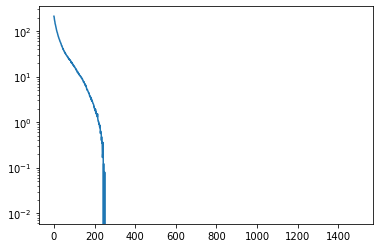

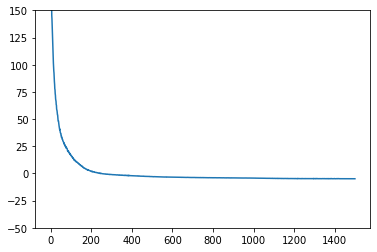


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.17570927744721723 and pval_i=0.9944206653296304
0 and 2 are DEPENDENT with pval_d=0.7483171825251278 and pval_i=0.2332702776316658
0 and 3 are independent with pval_d=4.827687948852206e-07 and pval_i=1.043533112653467e-06
0 and 4 are independent with pval_d=0.8996009620712071 and pval_i=0.9998924120725339
0 and 5 are DEPENDENT with pval_d=0.4370233209820016 and pval_i=0.064061380399967
0 and 6 are DEPENDENT with pval_d=0.08527809718284916 and pval_i=0.011637837318402912
0 and 7 are independent with pval_d=0.0003089316769342838 and pval_i=0.29463505840227094
1 and 2 are independent with pval_d=0.036449602960007634 and pval_i=0.9755043318159897
1 and 3 are DEPENDENT with pval_d=3.807189889369121e-06 and pval_i=1.4136569065227277e-07
1 and 4 are independent with pval_d=0.1962727820229227 and pval_i=0.9565791596596611
1 and 5 are independent with pval_d=0.154971543610

  1%|          | 1/100 [00:01<02:36,  1.58s/it]

0 80.57659862935543


  2%|▏         | 2/100 [00:03<02:36,  1.60s/it]

1 77.02833950519562


  3%|▎         | 3/100 [00:04<02:34,  1.59s/it]

2 76.8000817745924


  4%|▍         | 4/100 [00:06<02:32,  1.59s/it]

3 76.80275252461433


  5%|▌         | 5/100 [00:07<02:30,  1.59s/it]

4 76.76941539347172


  6%|▌         | 6/100 [00:09<02:29,  1.59s/it]

5 76.67535565793514


  7%|▋         | 7/100 [00:11<02:28,  1.59s/it]

6 76.61307661235332


  8%|▊         | 8/100 [00:12<02:26,  1.59s/it]

7 76.62174333631992


  9%|▉         | 9/100 [00:14<02:24,  1.59s/it]

8 76.61336144804955


 10%|█         | 10/100 [00:15<02:25,  1.61s/it]

9 76.57495303452015


 11%|█         | 11/100 [00:17<02:24,  1.62s/it]

10 76.4980620443821


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 76.5321763753891


 13%|█▎        | 13/100 [00:20<02:18,  1.60s/it]

12 76.5564956665039


 14%|█▍        | 14/100 [00:22<02:16,  1.59s/it]

13 76.48052284121513


 15%|█▌        | 15/100 [00:23<02:14,  1.58s/it]

14 76.50742520391941


 16%|█▌        | 16/100 [00:25<02:12,  1.58s/it]

15 76.44865453243256


 17%|█▋        | 17/100 [00:27<02:10,  1.57s/it]

16 76.46941928565502


 18%|█▊        | 18/100 [00:28<02:09,  1.58s/it]

17 76.4497072994709


 19%|█▉        | 19/100 [00:30<02:07,  1.58s/it]

18 76.45883411169052


 20%|██        | 20/100 [00:31<02:06,  1.58s/it]

19 76.40086077153683


 21%|██        | 21/100 [00:33<02:05,  1.59s/it]

20 76.41484649479389


 22%|██▏       | 22/100 [00:34<02:03,  1.59s/it]

21 76.42528495192528


 23%|██▎       | 23/100 [00:36<02:02,  1.58s/it]

22 76.38810823857784


 24%|██▍       | 24/100 [00:38<02:00,  1.58s/it]

23 76.38607704639435


 25%|██▌       | 25/100 [00:39<01:58,  1.59s/it]

24 76.39712905883789


 26%|██▌       | 26/100 [00:41<01:57,  1.59s/it]

25 76.38883684575558


 27%|██▋       | 27/100 [00:42<01:56,  1.59s/it]

26 76.35670629143715


 28%|██▊       | 28/100 [00:44<01:54,  1.59s/it]

27 76.35875153541565


 29%|██▉       | 29/100 [00:46<01:54,  1.61s/it]

28 76.36298671364784


 30%|███       | 30/100 [00:47<01:52,  1.61s/it]

29 76.37752056121826


 31%|███       | 31/100 [00:49<01:50,  1.60s/it]

30 76.34141764044762


 32%|███▏      | 32/100 [00:50<01:48,  1.60s/it]

31 76.40000765025616


 33%|███▎      | 33/100 [00:52<01:46,  1.60s/it]

32 76.35361900925636


 34%|███▍      | 34/100 [00:54<01:44,  1.59s/it]

33 76.35880196094513


 35%|███▌      | 35/100 [00:55<01:43,  1.59s/it]

34 76.31950102746487


 36%|███▌      | 36/100 [00:57<01:41,  1.58s/it]

35 76.37892958521843


 37%|███▋      | 37/100 [00:58<01:40,  1.59s/it]

36 76.34714052081108


 38%|███▊      | 38/100 [01:00<01:38,  1.59s/it]

37 76.3427783548832


 39%|███▉      | 39/100 [01:02<01:37,  1.59s/it]

38 76.33498145639896


 40%|████      | 40/100 [01:03<01:35,  1.59s/it]

39 76.35664542019367


 41%|████      | 41/100 [01:05<01:33,  1.59s/it]

40 76.30448491871357


 42%|████▏     | 42/100 [01:06<01:32,  1.59s/it]

41 76.34210519492626


 43%|████▎     | 43/100 [01:08<01:30,  1.59s/it]

42 76.33373267948627


 44%|████▍     | 44/100 [01:09<01:28,  1.58s/it]

43 76.34383554756641


 45%|████▌     | 45/100 [01:11<01:27,  1.58s/it]

44 76.33323886990547


 46%|████▌     | 46/100 [01:13<01:25,  1.58s/it]

45 76.34971641004086


 47%|████▋     | 47/100 [01:14<01:24,  1.59s/it]

46 76.36114829778671


 48%|████▊     | 48/100 [01:16<01:22,  1.59s/it]

47 76.30871526896954


 49%|████▉     | 49/100 [01:17<01:21,  1.60s/it]

48 76.33790192008018


 50%|█████     | 50/100 [01:19<01:19,  1.60s/it]

49 76.28149569034576


 51%|█████     | 51/100 [01:21<01:17,  1.59s/it]

50 76.32138703763485


 52%|█████▏    | 52/100 [01:22<01:16,  1.59s/it]

51 76.35795259475708


 53%|█████▎    | 53/100 [01:24<01:14,  1.58s/it]

52 76.35021169483662


 54%|█████▍    | 54/100 [01:25<01:12,  1.58s/it]

53 76.31999590992928


 55%|█████▌    | 55/100 [01:27<01:10,  1.58s/it]

54 76.31546026468277


 56%|█████▌    | 56/100 [01:29<01:09,  1.58s/it]

55 76.3207651078701


 57%|█████▋    | 57/100 [01:30<01:08,  1.58s/it]

56 76.31532745063305


 58%|█████▊    | 58/100 [01:32<01:06,  1.58s/it]

57 76.3299021422863


 59%|█████▉    | 59/100 [01:33<01:05,  1.59s/it]

58 76.3175658583641


 60%|██████    | 60/100 [01:35<01:03,  1.58s/it]

59 76.31484390795231


 61%|██████    | 61/100 [01:36<01:01,  1.58s/it]

60 76.30802421271801


 62%|██████▏   | 62/100 [01:38<01:00,  1.58s/it]

61 76.30479244887829


 63%|██████▎   | 63/100 [01:40<00:58,  1.58s/it]

62 76.30891436338425


 64%|██████▍   | 64/100 [01:41<00:56,  1.58s/it]

63 76.29034879803658


 65%|██████▌   | 65/100 [01:43<00:55,  1.59s/it]

64 76.3076995909214


 66%|██████▌   | 66/100 [01:44<00:54,  1.60s/it]

65 76.32940408587456


 67%|██████▋   | 67/100 [01:46<00:52,  1.60s/it]

66 76.32643601298332


 68%|██████▊   | 68/100 [01:48<00:51,  1.61s/it]

67 76.29400897026062


 69%|██████▉   | 69/100 [01:49<00:49,  1.61s/it]

68 76.31787666678429


 70%|███████   | 70/100 [01:51<00:48,  1.60s/it]

69 76.27222792804241


 71%|███████   | 71/100 [01:52<00:46,  1.60s/it]

70 76.32848291099072


 72%|███████▏  | 72/100 [01:54<00:44,  1.59s/it]

71 76.29463136196136


 73%|███████▎  | 73/100 [01:56<00:42,  1.59s/it]

72 76.29459358751774


 74%|███████▍  | 74/100 [01:57<00:41,  1.58s/it]

73 76.31430393457413


 75%|███████▌  | 75/100 [01:59<00:39,  1.59s/it]

74 76.31630435585976


 76%|███████▌  | 76/100 [02:00<00:37,  1.58s/it]

75 76.31434464454651


 77%|███████▋  | 77/100 [02:02<00:36,  1.58s/it]

76 76.31105092167854


 78%|███████▊  | 78/100 [02:03<00:34,  1.58s/it]

77 76.33012817800045


 79%|███████▉  | 79/100 [02:05<00:33,  1.58s/it]

78 76.30733072757721


 80%|████████  | 80/100 [02:07<00:31,  1.59s/it]

79 76.30100077390671


 81%|████████  | 81/100 [02:08<00:30,  1.58s/it]

80 76.28615325689316


 82%|████████▏ | 82/100 [02:10<00:28,  1.58s/it]

81 76.30340053141117


 83%|████████▎ | 83/100 [02:11<00:26,  1.58s/it]

82 76.33340959250927


 84%|████████▍ | 84/100 [02:13<00:25,  1.58s/it]

83 76.31518097221851


 85%|████████▌ | 85/100 [02:15<00:23,  1.58s/it]

84 76.30597925186157


 86%|████████▌ | 86/100 [02:16<00:22,  1.59s/it]

85 76.29828478395939


 87%|████████▋ | 87/100 [02:18<00:20,  1.59s/it]

86 76.3002087622881


 88%|████████▊ | 88/100 [02:19<00:19,  1.60s/it]

87 76.28108288347721


 89%|████████▉ | 89/100 [02:21<00:17,  1.60s/it]

88 76.31428913772106


 90%|█████████ | 90/100 [02:23<00:15,  1.60s/it]

89 76.30413337051868


 91%|█████████ | 91/100 [02:24<00:14,  1.60s/it]

90 76.32276622951031


 92%|█████████▏| 92/100 [02:26<00:12,  1.60s/it]

91 76.2772618830204


 93%|█████████▎| 93/100 [02:27<00:11,  1.60s/it]

92 76.32525697350502


 94%|█████████▍| 94/100 [02:29<00:09,  1.59s/it]

93 76.29686957597733


 95%|█████████▌| 95/100 [02:31<00:07,  1.60s/it]

94 76.29113405942917


 96%|█████████▌| 96/100 [02:32<00:06,  1.60s/it]

95 76.29059378802776


 97%|█████████▋| 97/100 [02:34<00:04,  1.60s/it]

96 76.32071401178837


 98%|█████████▊| 98/100 [02:35<00:03,  1.60s/it]

97 76.2766591757536


 99%|█████████▉| 99/100 [02:37<00:01,  1.59s/it]

98 76.30113948881626


100%|██████████| 100/100 [02:39<00:00,  1.59s/it]

99 76.3365572988987

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07525943219661713	

epoch 9000/10000, policy loss 0.04541577026247978	
***** test student *****
epoch 0/100 return: 22.0
epoch 1/100 return: 22.0
epoch 2/100 return: 18.0
epoch 3/100 return: 19.0
epoch 4/100 return: 21.0
epoch 5/100 return: 18.0
epoch 6/100 return: 22.0
epoch 7/100 return: 16.0
epoch 8/100 return: 21.0
epoch 9/100 return: 20.0
epoch 10/100 return: 18.0
epoch 11/100 return: 19.0
epoch 12/100 return: 17.0
epoch 13/100 return: 20.0
epoch 14/100 return: 26.0
epoch 15/100 return: 26.0
epoch 16/100 return: 20.0
epoch 17/100 return: 21.0
epoch 18/100 return: 25.0
epoch 19/100 return: 24.0
epoch 20/100 return: 17.0
epoch 21/100 return: 21.0
epoch 22/100 return: 19.0
epoch 23/100 return: 26.0
epoch 24/100 return: 28.0
epoch 25/100 return: 19.0
epoch 26/100 return: 19.0
epoch 27/100 return: 22.0
epoch 28/100 return: 18.0
epoch 29/100 return: 21.0
epoch 30/100 return: 17.0
epoch 31/100 return: 27.0
epoch 32/100 return: 24.0
epoch 33/100 return: 20.0
epoch 34/100 return: 23.0
epoch 35/100 return: 17.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.86448860168457best loss model loaded, stored at update # 1491


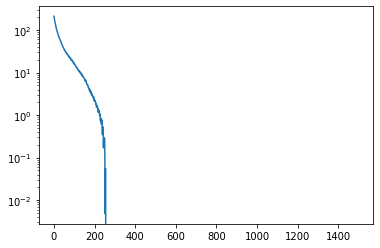

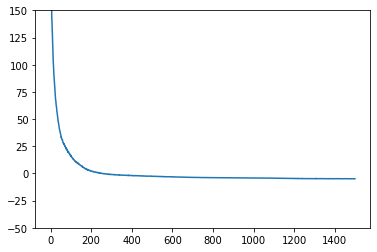


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=0.9953222513397991 and pval_i=0.9907626544117876
0 and 2 are independent with pval_d=0.46989222297007016 and pval_i=0.9703572558882269
0 and 3 are DEPENDENT with pval_d=1.6187686033608818e-07 and pval_i=4.904855005540386e-08
0 and 4 are DEPENDENT with pval_d=0.9999286532079781 and pval_i=0.9926436893201503
0 and 5 are DEPENDENT with pval_d=0.04885582871151541 and pval_i=0.012395182049012349
0 and 6 are DEPENDENT with pval_d=0.6777816208738863 and pval_i=0.049341910099245025
0 and 7 are independent with pval_d=0.036434673577625955 and pval_i=0.6582629775631229
1 and 2 are independent with pval_d=0.7482910714655251 and pval_i=0.9006625920862475
1 and 3 are DEPENDENT with pval_d=7.93405340718446e-07 and pval_i=1.7444461656303586e-08
1 and 4 are independent with pval_d=0.07583737589445677 and pval_i=0.9903894713502821
1 and 5 are independent with pval_d=0.0632385760921194

  1%|          | 1/100 [00:01<02:42,  1.64s/it]

0 66.3129788711667


  2%|▏         | 2/100 [00:03<02:37,  1.61s/it]

1 63.45671611279249


  3%|▎         | 3/100 [00:04<02:36,  1.61s/it]

2 63.345685206353664


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

3 63.31290985643864


  5%|▌         | 5/100 [00:08<02:32,  1.61s/it]

4 63.27329017966986


  6%|▌         | 6/100 [00:09<02:30,  1.60s/it]

5 63.230741664767265


  7%|▋         | 7/100 [00:11<02:28,  1.59s/it]

6 63.19730332493782


  8%|▊         | 8/100 [00:12<02:26,  1.59s/it]

7 63.23823270946741


  9%|▉         | 9/100 [00:14<02:24,  1.58s/it]

8 63.17608492821455


 10%|█         | 10/100 [00:15<02:23,  1.59s/it]

9 63.200434662401676


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

10 63.1197514384985


 12%|█▏        | 12/100 [00:19<02:20,  1.60s/it]

11 63.12836066633463


 13%|█▎        | 13/100 [00:20<02:18,  1.60s/it]

12 63.150152288377285


 14%|█▍        | 14/100 [00:22<02:17,  1.60s/it]

13 63.13090496510267


 15%|█▌        | 15/100 [00:23<02:15,  1.59s/it]

14 63.14417031407356


 16%|█▌        | 16/100 [00:25<02:13,  1.58s/it]

15 63.11421014368534


 17%|█▋        | 17/100 [00:27<02:11,  1.59s/it]

16 63.111614890396595


 18%|█▊        | 18/100 [00:28<02:10,  1.59s/it]

17 63.08606015145779


 19%|█▉        | 19/100 [00:30<02:08,  1.59s/it]

18 63.09638523310423


 20%|██        | 20/100 [00:31<02:07,  1.60s/it]

19 63.097632609307766


 21%|██        | 21/100 [00:33<02:07,  1.61s/it]

20 63.07879765331745


 22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]

21 63.06736920773983


 23%|██▎       | 23/100 [00:36<02:03,  1.61s/it]

22 63.06081838160753


 24%|██▍       | 24/100 [00:38<02:01,  1.60s/it]

23 63.037424616515636


 25%|██▌       | 25/100 [00:40<02:01,  1.62s/it]

24 63.061348251998425


 26%|██▌       | 26/100 [00:41<01:58,  1.60s/it]

25 63.04137121886015


 27%|██▋       | 27/100 [00:43<01:56,  1.59s/it]

26 63.010282568633556


 28%|██▊       | 28/100 [00:44<01:55,  1.61s/it]

27 63.0014336258173


 29%|██▉       | 29/100 [00:46<01:53,  1.61s/it]

28 63.01278360188007


 30%|███       | 30/100 [00:48<01:52,  1.61s/it]

29 62.99736261367798


 31%|███       | 31/100 [00:49<01:51,  1.62s/it]

30 62.994306690990925


 32%|███▏      | 32/100 [00:51<01:49,  1.61s/it]

31 63.0231421738863


 33%|███▎      | 33/100 [00:52<01:47,  1.60s/it]

32 62.98020499944687


 34%|███▍      | 34/100 [00:54<01:45,  1.60s/it]

33 63.02478364109993


 35%|███▌      | 35/100 [00:55<01:43,  1.59s/it]

34 62.99085842072964


 36%|███▌      | 36/100 [00:57<01:41,  1.59s/it]

35 63.02384165674448


 37%|███▋      | 37/100 [00:59<01:39,  1.59s/it]

36 62.98432520776987


 38%|███▊      | 38/100 [01:00<01:38,  1.58s/it]

37 62.98693420737982


 39%|███▉      | 39/100 [01:02<01:36,  1.58s/it]

38 62.98785098642111


 40%|████      | 40/100 [01:03<01:35,  1.59s/it]

39 63.018227867782116


 41%|████      | 41/100 [01:05<01:33,  1.59s/it]

40 62.94912476837635


 42%|████▏     | 42/100 [01:07<01:32,  1.59s/it]

41 62.98518896102905


 43%|████▎     | 43/100 [01:08<01:31,  1.60s/it]

42 62.97859848290682


 44%|████▍     | 44/100 [01:10<01:29,  1.60s/it]

43 62.98951365053654


 45%|████▌     | 45/100 [01:11<01:27,  1.60s/it]

44 62.98460306227207


 46%|████▌     | 46/100 [01:13<01:26,  1.60s/it]

45 62.99283105134964


 47%|████▋     | 47/100 [01:15<01:24,  1.60s/it]

46 62.96852011978626


 48%|████▊     | 48/100 [01:16<01:23,  1.60s/it]

47 62.97907092422247


 49%|████▉     | 49/100 [01:18<01:22,  1.61s/it]

48 62.978894546628


 50%|█████     | 50/100 [01:19<01:20,  1.62s/it]

49 62.957777820527554


 51%|█████     | 51/100 [01:21<01:18,  1.61s/it]

50 62.96019107848406


 52%|█████▏    | 52/100 [01:23<01:17,  1.61s/it]

51 62.975337117910385


 53%|█████▎    | 53/100 [01:24<01:15,  1.60s/it]

52 63.01258797943592


 54%|█████▍    | 54/100 [01:26<01:14,  1.63s/it]

53 62.97315176576376


 55%|█████▌    | 55/100 [01:28<01:13,  1.62s/it]

54 62.967525877058506


 56%|█████▌    | 56/100 [01:29<01:10,  1.61s/it]

55 62.969417989254


 57%|█████▋    | 57/100 [01:31<01:09,  1.61s/it]

56 62.97576396912336


 58%|█████▊    | 58/100 [01:32<01:07,  1.61s/it]

57 62.96494556963444


 59%|█████▉    | 59/100 [01:34<01:06,  1.63s/it]

58 62.976163417100906


 60%|██████    | 60/100 [01:36<01:04,  1.62s/it]

59 62.95707310736179


 61%|██████    | 61/100 [01:37<01:03,  1.62s/it]

60 62.96854504942894


 62%|██████▏   | 62/100 [01:39<01:01,  1.61s/it]

61 62.96062192320824


 63%|██████▎   | 63/100 [01:40<00:59,  1.60s/it]

62 62.966455943882465


 64%|██████▍   | 64/100 [01:42<00:58,  1.61s/it]

63 62.95216589421034


 65%|██████▌   | 65/100 [01:44<00:56,  1.61s/it]

64 62.963527008891106


 66%|██████▌   | 66/100 [01:45<00:54,  1.62s/it]

65 62.970200933516026


 67%|██████▋   | 67/100 [01:47<00:53,  1.62s/it]

66 62.96362864971161


 68%|██████▊   | 68/100 [01:49<00:51,  1.62s/it]

67 62.946160562336445


 69%|██████▉   | 69/100 [01:50<00:50,  1.62s/it]

68 62.97470897436142


 70%|███████   | 70/100 [01:52<00:48,  1.62s/it]

69 62.93644714355469


 71%|███████   | 71/100 [01:53<00:47,  1.62s/it]

70 62.985002249479294


 72%|███████▏  | 72/100 [01:55<00:45,  1.62s/it]

71 62.948345221579075


 73%|███████▎  | 73/100 [01:57<00:43,  1.63s/it]

72 62.9573964625597


 74%|███████▍  | 74/100 [01:58<00:42,  1.62s/it]

73 62.96839764714241


 75%|███████▌  | 75/100 [02:00<00:40,  1.63s/it]

74 62.964832969009876


 76%|███████▌  | 76/100 [02:02<00:38,  1.62s/it]

75 62.96258183568716


 77%|███████▋  | 77/100 [02:03<00:36,  1.60s/it]

76 62.95974926650524


 78%|███████▊  | 78/100 [02:05<00:35,  1.62s/it]

77 62.96880152821541


 79%|███████▉  | 79/100 [02:06<00:33,  1.61s/it]

78 62.9467348754406


 80%|████████  | 80/100 [02:08<00:32,  1.61s/it]

79 62.968544103205204


 81%|████████  | 81/100 [02:10<00:30,  1.59s/it]

80 62.954597383737564


 82%|████████▏ | 82/100 [02:11<00:28,  1.59s/it]

81 62.94473956525326


 83%|████████▎ | 83/100 [02:13<00:27,  1.59s/it]

82 62.963074177503586


 84%|████████▍ | 84/100 [02:14<00:25,  1.59s/it]

83 62.97837599366903


 85%|████████▌ | 85/100 [02:16<00:23,  1.59s/it]

84 62.93647989630699


 86%|████████▌ | 86/100 [02:17<00:22,  1.59s/it]

85 62.94201073795557


 87%|████████▋ | 87/100 [02:19<00:20,  1.60s/it]

86 62.955455139279366


 88%|████████▊ | 88/100 [02:21<00:19,  1.60s/it]

87 62.94451733678579


 89%|████████▉ | 89/100 [02:22<00:17,  1.59s/it]

88 62.98217365890741


 90%|█████████ | 90/100 [02:24<00:15,  1.59s/it]

89 62.96487917751074


 91%|█████████ | 91/100 [02:25<00:14,  1.59s/it]

90 62.957133293151855


 92%|█████████▏| 92/100 [02:27<00:12,  1.59s/it]

91 62.91389348357916


 93%|█████████▎| 93/100 [02:29<00:11,  1.59s/it]

92 62.95659299939871


 94%|█████████▍| 94/100 [02:30<00:09,  1.58s/it]

93 62.9348229765892


 95%|█████████▌| 95/100 [02:32<00:07,  1.59s/it]

94 62.9596246778965


 96%|█████████▌| 96/100 [02:33<00:06,  1.59s/it]

95 62.934900246560574


 97%|█████████▋| 97/100 [02:35<00:04,  1.60s/it]

96 62.95939443260431


 98%|█████████▊| 98/100 [02:37<00:03,  1.59s/it]

97 62.93744603544474


 99%|█████████▉| 99/100 [02:38<00:01,  1.59s/it]

98 62.955348797142506


100%|██████████| 100/100 [02:40<00:00,  1.60s/it]

99 62.95835296809673

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.08258389681577682	

epoch 9000/10000, policy loss 0.04454421252012253	
***** test student *****
epoch 0/100 return: 19.0
epoch 1/100 return: 26.0
epoch 2/100 return: 22.0
epoch 3/100 return: 19.0
epoch 4/100 return: 19.0
epoch 5/100 return: 25.0
epoch 6/100 return: 34.0
epoch 7/100 return: 24.0
epoch 8/100 return: 30.0
epoch 9/100 return: 23.0
epoch 10/100 return: 21.0
epoch 11/100 return: 26.0
epoch 12/100 return: 27.0
epoch 13/100 return: 28.0
epoch 14/100 return: 23.0
epoch 15/100 return: 29.0
epoch 16/100 return: 23.0
epoch 17/100 return: 29.0
epoch 18/100 return: 23.0
epoch 19/100 return: 20.0
epoch 20/100 return: 24.0
epoch 21/100 return: 29.0
epoch 22/100 return: 21.0
epoch 23/100 return: 18.0
epoch 24/100 return: 26.0
epoch 25/100 return: 29.0
epoch 26/100 return: 24.0
epoch 27/100 return: 32.0
epoch 28/100 return: 23.0
epoch 29/100 return: 24.0
epoch 30/100 return: 28.0
epoch 31/100 return: 26.0
epoch 32/100 return: 27.0
epoch 33/100 return: 25.0
epoch 34/100 return: 23.0
epoch 35/100 return: 25.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -5.052519798278809best loss model loaded, stored at update # 1494


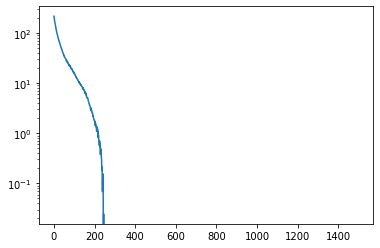

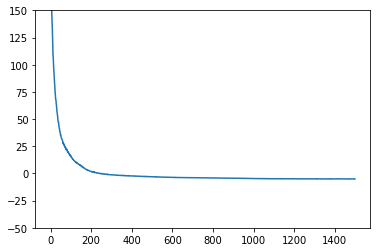


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.9531996504712946 and pval_i=0.9769105001856598
0 and 2 are independent with pval_d=0.006960559815004207 and pval_i=0.6125715775093417
0 and 3 are DEPENDENT with pval_d=1.773432532365984e-06 and pval_i=8.607292051401096e-07
0 and 4 are independent with pval_d=0.9447001213936526 and pval_i=0.9881238454751771
0 and 5 are DEPENDENT with pval_d=0.9406012220922035 and pval_i=0.003363008491189129
0 and 6 are DEPENDENT with pval_d=0.9923653270426303 and pval_i=0.08601457425462056
0 and 7 are independent with pval_d=0.3077042121785371 and pval_i=0.9978000986859258
1 and 2 are independent with pval_d=0.030913247554166964 and pval_i=0.9857006843587431
1 and 3 are DEPENDENT with pval_d=2.2720914723643086e-07 and pval_i=8.126612369869719e-08
1 and 4 are independent with pval_d=0.3330991287747459 and pval_i=0.99996856865118
1 and 5 are independent with pval_d=0.0065404694493330

  1%|          | 1/100 [00:01<02:37,  1.59s/it]

0 75.36635358631611


  2%|▏         | 2/100 [00:03<02:36,  1.59s/it]

1 71.55086129903793


  3%|▎         | 3/100 [00:04<02:34,  1.60s/it]

2 71.41398344933987


  4%|▍         | 4/100 [00:06<02:33,  1.59s/it]

3 71.39336447417736


  5%|▌         | 5/100 [00:08<02:33,  1.61s/it]

4 71.36647756397724


  6%|▌         | 6/100 [00:09<02:30,  1.60s/it]

5 71.28871171176434


  7%|▋         | 7/100 [00:11<02:29,  1.61s/it]

6 71.25327670574188


  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]

7 71.31536296010017


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 71.23744463920593


 10%|█         | 10/100 [00:16<02:24,  1.61s/it]

9 71.24738830327988


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

10 71.16053991019726


 12%|█▏        | 12/100 [00:19<02:20,  1.60s/it]

11 71.16818529367447


 13%|█▎        | 13/100 [00:20<02:20,  1.62s/it]

12 71.19265808165073


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

13 71.16136108338833


 15%|█▌        | 15/100 [00:24<02:16,  1.60s/it]

14 71.1647201180458


 16%|█▌        | 16/100 [00:25<02:15,  1.61s/it]

15 71.14924922585487


 17%|█▋        | 17/100 [00:27<02:13,  1.61s/it]

16 71.11870774626732


 18%|█▊        | 18/100 [00:28<02:11,  1.60s/it]

17 71.09891094267368


 19%|█▉        | 19/100 [00:30<02:09,  1.60s/it]

18 71.10484996438026


 20%|██        | 20/100 [00:32<02:07,  1.60s/it]

19 71.07469157874584


 21%|██        | 21/100 [00:33<02:06,  1.60s/it]

20 71.07780523598194


 22%|██▏       | 22/100 [00:35<02:04,  1.59s/it]

21 71.06792004406452


 23%|██▎       | 23/100 [00:36<02:02,  1.59s/it]

22 71.05623671412468


 24%|██▍       | 24/100 [00:38<02:02,  1.61s/it]

23 71.04897916316986


 25%|██▌       | 25/100 [00:40<01:59,  1.60s/it]

24 71.04801222681999


 26%|██▌       | 26/100 [00:41<02:00,  1.62s/it]

25 71.0458366125822


 27%|██▋       | 27/100 [00:43<01:57,  1.61s/it]

26 71.01629200577736


 28%|██▊       | 28/100 [00:44<01:55,  1.60s/it]

27 71.00923828780651


 29%|██▉       | 29/100 [00:46<01:53,  1.60s/it]

28 71.02143239974976


 30%|███       | 30/100 [00:48<01:51,  1.59s/it]

29 71.01590798795223


 31%|███       | 31/100 [00:49<01:49,  1.59s/it]

30 70.992651745677


 32%|███▏      | 32/100 [00:51<01:47,  1.59s/it]

31 71.02366223931313


 33%|███▎      | 33/100 [00:52<01:46,  1.59s/it]

32 70.98201191425323


 34%|███▍      | 34/100 [00:54<01:44,  1.59s/it]

33 71.01886786520481


 35%|███▌      | 35/100 [00:56<01:43,  1.59s/it]

34 70.98288574814796


 36%|███▌      | 36/100 [00:57<01:42,  1.59s/it]

35 71.063406214118


 37%|███▋      | 37/100 [00:59<01:40,  1.59s/it]

36 70.97297242283821


 38%|███▊      | 38/100 [01:00<01:38,  1.59s/it]

37 70.98959113657475


 39%|███▉      | 39/100 [01:02<01:36,  1.58s/it]

38 70.9829531610012


 40%|████      | 40/100 [01:03<01:34,  1.58s/it]

39 71.00667196512222


 41%|████      | 41/100 [01:05<01:33,  1.59s/it]

40 70.94153517484665


 42%|████▏     | 42/100 [01:07<01:31,  1.57s/it]

41 70.98286667466164


 43%|████▎     | 43/100 [01:08<01:30,  1.59s/it]

42 70.97000862658024


 44%|████▍     | 44/100 [01:10<01:29,  1.60s/it]

43 70.98512351512909


 45%|████▌     | 45/100 [01:11<01:27,  1.60s/it]

44 70.97765855491161


 46%|████▌     | 46/100 [01:13<01:25,  1.59s/it]

45 70.98005862534046


 47%|████▋     | 47/100 [01:15<01:25,  1.61s/it]

46 70.99169898033142


 48%|████▊     | 48/100 [01:16<01:23,  1.61s/it]

47 70.97858902812004


 49%|████▉     | 49/100 [01:18<01:21,  1.60s/it]

48 70.97520895302296


 50%|█████     | 50/100 [01:19<01:20,  1.61s/it]

49 70.9452830851078


 51%|█████     | 51/100 [01:21<01:18,  1.60s/it]

50 70.9741792678833


 52%|█████▏    | 52/100 [01:23<01:17,  1.61s/it]

51 70.97687673568726


 53%|█████▎    | 53/100 [01:24<01:15,  1.61s/it]

52 71.01993054151535


 54%|█████▍    | 54/100 [01:26<01:14,  1.61s/it]

53 70.969836384058


 55%|█████▌    | 55/100 [01:28<01:12,  1.61s/it]

54 70.97030390799046


 56%|█████▌    | 56/100 [01:29<01:10,  1.61s/it]

55 70.96267296373844


 57%|█████▋    | 57/100 [01:31<01:09,  1.61s/it]

56 70.95540124177933


 58%|█████▊    | 58/100 [01:32<01:07,  1.61s/it]

57 70.98272961378098


 59%|█████▉    | 59/100 [01:34<01:05,  1.60s/it]

58 70.96317395567894


 60%|██████    | 60/100 [01:35<01:03,  1.60s/it]

59 70.97088022530079


 61%|██████    | 61/100 [01:37<01:02,  1.60s/it]

60 70.96314008533955


 62%|██████▏   | 62/100 [01:39<01:00,  1.60s/it]

61 70.95715661346912


 63%|██████▎   | 63/100 [01:40<00:59,  1.61s/it]

62 70.95942112803459


 64%|██████▍   | 64/100 [01:42<00:58,  1.62s/it]

63 70.95563417673111


 65%|██████▌   | 65/100 [01:44<00:56,  1.60s/it]

64 70.9690303504467


 66%|██████▌   | 66/100 [01:45<00:54,  1.61s/it]

65 70.95126534998417


 67%|██████▋   | 67/100 [01:47<00:53,  1.61s/it]

66 70.95960469543934


 68%|██████▊   | 68/100 [01:48<00:51,  1.61s/it]

67 70.95578768849373


 69%|██████▉   | 69/100 [01:50<00:49,  1.60s/it]

68 70.96709248423576


 70%|███████   | 70/100 [01:52<00:47,  1.60s/it]

69 70.92477209866047


 71%|███████   | 71/100 [01:53<00:46,  1.60s/it]

70 70.98420967161655


 72%|███████▏  | 72/100 [01:55<00:44,  1.59s/it]

71 70.95129449665546


 73%|███████▎  | 73/100 [01:56<00:43,  1.60s/it]

72 70.9375613629818


 74%|███████▍  | 74/100 [01:58<00:41,  1.60s/it]

73 70.9588176459074


 75%|███████▌  | 75/100 [02:00<00:39,  1.60s/it]

74 70.98003834486008


 76%|███████▌  | 76/100 [02:01<00:38,  1.60s/it]

75 70.95461635291576


 77%|███████▋  | 77/100 [02:03<00:36,  1.60s/it]

76 70.96025283634663


 78%|███████▊  | 78/100 [02:04<00:35,  1.60s/it]

77 70.9759629368782


 79%|███████▉  | 79/100 [02:06<00:33,  1.60s/it]

78 70.94157934188843


 80%|████████  | 80/100 [02:08<00:31,  1.59s/it]

79 70.96666494011879


 81%|████████  | 81/100 [02:09<00:30,  1.59s/it]

80 70.9357360303402


 82%|████████▏ | 82/100 [02:11<00:28,  1.60s/it]

81 70.9477985650301


 83%|████████▎ | 83/100 [02:12<00:27,  1.61s/it]

82 70.96979789435863


 84%|████████▍ | 84/100 [02:14<00:25,  1.61s/it]

83 70.9595427364111


 85%|████████▌ | 85/100 [02:16<00:24,  1.61s/it]

84 70.92277450859547


 86%|████████▌ | 86/100 [02:17<00:22,  1.60s/it]

85 70.94003380835056


 87%|████████▋ | 87/100 [02:19<00:20,  1.60s/it]

86 70.96367800235748


 88%|████████▊ | 88/100 [02:20<00:19,  1.61s/it]

87 70.95433066785336


 89%|████████▉ | 89/100 [02:22<00:17,  1.61s/it]

88 70.9620289504528


 90%|█████████ | 90/100 [02:24<00:16,  1.60s/it]

89 70.95117652416229


 91%|█████████ | 91/100 [02:25<00:14,  1.59s/it]

90 70.96053530275822


 92%|█████████▏| 92/100 [02:27<00:12,  1.60s/it]

91 70.91866427659988


 93%|█████████▎| 93/100 [02:28<00:11,  1.59s/it]

92 70.96642398834229


 94%|█████████▍| 94/100 [02:30<00:09,  1.59s/it]

93 70.92644311487675


 95%|█████████▌| 95/100 [02:31<00:07,  1.59s/it]

94 70.94898104667664


 96%|█████████▌| 96/100 [02:33<00:06,  1.60s/it]

95 70.92433603107929


 97%|█████████▋| 97/100 [02:35<00:04,  1.60s/it]

96 70.96264301240444


 98%|█████████▊| 98/100 [02:36<00:03,  1.61s/it]

97 70.92015087604523


 99%|█████████▉| 99/100 [02:38<00:01,  1.61s/it]

98 70.95813730359077


100%|██████████| 100/100 [02:40<00:00,  1.60s/it]

99 70.95757637917995

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.08539477735757828	

epoch 9000/10000, policy loss 0.049688663333654404	
***** test student *****
epoch 0/100 return: 9.0
epoch 1/100 return: 10.0
epoch 2/100 return: 10.0
epoch 3/100 return: 10.0
epoch 4/100 return: 8.0
epoch 5/100 return: 10.0
epoch 6/100 return: 8.0
epoch 7/100 return: 10.0
epoch 8/100 return: 10.0
epoch 9/100 return: 10.0
epoch 10/100 return: 10.0
epoch 11/100 return: 10.0
epoch 12/100 return: 8.0
epoch 13/100 return: 10.0
epoch 14/100 return: 9.0
epoch 15/100 return: 9.0
epoch 16/100 return: 10.0
epoch 17/100 return: 9.0
epoch 18/100 return: 10.0
epoch 19/100 return: 8.0
epoch 20/100 return: 9.0
epoch 21/100 return: 9.0
epoch 22/100 return: 10.0
epoch 23/100 return: 9.0
epoch 24/100 return: 10.0
epoch 25/100 return: 10.0
epoch 26/100 return: 9.0
epoch 27/100 return: 10.0
epoch 28/100 return: 10.0
epoch 29/100 return: 10.0
epoch 30/100 return: 8.0
epoch 31/100 return: 9.0
epoch 32/100 return: 9.0
epoch 33/100 return: 10.0
epoch 34/100 return: 9.0
epoch 35/100 return: 10.0
epoch 36/100 

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.946319103240967best loss model loaded, stored at update # 1436


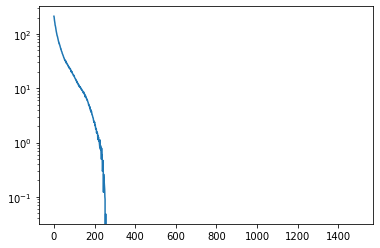

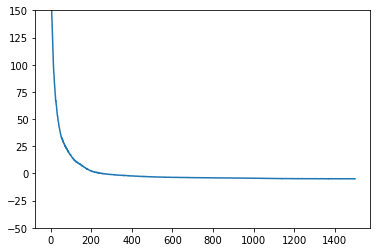


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.2511887132485613 and pval_i=0.9604303302578641
0 and 2 are independent with pval_d=0.050288964644298564 and pval_i=0.9991155601113703
0 and 3 are DEPENDENT with pval_d=8.021252452822925e-07 and pval_i=5.727812644859863e-07
0 and 4 are independent with pval_d=0.7804757634433309 and pval_i=0.9685103435494393
0 and 5 are DEPENDENT with pval_d=0.998954321886631 and pval_i=0.04617677678575714
0 and 6 are DEPENDENT with pval_d=0.7308170856532743 and pval_i=0.10793584578636549
0 and 7 are independent with pval_d=0.03806586863595781 and pval_i=0.9663133615041494
1 and 2 are independent with pval_d=0.09143526938886348 and pval_i=0.8931208286512663
1 and 3 are DEPENDENT with pval_d=1.1841873425289201e-07 and pval_i=4.942769426209363e-09
1 and 4 are independent with pval_d=0.6442809362633654 and pval_i=0.9129709069173609
1 and 5 are independent with pval_d=0.2583867951682151

  1%|          | 1/100 [00:01<02:36,  1.59s/it]

0 76.05485093593597


  2%|▏         | 2/100 [00:03<02:36,  1.60s/it]

1 72.35302326083183


  3%|▎         | 3/100 [00:04<02:35,  1.60s/it]

2 72.26847225427628


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

3 72.25188298523426


  5%|▌         | 5/100 [00:08<02:32,  1.60s/it]

4 72.19357036054134


  6%|▌         | 6/100 [00:09<02:31,  1.61s/it]

5 72.11519184708595


  7%|▋         | 7/100 [00:11<02:29,  1.60s/it]

6 72.0643649250269


  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]

7 72.07824802398682


  9%|▉         | 9/100 [00:14<02:25,  1.60s/it]

8 72.06221836805344


 10%|█         | 10/100 [00:15<02:23,  1.59s/it]

9 72.03020079433918


 11%|█         | 11/100 [00:17<02:21,  1.59s/it]

10 71.95543509721756


 12%|█▏        | 12/100 [00:19<02:19,  1.58s/it]

11 71.9690493941307


 13%|█▎        | 13/100 [00:20<02:17,  1.59s/it]

12 72.01784402132034


 14%|█▍        | 14/100 [00:22<02:16,  1.58s/it]

13 71.95664803683758


 15%|█▌        | 15/100 [00:23<02:16,  1.60s/it]

14 71.95093375444412


 16%|█▌        | 16/100 [00:25<02:14,  1.60s/it]

15 71.90425877273083


 17%|█▋        | 17/100 [00:27<02:12,  1.59s/it]

16 71.92608749866486


 18%|█▊        | 18/100 [00:28<02:10,  1.59s/it]

17 71.9096485376358


 19%|█▉        | 19/100 [00:30<02:08,  1.59s/it]

18 71.89317236840725


 20%|██        | 20/100 [00:31<02:07,  1.59s/it]

19 71.87748615443707


 21%|██        | 21/100 [00:33<02:06,  1.60s/it]

20 71.88616771996021


 22%|██▏       | 22/100 [00:35<02:03,  1.59s/it]

21 71.8558369576931


 23%|██▎       | 23/100 [00:36<02:01,  1.58s/it]

22 71.8574118167162


 24%|██▍       | 24/100 [00:38<02:00,  1.58s/it]

23 71.85469587147236


 25%|██▌       | 25/100 [00:39<01:58,  1.58s/it]

24 71.85854230821133


 26%|██▌       | 26/100 [00:41<01:57,  1.58s/it]

25 71.84262646734715


 27%|██▋       | 27/100 [00:43<01:56,  1.60s/it]

26 71.83899360895157


 28%|██▊       | 28/100 [00:44<01:55,  1.60s/it]

27 71.83997413516045


 29%|██▉       | 29/100 [00:46<01:53,  1.60s/it]

28 71.82754203677177


 30%|███       | 30/100 [00:47<01:51,  1.59s/it]

29 71.80857123434544


 31%|███       | 31/100 [00:49<01:49,  1.59s/it]

30 71.80038315057755


 32%|███▏      | 32/100 [00:51<01:49,  1.60s/it]

31 71.84117420017719


 33%|███▎      | 33/100 [00:52<01:46,  1.59s/it]

32 71.80830861628056


 34%|███▍      | 34/100 [00:54<01:46,  1.62s/it]

33 71.82511526346207


 35%|███▌      | 35/100 [00:55<01:45,  1.62s/it]

34 71.77495367825031


 36%|███▌      | 36/100 [00:57<01:43,  1.62s/it]

35 71.81615330278873


 37%|███▋      | 37/100 [00:59<01:42,  1.63s/it]

36 71.77021668851376


 38%|███▊      | 38/100 [01:00<01:40,  1.63s/it]

37 71.78035125136375


 39%|███▉      | 39/100 [01:02<01:38,  1.62s/it]

38 71.78537029027939


 40%|████      | 40/100 [01:03<01:36,  1.61s/it]

39 71.81603659689426


 41%|████      | 41/100 [01:05<01:35,  1.61s/it]

40 71.73267742991447


 42%|████▏     | 42/100 [01:07<01:33,  1.61s/it]

41 71.7769645601511


 43%|████▎     | 43/100 [01:08<01:32,  1.62s/it]

42 71.7634738534689


 44%|████▍     | 44/100 [01:10<01:30,  1.61s/it]

43 71.78788603842258


 45%|████▌     | 45/100 [01:12<01:28,  1.60s/it]

44 71.77534781396389


 46%|████▌     | 46/100 [01:13<01:26,  1.60s/it]

45 71.79695595800877


 47%|████▋     | 47/100 [01:15<01:25,  1.62s/it]

46 71.78169703483582


 48%|████▊     | 48/100 [01:16<01:23,  1.62s/it]

47 71.78835858404636


 49%|████▉     | 49/100 [01:18<01:21,  1.60s/it]

48 71.76429042220116


 50%|█████     | 50/100 [01:20<01:20,  1.60s/it]

49 71.76120546460152


 51%|█████     | 51/100 [01:21<01:18,  1.61s/it]

50 71.77358250319958


 52%|█████▏    | 52/100 [01:23<01:16,  1.60s/it]

51 71.77623222768307


 53%|█████▎    | 53/100 [01:24<01:16,  1.62s/it]

52 71.8169881105423


 54%|█████▍    | 54/100 [01:26<01:14,  1.62s/it]

53 71.78896382451057


 55%|█████▌    | 55/100 [01:28<01:13,  1.64s/it]

54 71.75828970968723


 56%|█████▌    | 56/100 [01:29<01:12,  1.66s/it]

55 71.76610504090786


 57%|█████▋    | 57/100 [01:31<01:10,  1.64s/it]

56 71.76001703739166


 58%|█████▊    | 58/100 [01:33<01:08,  1.64s/it]

57 71.77670562267303


 59%|█████▉    | 59/100 [01:34<01:06,  1.62s/it]

58 71.78479611873627


 60%|██████    | 60/100 [01:36<01:04,  1.61s/it]

59 71.75432305037975


 61%|██████    | 61/100 [01:37<01:02,  1.61s/it]

60 71.78207927942276


 62%|██████▏   | 62/100 [01:39<01:01,  1.62s/it]

61 71.75264590978622


 63%|██████▎   | 63/100 [01:41<00:59,  1.61s/it]

62 71.76619616150856


 64%|██████▍   | 64/100 [01:42<00:57,  1.60s/it]

63 71.74227331578732


 65%|██████▌   | 65/100 [01:44<00:55,  1.60s/it]

64 71.76788288354874


 66%|██████▌   | 66/100 [01:45<00:54,  1.60s/it]

65 71.77799989283085


 67%|██████▋   | 67/100 [01:47<00:52,  1.59s/it]

66 71.74731762707233


 68%|██████▊   | 68/100 [01:49<00:50,  1.59s/it]

67 71.7318372130394


 69%|██████▉   | 69/100 [01:50<00:49,  1.60s/it]

68 71.7645575106144


 70%|███████   | 70/100 [01:52<00:47,  1.59s/it]

69 71.73793411254883


 71%|███████   | 71/100 [01:53<00:46,  1.60s/it]

70 71.77632567286491


 72%|███████▏  | 72/100 [01:55<00:44,  1.60s/it]

71 71.74824896454811


 73%|███████▎  | 73/100 [01:57<00:43,  1.62s/it]

72 71.75859744846821


 74%|███████▍  | 74/100 [01:58<00:42,  1.62s/it]

73 71.75942727923393


 75%|███████▌  | 75/100 [02:00<00:40,  1.62s/it]

74 71.76950071752071


 76%|███████▌  | 76/100 [02:02<00:38,  1.61s/it]

75 71.77081269025803


 77%|███████▋  | 77/100 [02:03<00:37,  1.61s/it]

76 71.74811245501041


 78%|███████▊  | 78/100 [02:05<00:35,  1.61s/it]

77 71.77619896829128


 79%|███████▉  | 79/100 [02:06<00:33,  1.61s/it]

78 71.76161773502827


 80%|████████  | 80/100 [02:08<00:32,  1.61s/it]

79 71.75396874547005


 81%|████████  | 81/100 [02:10<00:30,  1.60s/it]

80 71.75111111998558


 82%|████████▏ | 82/100 [02:11<00:28,  1.59s/it]

81 71.74791833758354


 83%|████████▎ | 83/100 [02:13<00:26,  1.58s/it]

82 71.7882374972105


 84%|████████▍ | 84/100 [02:14<00:25,  1.59s/it]

83 71.74919684231281


 85%|████████▌ | 85/100 [02:16<00:23,  1.60s/it]

84 71.75812666118145


 86%|████████▌ | 86/100 [02:18<00:22,  1.60s/it]

85 71.74088460206985


 87%|████████▋ | 87/100 [02:19<00:20,  1.61s/it]

86 71.77773447334766


 88%|████████▊ | 88/100 [02:21<00:19,  1.61s/it]

87 71.7486689388752


 89%|████████▉ | 89/100 [02:22<00:17,  1.62s/it]

88 71.76671507954597


 90%|█████████ | 90/100 [02:24<00:16,  1.61s/it]

89 71.76666615903378


 91%|█████████ | 91/100 [02:26<00:14,  1.62s/it]

90 71.7780806273222


 92%|█████████▏| 92/100 [02:27<00:12,  1.62s/it]

91 71.71745923161507


 93%|█████████▎| 93/100 [02:29<00:11,  1.63s/it]

92 71.76403522491455


 94%|█████████▍| 94/100 [02:30<00:09,  1.62s/it]

93 71.74009323120117


 95%|█████████▌| 95/100 [02:32<00:08,  1.62s/it]

94 71.75506214797497


 96%|█████████▌| 96/100 [02:34<00:06,  1.61s/it]

95 71.73520374298096


 97%|█████████▋| 97/100 [02:35<00:04,  1.60s/it]

96 71.77330510318279


 98%|█████████▊| 98/100 [02:37<00:03,  1.60s/it]

97 71.71953555941582


 99%|█████████▉| 99/100 [02:38<00:01,  1.61s/it]

98 71.75706009566784


100%|██████████| 100/100 [02:40<00:00,  1.61s/it]

99 71.76561768352985

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07526560127735138	

epoch 9000/10000, policy loss 0.04901483654975891	
***** test student *****
epoch 0/100 return: 18.0
epoch 1/100 return: 23.0
epoch 2/100 return: 17.0
epoch 3/100 return: 18.0
epoch 4/100 return: 18.0
epoch 5/100 return: 16.0
epoch 6/100 return: 18.0
epoch 7/100 return: 22.0
epoch 8/100 return: 19.0
epoch 9/100 return: 21.0
epoch 10/100 return: 20.0
epoch 11/100 return: 18.0
epoch 12/100 return: 22.0
epoch 13/100 return: 20.0
epoch 14/100 return: 22.0
epoch 15/100 return: 23.0
epoch 16/100 return: 25.0
epoch 17/100 return: 23.0
epoch 18/100 return: 28.0
epoch 19/100 return: 26.0
epoch 20/100 return: 24.0
epoch 21/100 return: 20.0
epoch 22/100 return: 21.0
epoch 23/100 return: 17.0
epoch 24/100 return: 26.0
epoch 25/100 return: 24.0
epoch 26/100 return: 19.0
epoch 27/100 return: 22.0
epoch 28/100 return: 25.0
epoch 29/100 return: 22.0
epoch 30/100 return: 20.0
epoch 31/100 return: 24.0
epoch 32/100 return: 19.0
epoch 33/100 return: 21.0
epoch 34/100 return: 23.0
epoch 35/100 return: 26.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.837810516357422best loss model loaded, stored at update # 1487


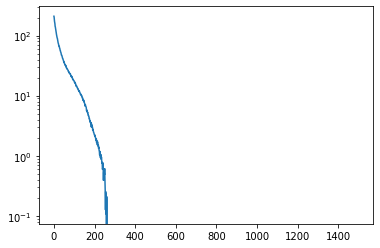

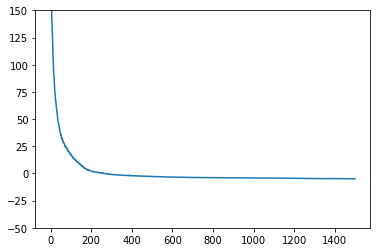


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.42173018756543995 and pval_i=0.9924137686521187
0 and 2 are independent with pval_d=0.0021729090582268133 and pval_i=0.7047943084301087
0 and 3 are independent with pval_d=1.182622511801789e-07 and pval_i=2.8006332660722265e-07
0 and 4 are DEPENDENT with pval_d=0.9998810950984814 and pval_i=0.9984103495372417
0 and 5 are DEPENDENT with pval_d=0.9207368510265783 and pval_i=0.7044803863201278
0 and 6 are independent with pval_d=0.006643681143609743 and pval_i=0.16410824608110344
0 and 7 are independent with pval_d=0.03673872554484958 and pval_i=0.9453619660170668
1 and 2 are independent with pval_d=0.0028436565732735384 and pval_i=0.9197516564767506
1 and 3 are DEPENDENT with pval_d=1.6062748223000762e-07 and pval_i=5.6062782602309214e-08
1 and 4 are independent with pval_d=0.30143171506098576 and pval_i=0.9402576544969883
1 and 5 are DEPENDENT with pval_d=0.3649774

  1%|          | 1/100 [00:01<02:38,  1.60s/it]

0 69.6825442314148


  2%|▏         | 2/100 [00:03<02:37,  1.61s/it]

1 66.82654072344303


  3%|▎         | 3/100 [00:04<02:35,  1.61s/it]

2 66.63316515088081


  4%|▍         | 4/100 [00:06<02:33,  1.59s/it]

3 66.59605313837528


  5%|▌         | 5/100 [00:07<02:31,  1.60s/it]

4 66.60990191996098


  6%|▌         | 6/100 [00:09<02:29,  1.59s/it]

5 66.5103365033865


  7%|▋         | 7/100 [00:11<02:28,  1.60s/it]

6 66.47484713792801


  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]

7 66.49516938626766


  9%|▉         | 9/100 [00:14<02:25,  1.60s/it]

8 66.45457071065903


 10%|█         | 10/100 [00:15<02:23,  1.60s/it]

9 66.47299359738827


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

10 66.37157380580902


 12%|█▏        | 12/100 [00:19<02:21,  1.60s/it]

11 66.39186097681522


 13%|█▎        | 13/100 [00:20<02:18,  1.59s/it]

12 66.40889471769333


 14%|█▍        | 14/100 [00:22<02:17,  1.60s/it]

13 66.40064208954573


 15%|█▌        | 15/100 [00:24<02:17,  1.62s/it]

14 66.38888244330883


 16%|█▌        | 16/100 [00:25<02:16,  1.62s/it]

15 66.34294274449348


 17%|█▋        | 17/100 [00:27<02:13,  1.61s/it]

16 66.33618807792664


 18%|█▊        | 18/100 [00:28<02:11,  1.61s/it]

17 66.32799731194973


 19%|█▉        | 19/100 [00:30<02:09,  1.60s/it]

18 66.3233239799738


 20%|██        | 20/100 [00:32<02:07,  1.59s/it]

19 66.31296141445637


 21%|██        | 21/100 [00:33<02:06,  1.60s/it]

20 66.30044062435627


 22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]

21 66.30792750418186


 23%|██▎       | 23/100 [00:36<02:03,  1.60s/it]

22 66.31323871016502


 24%|██▍       | 24/100 [00:38<02:01,  1.60s/it]

23 66.27850466966629


 25%|██▌       | 25/100 [00:40<02:00,  1.61s/it]

24 66.29322074353695


 26%|██▌       | 26/100 [00:41<01:58,  1.60s/it]

25 66.27744548022747


 27%|██▋       | 27/100 [00:43<01:56,  1.59s/it]

26 66.25017055124044


 28%|██▊       | 28/100 [00:44<01:54,  1.59s/it]

27 66.2798006683588


 29%|██▉       | 29/100 [00:46<01:52,  1.59s/it]

28 66.26637552678585


 30%|███       | 30/100 [00:48<01:51,  1.59s/it]

29 66.27538384497166


 31%|███       | 31/100 [00:49<01:49,  1.58s/it]

30 66.24205096065998


 32%|███▏      | 32/100 [00:51<01:47,  1.59s/it]

31 66.26901526749134


 33%|███▎      | 33/100 [00:52<01:46,  1.59s/it]

32 66.25538893043995


 34%|███▍      | 34/100 [00:54<01:44,  1.58s/it]

33 66.2605592906475


 35%|███▌      | 35/100 [00:55<01:44,  1.60s/it]

34 66.22418966144323


 36%|███▌      | 36/100 [00:57<01:42,  1.60s/it]

35 66.28202676773071


 37%|███▋      | 37/100 [00:59<01:42,  1.62s/it]

36 66.25287592411041


 38%|███▊      | 38/100 [01:00<01:39,  1.60s/it]

37 66.25461359322071


 39%|███▉      | 39/100 [01:02<01:38,  1.61s/it]

38 66.2363271266222


 40%|████      | 40/100 [01:04<01:36,  1.60s/it]

39 66.26737603545189


 41%|████      | 41/100 [01:05<01:35,  1.62s/it]

40 66.21893899142742


 42%|████▏     | 42/100 [01:07<01:33,  1.61s/it]

41 66.23838602006435


 43%|████▎     | 43/100 [01:08<01:31,  1.61s/it]

42 66.23838219046593


 44%|████▍     | 44/100 [01:10<01:30,  1.61s/it]

43 66.24989156424999


 45%|████▌     | 45/100 [01:12<01:28,  1.61s/it]

44 66.24968187510967


 46%|████▌     | 46/100 [01:13<01:26,  1.60s/it]

45 66.22790412604809


 47%|████▋     | 47/100 [01:15<01:24,  1.60s/it]

46 66.26005506515503


 48%|████▊     | 48/100 [01:16<01:23,  1.60s/it]

47 66.22004860639572


 49%|████▉     | 49/100 [01:18<01:21,  1.59s/it]

48 66.25811637938023


 50%|█████     | 50/100 [01:20<01:19,  1.60s/it]

49 66.22879987955093


 51%|█████     | 51/100 [01:21<01:18,  1.59s/it]

50 66.22852046787739


 52%|█████▏    | 52/100 [01:23<01:16,  1.59s/it]

51 66.2308187186718


 53%|█████▎    | 53/100 [01:24<01:14,  1.59s/it]

52 66.25127524137497


 54%|█████▍    | 54/100 [01:26<01:13,  1.59s/it]

53 66.24284745752811


 55%|█████▌    | 55/100 [01:27<01:11,  1.59s/it]

54 66.25027567148209


 56%|█████▌    | 56/100 [01:29<01:10,  1.60s/it]

55 66.21687617897987


 57%|█████▋    | 57/100 [01:31<01:09,  1.61s/it]

56 66.25270639359951


 58%|█████▊    | 58/100 [01:32<01:07,  1.60s/it]

57 66.22616830468178


 59%|█████▉    | 59/100 [01:34<01:05,  1.60s/it]

58 66.26278522610664


 60%|██████    | 60/100 [01:36<01:04,  1.62s/it]

59 66.20962133258581


 61%|██████    | 61/100 [01:37<01:02,  1.61s/it]

60 66.23735575377941


 62%|██████▏   | 62/100 [01:39<01:00,  1.60s/it]

61 66.22990302741528


 63%|██████▎   | 63/100 [01:40<00:59,  1.60s/it]

62 66.2369279563427


 64%|██████▍   | 64/100 [01:42<00:57,  1.60s/it]

63 66.21263916790485


 65%|██████▌   | 65/100 [01:44<00:56,  1.60s/it]

64 66.21561229974031


 66%|██████▌   | 66/100 [01:45<00:54,  1.61s/it]

65 66.23325338959694


 67%|██████▋   | 67/100 [01:47<00:53,  1.62s/it]

66 66.21785114705563


 68%|██████▊   | 68/100 [01:48<00:52,  1.63s/it]

67 66.19705525040627


 69%|██████▉   | 69/100 [01:50<00:50,  1.63s/it]

68 66.21723844110966


 70%|███████   | 70/100 [01:52<00:48,  1.62s/it]

69 66.20339389145374


 71%|███████   | 71/100 [01:53<00:46,  1.62s/it]

70 66.21330320835114


 72%|███████▏  | 72/100 [01:55<00:45,  1.62s/it]

71 66.20340472459793


 73%|███████▎  | 73/100 [01:57<00:43,  1.62s/it]

72 66.21012777090073


 74%|███████▍  | 74/100 [01:58<00:41,  1.60s/it]

73 66.23918795585632


 75%|███████▌  | 75/100 [02:00<00:40,  1.61s/it]

74 66.2301615178585


 76%|███████▌  | 76/100 [02:01<00:39,  1.63s/it]

75 66.2281124740839


 77%|███████▋  | 77/100 [02:03<00:37,  1.62s/it]

76 66.2106594890356


 78%|███████▊  | 78/100 [02:05<00:35,  1.62s/it]

77 66.23206421732903


 79%|███████▉  | 79/100 [02:06<00:34,  1.63s/it]

78 66.21655751764774


 80%|████████  | 80/100 [02:08<00:32,  1.63s/it]

79 66.21395196020603


 81%|████████  | 81/100 [02:10<00:30,  1.62s/it]

80 66.21740332245827


 82%|████████▏ | 82/100 [02:11<00:28,  1.61s/it]

81 66.21191847324371


 83%|████████▎ | 83/100 [02:13<00:27,  1.61s/it]

82 66.2329880297184


 84%|████████▍ | 84/100 [02:14<00:25,  1.61s/it]

83 66.23273652791977


 85%|████████▌ | 85/100 [02:16<00:24,  1.60s/it]

84 66.18710611760616


 86%|████████▌ | 86/100 [02:17<00:22,  1.59s/it]

85 66.23721286654472


 87%|████████▋ | 87/100 [02:19<00:20,  1.59s/it]

86 66.21662274003029


 88%|████████▊ | 88/100 [02:21<00:19,  1.58s/it]

87 66.2220767736435


 89%|████████▉ | 89/100 [02:22<00:17,  1.60s/it]

88 66.24214516580105


 90%|█████████ | 90/100 [02:24<00:16,  1.60s/it]

89 66.2074613571167


 91%|█████████ | 91/100 [02:25<00:14,  1.60s/it]

90 66.22894833981991


 92%|█████████▏| 92/100 [02:27<00:12,  1.61s/it]

91 66.1875659674406


 93%|█████████▎| 93/100 [02:29<00:11,  1.62s/it]

92 66.24625441431999


 94%|█████████▍| 94/100 [02:30<00:09,  1.62s/it]

93 66.20326338708401


 95%|█████████▌| 95/100 [02:32<00:08,  1.63s/it]

94 66.23776821792126


 96%|█████████▌| 96/100 [02:34<00:06,  1.61s/it]

95 66.20026682317257


 97%|█████████▋| 97/100 [02:35<00:04,  1.61s/it]

96 66.40441384911537


 98%|█████████▊| 98/100 [02:37<00:03,  1.61s/it]

97 66.2060367912054


 99%|█████████▉| 99/100 [02:38<00:01,  1.61s/it]

98 66.20110537111759


100%|██████████| 100/100 [02:40<00:00,  1.61s/it]

99 66.21579492092133

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07533925026655197	

epoch 9000/10000, policy loss 0.05624529719352722	
***** test student *****
epoch 0/100 return: 14.0
epoch 1/100 return: 15.0
epoch 2/100 return: 18.0
epoch 3/100 return: 14.0
epoch 4/100 return: 15.0
epoch 5/100 return: 19.0
epoch 6/100 return: 21.0
epoch 7/100 return: 15.0
epoch 8/100 return: 16.0
epoch 9/100 return: 19.0
epoch 10/100 return: 15.0
epoch 11/100 return: 17.0
epoch 12/100 return: 18.0
epoch 13/100 return: 15.0
epoch 14/100 return: 21.0
epoch 15/100 return: 17.0
epoch 16/100 return: 18.0
epoch 17/100 return: 17.0
epoch 18/100 return: 14.0
epoch 19/100 return: 19.0
epoch 20/100 return: 19.0
epoch 21/100 return: 16.0
epoch 22/100 return: 19.0
epoch 23/100 return: 13.0
epoch 24/100 return: 16.0
epoch 25/100 return: 19.0
epoch 26/100 return: 18.0
epoch 27/100 return: 17.0
epoch 28/100 return: 19.0
epoch 29/100 return: 19.0
epoch 30/100 return: 16.0
epoch 31/100 return: 18.0
epoch 32/100 return: 15.0
epoch 33/100 return: 19.0
epoch 34/100 return: 15.0
epoch 35/100 return: 13.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.699431896209717best loss model loaded, stored at update # 1487


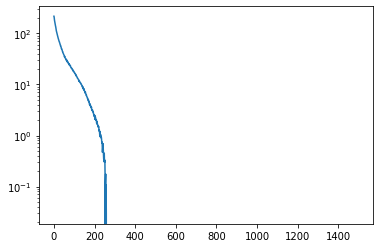

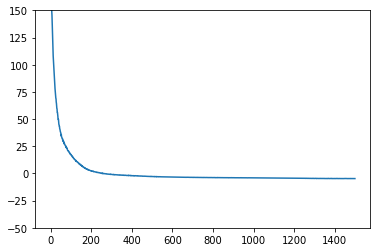


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.906050384299321 and pval_i=0.9965309793652888
0 and 2 are independent with pval_d=0.1886850101333074 and pval_i=0.9983258327674291
0 and 3 are independent with pval_d=1.405982078550584e-06 and pval_i=1.9891196988128232e-06
0 and 4 are independent with pval_d=0.9536048674385361 and pval_i=0.9999471835069614
0 and 5 are independent with pval_d=0.2241646188951782 and pval_i=0.9120694806887919
0 and 6 are independent with pval_d=0.061992803383382825 and pval_i=0.8000860888414902
0 and 7 are independent with pval_d=0.9432977764553845 and pval_i=0.9986494063146717
1 and 2 are independent with pval_d=0.4516877467412837 and pval_i=0.9983220484253181
1 and 3 are DEPENDENT with pval_d=8.929460134327825e-06 and pval_i=6.559912041025919e-08
1 and 4 are independent with pval_d=0.744305924281095 and pval_i=0.9996135474619444
1 and 5 are independent with pval_d=0.005317088454670

  1%|          | 1/100 [00:01<02:36,  1.58s/it]

0 74.68892553448677


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

1 71.46204479038715


  3%|▎         | 3/100 [00:04<02:33,  1.58s/it]

2 71.28264804184437


  4%|▍         | 4/100 [00:06<02:31,  1.58s/it]

3 71.25374287366867


  5%|▌         | 5/100 [00:07<02:29,  1.58s/it]

4 71.2878001332283


  6%|▌         | 6/100 [00:09<02:29,  1.59s/it]

5 71.1680247336626


  7%|▋         | 7/100 [00:11<02:28,  1.59s/it]

6 71.13947802782059


  8%|▊         | 8/100 [00:12<02:29,  1.62s/it]

7 71.14897514879704


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 71.11436605453491


 10%|█         | 10/100 [00:16<02:27,  1.64s/it]

9 71.1277627646923


 11%|█         | 11/100 [00:17<02:24,  1.63s/it]

10 71.0251204520464


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 71.05285011231899


 13%|█▎        | 13/100 [00:20<02:20,  1.62s/it]

12 71.08122216165066


 14%|█▍        | 14/100 [00:22<02:19,  1.63s/it]

13 71.05170120298862


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 71.04140251874924


 16%|█▌        | 16/100 [00:25<02:15,  1.62s/it]

15 71.03080506622791


 17%|█▋        | 17/100 [00:27<02:14,  1.63s/it]

16 70.99627313017845


 18%|█▊        | 18/100 [00:29<02:13,  1.62s/it]

17 70.98724141716957


 19%|█▉        | 19/100 [00:30<02:11,  1.62s/it]

18 70.99066413938999


 20%|██        | 20/100 [00:32<02:08,  1.61s/it]

19 70.96937008202076


 21%|██        | 21/100 [00:33<02:06,  1.61s/it]

20 70.97216865420341


 22%|██▏       | 22/100 [00:35<02:04,  1.60s/it]

21 70.93786211311817


 23%|██▎       | 23/100 [00:37<02:03,  1.60s/it]

22 70.97660763561726


 24%|██▍       | 24/100 [00:38<02:01,  1.60s/it]

23 70.94901432096958


 25%|██▌       | 25/100 [00:40<01:59,  1.59s/it]

24 70.94918674230576


 26%|██▌       | 26/100 [00:41<01:57,  1.59s/it]

25 70.93080355226994


 27%|██▋       | 27/100 [00:43<01:57,  1.61s/it]

26 70.86453837156296


 28%|██▊       | 28/100 [00:45<01:56,  1.61s/it]

27 70.91205708682537


 29%|██▉       | 29/100 [00:46<01:55,  1.62s/it]

28 70.9104980379343


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 70.87604476511478


 31%|███       | 31/100 [00:49<01:51,  1.61s/it]

30 70.88504084944725


 32%|███▏      | 32/100 [00:51<01:49,  1.60s/it]

31 70.91386377811432


 33%|███▎      | 33/100 [00:53<01:47,  1.60s/it]

32 70.84057547152042


 34%|███▍      | 34/100 [00:54<01:46,  1.62s/it]

33 70.91588804125786


 35%|███▌      | 35/100 [00:56<01:45,  1.62s/it]

34 70.83812516927719


 36%|███▌      | 36/100 [00:57<01:43,  1.62s/it]

35 70.8861555159092


 37%|███▋      | 37/100 [00:59<01:41,  1.61s/it]

36 70.84854528307915


 38%|███▊      | 38/100 [01:01<01:39,  1.61s/it]

37 70.85036838054657


 39%|███▉      | 39/100 [01:02<01:37,  1.60s/it]

38 70.83741565048695


 40%|████      | 40/100 [01:04<01:36,  1.61s/it]

39 70.87523305416107


 41%|████      | 41/100 [01:05<01:34,  1.60s/it]

40 70.79791335761547


 42%|████▏     | 42/100 [01:07<01:32,  1.60s/it]

41 70.8114533573389


 43%|████▎     | 43/100 [01:09<01:31,  1.60s/it]

42 70.82860678434372


 44%|████▍     | 44/100 [01:10<01:29,  1.59s/it]

43 70.84154960513115


 45%|████▌     | 45/100 [01:12<01:27,  1.59s/it]

44 70.80762127041817


 46%|████▌     | 46/100 [01:13<01:26,  1.60s/it]

45 70.84392304718494


 47%|████▋     | 47/100 [01:15<01:25,  1.61s/it]

46 70.80685044825077


 48%|████▊     | 48/100 [01:17<01:23,  1.61s/it]

47 70.81299078464508


 49%|████▉     | 49/100 [01:18<01:22,  1.62s/it]

48 70.8511488288641


 50%|█████     | 50/100 [01:20<01:21,  1.62s/it]

49 70.79691869020462


 51%|█████     | 51/100 [01:22<01:18,  1.61s/it]

50 70.79729008674622


 52%|█████▏    | 52/100 [01:23<01:17,  1.61s/it]

51 70.82147248089314


 53%|█████▎    | 53/100 [01:25<01:15,  1.60s/it]

52 70.83697424829006


 54%|█████▍    | 54/100 [01:26<01:13,  1.61s/it]

53 70.8327412456274


 55%|█████▌    | 55/100 [01:28<01:12,  1.62s/it]

54 70.80406565964222


 56%|█████▌    | 56/100 [01:30<01:10,  1.61s/it]

55 70.82670247554779


 57%|█████▋    | 57/100 [01:31<01:08,  1.60s/it]

56 70.80147382616997


 58%|█████▊    | 58/100 [01:33<01:07,  1.61s/it]

57 70.81787687540054


 59%|█████▉    | 59/100 [01:34<01:05,  1.60s/it]

58 70.81272535026073


 60%|██████    | 60/100 [01:36<01:04,  1.61s/it]

59 70.81032057106495


 61%|██████    | 61/100 [01:38<01:02,  1.61s/it]

60 70.80113844573498


 62%|██████▏   | 62/100 [01:39<01:01,  1.62s/it]

61 70.80764311552048


 63%|██████▎   | 63/100 [01:41<00:59,  1.61s/it]

62 70.80632318556309


 64%|██████▍   | 64/100 [01:42<00:57,  1.61s/it]

63 70.79684802889824


 65%|██████▌   | 65/100 [01:44<00:56,  1.61s/it]

64 70.79936185479164


 66%|██████▌   | 66/100 [01:46<00:54,  1.62s/it]

65 70.79320488870144


 67%|██████▋   | 67/100 [01:47<00:53,  1.61s/it]

66 70.80374348163605


 68%|██████▊   | 68/100 [01:49<00:51,  1.61s/it]

67 70.81422199308872


 69%|██████▉   | 69/100 [01:51<00:49,  1.61s/it]

68 70.7938404083252


 70%|███████   | 70/100 [01:52<00:47,  1.60s/it]

69 70.77766075730324


 71%|███████   | 71/100 [01:54<00:46,  1.60s/it]

70 70.81887103617191


 72%|███████▏  | 72/100 [01:55<00:44,  1.60s/it]

71 70.79108954966068


 73%|███████▎  | 73/100 [01:57<00:43,  1.60s/it]

72 70.77835230529308


 74%|███████▍  | 74/100 [01:59<00:41,  1.61s/it]

73 70.78681434690952


 75%|███████▌  | 75/100 [02:00<00:40,  1.61s/it]

74 70.80506862699986


 76%|███████▌  | 76/100 [02:02<00:38,  1.60s/it]

75 70.80540291965008


 77%|███████▋  | 77/100 [02:03<00:37,  1.61s/it]

76 70.82049867510796


 78%|███████▊  | 78/100 [02:05<00:35,  1.61s/it]

77 70.81590916216373


 79%|███████▉  | 79/100 [02:07<00:33,  1.61s/it]

78 70.79211130738258


 80%|████████  | 80/100 [02:08<00:32,  1.62s/it]

79 70.79112550616264


 81%|████████  | 81/100 [02:10<00:30,  1.61s/it]

80 70.78991688787937


 82%|████████▏ | 82/100 [02:11<00:28,  1.61s/it]

81 70.79158192873001


 83%|████████▎ | 83/100 [02:13<00:27,  1.60s/it]

82 70.80173288285732


 84%|████████▍ | 84/100 [02:15<00:25,  1.61s/it]

83 70.81406147778034


 85%|████████▌ | 85/100 [02:16<00:24,  1.62s/it]

84 70.79617753624916


 86%|████████▌ | 86/100 [02:18<00:22,  1.62s/it]

85 70.78950808942318


 87%|████████▋ | 87/100 [02:20<00:21,  1.62s/it]

86 70.80498731136322


 88%|████████▊ | 88/100 [02:21<00:19,  1.62s/it]

87 70.78913758695126


 89%|████████▉ | 89/100 [02:23<00:17,  1.61s/it]

88 70.82084795832634


 90%|█████████ | 90/100 [02:24<00:16,  1.61s/it]

89 70.78364124894142


 91%|█████████ | 91/100 [02:26<00:14,  1.60s/it]

90 70.7922315299511


 92%|█████████▏| 92/100 [02:27<00:12,  1.60s/it]

91 70.77130517363548


 93%|█████████▎| 93/100 [02:29<00:11,  1.61s/it]

92 70.81197446584702


 94%|█████████▍| 94/100 [02:31<00:09,  1.60s/it]

93 70.78356917202473


 95%|█████████▌| 95/100 [02:32<00:08,  1.60s/it]

94 71.92893137037754


 96%|█████████▌| 96/100 [02:34<00:06,  1.59s/it]

95 70.77309328317642


 97%|█████████▋| 97/100 [02:36<00:04,  1.60s/it]

96 70.75729161500931


 98%|█████████▊| 98/100 [02:37<00:03,  1.60s/it]

97 70.7755211442709


 99%|█████████▉| 99/100 [02:39<00:01,  1.62s/it]

98 70.80444177985191


100%|██████████| 100/100 [02:40<00:00,  1.61s/it]

99 70.78535562753677

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.0734858587384224	

epoch 9000/10000, policy loss 0.04946751147508621	
***** test student *****
epoch 0/100 return: 12.0
epoch 1/100 return: 15.0
epoch 2/100 return: 14.0
epoch 3/100 return: 14.0
epoch 4/100 return: 12.0
epoch 5/100 return: 13.0
epoch 6/100 return: 15.0
epoch 7/100 return: 14.0
epoch 8/100 return: 11.0
epoch 9/100 return: 10.0
epoch 10/100 return: 14.0
epoch 11/100 return: 15.0
epoch 12/100 return: 13.0
epoch 13/100 return: 11.0
epoch 14/100 return: 15.0
epoch 15/100 return: 12.0
epoch 16/100 return: 12.0
epoch 17/100 return: 10.0
epoch 18/100 return: 15.0
epoch 19/100 return: 14.0
epoch 20/100 return: 12.0
epoch 21/100 return: 10.0
epoch 22/100 return: 10.0
epoch 23/100 return: 13.0
epoch 24/100 return: 11.0
epoch 25/100 return: 13.0
epoch 26/100 return: 13.0
epoch 27/100 return: 11.0
epoch 28/100 return: 13.0
epoch 29/100 return: 15.0
epoch 30/100 return: 14.0
epoch 31/100 return: 10.0
epoch 32/100 return: 11.0
epoch 33/100 return: 10.0
epoch 34/100 return: 13.0
epoch 35/100 return: 10.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.878875255584717best loss model loaded, stored at update # 1487


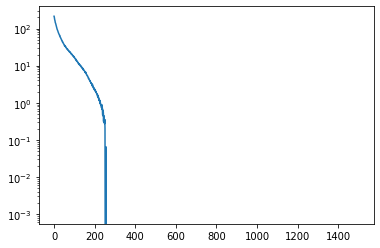

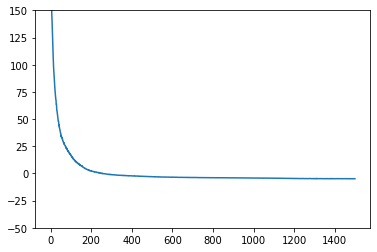


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.21504434927019 and pval_i=0.989678590564376
0 and 2 are independent with pval_d=0.010235478111905718 and pval_i=0.9917283037997762
0 and 3 are DEPENDENT with pval_d=3.0922885259108213e-07 and pval_i=3.072066553839005e-07
0 and 4 are independent with pval_d=0.9369420323896495 and pval_i=0.9975501648297845
0 and 5 are independent with pval_d=0.14111387396898648 and pval_i=0.7410778118208461
0 and 6 are independent with pval_d=0.02948312399969208 and pval_i=0.5890690533251943
0 and 7 are independent with pval_d=0.05114570914028148 and pval_i=0.9997041349725342
1 and 2 are independent with pval_d=0.01883784003299478 and pval_i=0.2536794174026008
1 and 3 are DEPENDENT with pval_d=5.934516470954501e-06 and pval_i=4.0925924486806706e-07
1 and 4 are independent with pval_d=0.9741223610984973 and pval_i=0.9978939937851936
1 and 5 are independent with pval_d=0.1748743844747

  1%|          | 1/100 [00:01<02:38,  1.60s/it]

0 68.45518854260445


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

1 65.30673192441463


  3%|▎         | 3/100 [00:04<02:34,  1.59s/it]

2 65.1716407686472


  4%|▍         | 4/100 [00:06<02:32,  1.59s/it]

3 65.15756268054247


  5%|▌         | 5/100 [00:07<02:31,  1.59s/it]

4 65.15589758753777


  6%|▌         | 6/100 [00:09<02:29,  1.59s/it]

5 65.06524956226349


  7%|▋         | 7/100 [00:11<02:28,  1.60s/it]

6 64.99834768474102


  8%|▊         | 8/100 [00:12<02:26,  1.60s/it]

7 65.02131834626198


  9%|▉         | 9/100 [00:14<02:25,  1.60s/it]

8 65.00589889287949


 10%|█         | 10/100 [00:15<02:24,  1.60s/it]

9 64.9905506670475


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

10 64.91819945722818


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 64.94197648763657


 13%|█▎        | 13/100 [00:20<02:20,  1.61s/it]

12 64.96726386249065


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

13 64.90670899301767


 15%|█▌        | 15/100 [00:24<02:17,  1.61s/it]

14 64.92396558821201


 16%|█▌        | 16/100 [00:25<02:15,  1.61s/it]

15 64.8784212321043


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 64.8797263726592


 18%|█▊        | 18/100 [00:28<02:12,  1.62s/it]

17 64.85440693795681


 19%|█▉        | 19/100 [00:30<02:10,  1.61s/it]

18 64.86124016344547


 20%|██        | 20/100 [00:32<02:08,  1.61s/it]

19 64.83517222106457


 21%|██        | 21/100 [00:33<02:07,  1.61s/it]

20 64.82240930944681


 22%|██▏       | 22/100 [00:35<02:06,  1.62s/it]

21 64.84434977173805


 23%|██▎       | 23/100 [00:36<02:04,  1.62s/it]

22 64.829824000597


 24%|██▍       | 24/100 [00:38<02:02,  1.61s/it]

23 64.81733454018831


 25%|██▌       | 25/100 [00:40<02:00,  1.60s/it]

24 64.81150050461292


 26%|██▌       | 26/100 [00:41<01:58,  1.60s/it]

25 64.8167783766985


 27%|██▋       | 27/100 [00:43<01:57,  1.61s/it]

26 64.76777155697346


 28%|██▊       | 28/100 [00:44<01:55,  1.60s/it]

27 64.78731569647789


 29%|██▉       | 29/100 [00:46<01:53,  1.60s/it]

28 64.79251639544964


 30%|███       | 30/100 [00:48<01:51,  1.59s/it]

29 64.79134588688612


 31%|███       | 31/100 [00:49<01:49,  1.59s/it]

30 64.76901806145906


 32%|███▏      | 32/100 [00:51<01:47,  1.59s/it]

31 64.80364280939102


 33%|███▎      | 33/100 [00:52<01:47,  1.60s/it]

32 64.76226516067982


 34%|███▍      | 34/100 [00:54<01:46,  1.61s/it]

33 64.79491433501244


 35%|███▌      | 35/100 [00:56<01:44,  1.61s/it]

34 64.7554445490241


 36%|███▌      | 36/100 [00:57<01:43,  1.62s/it]

35 64.79888213425875


 37%|███▋      | 37/100 [00:59<01:42,  1.63s/it]

36 64.76182090491056


 38%|███▊      | 38/100 [01:01<01:41,  1.64s/it]

37 64.76035290956497


 39%|███▉      | 39/100 [01:02<01:39,  1.64s/it]

38 64.74815900623798


 40%|████      | 40/100 [01:04<01:37,  1.63s/it]

39 64.78770366311073


 41%|████      | 41/100 [01:05<01:35,  1.62s/it]

40 64.72590760141611


 42%|████▏     | 42/100 [01:07<01:33,  1.61s/it]

41 64.75199992954731


 43%|████▎     | 43/100 [01:09<01:31,  1.61s/it]

42 64.75438715517521


 44%|████▍     | 44/100 [01:10<01:30,  1.61s/it]

43 64.76903823763132


 45%|████▌     | 45/100 [01:12<01:28,  1.60s/it]

44 64.74771822988987


 46%|████▌     | 46/100 [01:13<01:26,  1.60s/it]

45 64.76129668951035


 47%|████▋     | 47/100 [01:15<01:24,  1.60s/it]

46 64.76279391348362


 48%|████▊     | 48/100 [01:17<01:22,  1.59s/it]

47 64.76865918189287


 49%|████▉     | 49/100 [01:18<01:21,  1.60s/it]

48 64.75061473250389


 50%|█████     | 50/100 [01:20<01:20,  1.60s/it]

49 64.73624840378761


 51%|█████     | 51/100 [01:21<01:18,  1.60s/it]

50 64.73420968651772


 52%|█████▏    | 52/100 [01:23<01:16,  1.60s/it]

51 64.75985303521156


 53%|█████▎    | 53/100 [01:25<01:15,  1.60s/it]

52 64.76403111219406


 54%|█████▍    | 54/100 [01:26<01:13,  1.59s/it]

53 64.75003679096699


 55%|█████▌    | 55/100 [01:28<01:11,  1.60s/it]

54 64.75619691610336


 56%|█████▌    | 56/100 [01:29<01:10,  1.60s/it]

55 64.75173941254616


 57%|█████▋    | 57/100 [01:31<01:09,  1.61s/it]

56 64.74761877954006


 58%|█████▊    | 58/100 [01:33<01:07,  1.61s/it]

57 64.75348126888275


 59%|█████▉    | 59/100 [01:34<01:05,  1.60s/it]

58 64.75143038481474


 60%|██████    | 60/100 [01:36<01:03,  1.60s/it]

59 64.74636585265398


 61%|██████    | 61/100 [01:37<01:02,  1.59s/it]

60 64.75739960372448


 62%|██████▏   | 62/100 [01:39<01:00,  1.60s/it]

61 64.73167236894369


 63%|██████▎   | 63/100 [01:41<00:58,  1.59s/it]

62 64.74147540330887


 64%|██████▍   | 64/100 [01:42<00:57,  1.59s/it]

63 64.71831394731998


 65%|██████▌   | 65/100 [01:44<00:55,  1.59s/it]

64 64.73709636181593


 66%|██████▌   | 66/100 [01:45<00:54,  1.59s/it]

65 64.74615800380707


 67%|██████▋   | 67/100 [01:47<00:52,  1.59s/it]

66 64.74543096870184


 68%|██████▊   | 68/100 [01:49<00:50,  1.59s/it]

67 64.72938470542431


 69%|██████▉   | 69/100 [01:50<00:49,  1.60s/it]

68 64.7427609860897


 70%|███████   | 70/100 [01:52<00:48,  1.60s/it]

69 64.72259868681431


 71%|███████   | 71/100 [01:53<00:46,  1.60s/it]

70 64.76862139999866


 72%|███████▏  | 72/100 [01:55<00:44,  1.60s/it]

71 64.73105213046074


 73%|███████▎  | 73/100 [01:57<00:43,  1.60s/it]

72 64.72848521918058


 74%|███████▍  | 74/100 [01:58<00:41,  1.60s/it]

73 64.73467713594437


 75%|███████▌  | 75/100 [02:00<00:39,  1.59s/it]

74 64.72633668780327


 76%|███████▌  | 76/100 [02:01<00:38,  1.59s/it]

75 64.74669790267944


 77%|███████▋  | 77/100 [02:03<00:36,  1.60s/it]

76 64.75276732444763


 78%|███████▊  | 78/100 [02:05<00:35,  1.61s/it]

77 64.76054312288761


 79%|███████▉  | 79/100 [02:06<00:33,  1.61s/it]

78 64.73680140823126


 80%|████████  | 80/100 [02:08<00:32,  1.60s/it]

79 64.74702715873718


 81%|████████  | 81/100 [02:09<00:30,  1.60s/it]

80 64.73341380059719


 82%|████████▏ | 82/100 [02:11<00:28,  1.60s/it]

81 64.73584935069084


 83%|████████▎ | 83/100 [02:13<00:27,  1.60s/it]

82 64.75644609332085


 84%|████████▍ | 84/100 [02:14<00:25,  1.60s/it]

83 64.73210817575455


 85%|████████▌ | 85/100 [02:16<00:24,  1.61s/it]

84 64.7300916314125


 86%|████████▌ | 86/100 [02:17<00:22,  1.62s/it]

85 64.72995010763407


 87%|████████▋ | 87/100 [02:19<00:21,  1.62s/it]

86 64.74212896078825


 88%|████████▊ | 88/100 [02:21<00:19,  1.61s/it]

87 64.730947047472


 89%|████████▉ | 89/100 [02:22<00:17,  1.61s/it]

88 64.73783858120441


 90%|█████████ | 90/100 [02:24<00:16,  1.60s/it]

89 64.73220527172089


 91%|█████████ | 91/100 [02:25<00:14,  1.61s/it]

90 64.75245459377766


 92%|█████████▏| 92/100 [02:27<00:12,  1.61s/it]

91 64.71196297556162


 93%|█████████▎| 93/100 [02:29<00:11,  1.62s/it]

92 64.76166127622128


 94%|█████████▍| 94/100 [02:30<00:09,  1.62s/it]

93 64.71962720155716


 95%|█████████▌| 95/100 [02:32<00:08,  1.62s/it]

94 64.74873150140047


 96%|█████████▌| 96/100 [02:34<00:06,  1.63s/it]

95 64.71670319139957


 97%|█████████▋| 97/100 [02:35<00:04,  1.62s/it]

96 64.78327421098948


 98%|█████████▊| 98/100 [02:37<00:03,  1.63s/it]

97 64.70767325162888


 99%|█████████▉| 99/100 [02:38<00:01,  1.61s/it]

98 64.73390233516693


100%|██████████| 100/100 [02:40<00:00,  1.61s/it]

99 64.75463451445103

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07492243498563766	

epoch 9000/10000, policy loss 0.045479923486709595	
***** test student *****
epoch 0/100 return: 19.0
epoch 1/100 return: 21.0
epoch 2/100 return: 15.0
epoch 3/100 return: 15.0
epoch 4/100 return: 25.0
epoch 5/100 return: 22.0
epoch 6/100 return: 16.0
epoch 7/100 return: 17.0
epoch 8/100 return: 19.0
epoch 9/100 return: 16.0
epoch 10/100 return: 16.0
epoch 11/100 return: 21.0
epoch 12/100 return: 21.0
epoch 13/100 return: 22.0
epoch 14/100 return: 22.0
epoch 15/100 return: 19.0
epoch 16/100 return: 23.0
epoch 17/100 return: 20.0
epoch 18/100 return: 23.0
epoch 19/100 return: 19.0
epoch 20/100 return: 15.0
epoch 21/100 return: 17.0
epoch 22/100 return: 21.0
epoch 23/100 return: 16.0
epoch 24/100 return: 15.0
epoch 25/100 return: 20.0
epoch 26/100 return: 19.0
epoch 27/100 return: 19.0
epoch 28/100 return: 21.0
epoch 29/100 return: 20.0
epoch 30/100 return: 24.0
epoch 31/100 return: 22.0
epoch 32/100 return: 15.0
epoch 33/100 return: 17.0
epoch 34/100 return: 19.0
epoch 35/100 return: 17

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.871677398681641best loss model loaded, stored at update # 1489


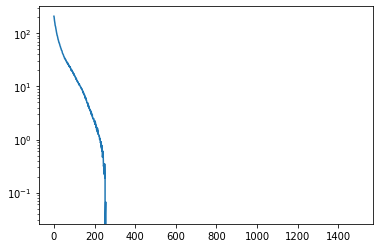

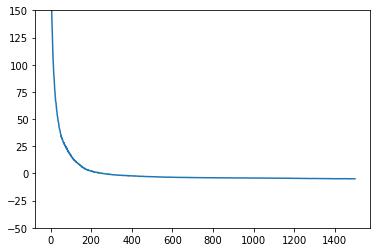


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.056475029206893644 and pval_i=0.9982746770984027
0 and 2 are independent with pval_d=0.018491678563068267 and pval_i=0.9712272737837697
0 and 3 are DEPENDENT with pval_d=1.1917295962253532e-07 and pval_i=5.3630126772851765e-08
0 and 4 are independent with pval_d=0.9953250290752361 and pval_i=0.9998305026891381
0 and 5 are DEPENDENT with pval_d=0.5151748802000318 and pval_i=0.488592111638558
0 and 6 are independent with pval_d=0.03986131425922511 and pval_i=0.09259617314050593
0 and 7 are independent with pval_d=0.001958141333553994 and pval_i=0.9427868780116425
1 and 2 are independent with pval_d=0.1291014541749719 and pval_i=0.6701497993715403
1 and 3 are DEPENDENT with pval_d=6.420252793058444e-08 and pval_i=6.07545536233644e-08
1 and 4 are independent with pval_d=0.2827271876177573 and pval_i=0.9851725784754314
1 and 5 are DEPENDENT with pval_d=0.67783169523458

  1%|          | 1/100 [00:01<02:36,  1.59s/it]

0 76.46627435088158


  2%|▏         | 2/100 [00:03<02:39,  1.63s/it]

1 73.0928935110569


  3%|▎         | 3/100 [00:04<02:35,  1.61s/it]

2 72.93898530304432


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

3 72.94325511157513


  5%|▌         | 5/100 [00:08<02:33,  1.62s/it]

4 72.90493960678577


  6%|▌         | 6/100 [00:09<02:31,  1.61s/it]

5 72.81672509014606


  7%|▋         | 7/100 [00:11<02:28,  1.60s/it]

6 72.76943500339985


  8%|▊         | 8/100 [00:12<02:29,  1.62s/it]

7 72.81429767608643


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 72.77369518578053


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 72.75297003984451


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

10 72.66441114246845


 12%|█▏        | 12/100 [00:19<02:20,  1.60s/it]

11 72.70424017310143


 13%|█▎        | 13/100 [00:20<02:19,  1.60s/it]

12 72.6898976713419


 14%|█▍        | 14/100 [00:22<02:17,  1.60s/it]

13 72.68241049349308


 15%|█▌        | 15/100 [00:24<02:16,  1.60s/it]

14 72.67498083412647


 16%|█▌        | 16/100 [00:25<02:13,  1.59s/it]

15 72.63591839373112


 17%|█▋        | 17/100 [00:27<02:12,  1.60s/it]

16 72.62340560555458


 18%|█▊        | 18/100 [00:28<02:10,  1.59s/it]

17 72.61712647974491


 19%|█▉        | 19/100 [00:30<02:10,  1.61s/it]

18 72.63826890289783


 20%|██        | 20/100 [00:32<02:08,  1.61s/it]

19 72.56942729651928


 21%|██        | 21/100 [00:33<02:08,  1.62s/it]

20 72.59995725750923


 22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]

21 72.60227261483669


 23%|██▎       | 23/100 [00:36<02:03,  1.61s/it]

22 72.6039452701807


 24%|██▍       | 24/100 [00:38<02:02,  1.61s/it]

23 72.56884302198887


 25%|██▌       | 25/100 [00:40<02:00,  1.61s/it]

24 72.564578384161


 26%|██▌       | 26/100 [00:41<01:58,  1.61s/it]

25 72.59571459889412


 27%|██▋       | 27/100 [00:43<01:57,  1.61s/it]

26 72.5369561612606


 28%|██▊       | 28/100 [00:44<01:55,  1.60s/it]

27 72.54216900467873


 29%|██▉       | 29/100 [00:46<01:53,  1.60s/it]

28 72.55070641636848


 30%|███       | 30/100 [00:48<01:52,  1.61s/it]

29 72.52697505056858


 31%|███       | 31/100 [00:49<01:50,  1.60s/it]

30 72.51821865141392


 32%|███▏      | 32/100 [00:51<01:48,  1.60s/it]

31 72.56510780751705


 33%|███▎      | 33/100 [00:52<01:46,  1.59s/it]

32 72.48521076142788


 34%|███▍      | 34/100 [00:54<01:45,  1.60s/it]

33 72.54413801431656


 35%|███▌      | 35/100 [00:56<01:43,  1.59s/it]

34 72.46905274689198


 36%|███▌      | 36/100 [00:57<01:42,  1.60s/it]

35 72.52563542127609


 37%|███▋      | 37/100 [00:59<01:40,  1.59s/it]

36 72.50528962910175


 38%|███▊      | 38/100 [01:00<01:38,  1.59s/it]

37 72.50232894718647


 39%|███▉      | 39/100 [01:02<01:36,  1.59s/it]

38 72.48332020640373


 40%|████      | 40/100 [01:04<01:36,  1.60s/it]

39 72.5089949220419


 41%|████      | 41/100 [01:05<01:34,  1.61s/it]

40 72.41966013610363


 42%|████▏     | 42/100 [01:07<01:32,  1.60s/it]

41 72.50853784382343


 43%|████▎     | 43/100 [01:08<01:31,  1.60s/it]

42 72.48405930399895


 44%|████▍     | 44/100 [01:10<01:29,  1.60s/it]

43 72.48572684824467


 45%|████▌     | 45/100 [01:12<01:28,  1.62s/it]

44 72.49256238341331


 46%|████▌     | 46/100 [01:13<01:27,  1.62s/it]

45 72.47333055734634


 47%|████▋     | 47/100 [01:15<01:25,  1.61s/it]

46 72.48068651556969


 48%|████▊     | 48/100 [01:16<01:23,  1.60s/it]

47 72.48084759712219


 49%|████▉     | 49/100 [01:18<01:22,  1.61s/it]

48 72.46941271424294


 50%|█████     | 50/100 [01:20<01:20,  1.61s/it]

49 72.47321934998035


 51%|█████     | 51/100 [01:21<01:18,  1.59s/it]

50 72.47064845263958


 52%|█████▏    | 52/100 [01:23<01:16,  1.60s/it]

51 72.47610108554363


 53%|█████▎    | 53/100 [01:24<01:14,  1.59s/it]

52 72.53493122756481


 54%|█████▍    | 54/100 [01:26<01:13,  1.60s/it]

53 72.48351433873177


 55%|█████▌    | 55/100 [01:28<01:11,  1.60s/it]

54 72.45663699507713


 56%|█████▌    | 56/100 [01:29<01:10,  1.61s/it]

55 72.4795628786087


 57%|█████▋    | 57/100 [01:31<01:08,  1.60s/it]

56 72.45500060915947


 58%|█████▊    | 58/100 [01:32<01:07,  1.60s/it]

57 72.47128041088581


 59%|█████▉    | 59/100 [01:34<01:06,  1.61s/it]

58 72.4742418974638


 60%|██████    | 60/100 [01:36<01:03,  1.60s/it]

59 72.44805307686329


 61%|██████    | 61/100 [01:37<01:02,  1.60s/it]

60 72.48749680817127


 62%|██████▏   | 62/100 [01:39<01:00,  1.60s/it]

61 72.4587786346674


 63%|██████▎   | 63/100 [01:40<00:58,  1.59s/it]

62 72.44580446183681


 64%|██████▍   | 64/100 [01:42<00:57,  1.60s/it]

63 72.4429817199707


 65%|██████▌   | 65/100 [01:44<00:55,  1.60s/it]

64 72.46986925601959


 66%|██████▌   | 66/100 [01:45<00:54,  1.59s/it]

65 72.46213094890118


 67%|██████▋   | 67/100 [01:47<00:52,  1.59s/it]

66 72.4683340638876


 68%|██████▊   | 68/100 [01:48<00:50,  1.59s/it]

67 72.4443833231926


 69%|██████▉   | 69/100 [01:50<00:49,  1.60s/it]

68 72.46500261127949


 70%|███████   | 70/100 [01:52<00:48,  1.61s/it]

69 72.41947381198406


 71%|███████   | 71/100 [01:53<00:46,  1.61s/it]

70 72.48897542059422


 72%|███████▏  | 72/100 [01:55<00:44,  1.60s/it]

71 72.45696949958801


 73%|███████▎  | 73/100 [01:56<00:43,  1.61s/it]

72 72.45850066840649


 74%|███████▍  | 74/100 [01:58<00:41,  1.61s/it]

73 72.46044443547726


 75%|███████▌  | 75/100 [02:00<00:40,  1.61s/it]

74 72.46033157408237


 76%|███████▌  | 76/100 [02:01<00:38,  1.60s/it]

75 72.45766352117062


 77%|███████▋  | 77/100 [02:03<00:36,  1.59s/it]

76 72.46418642997742


 78%|███████▊  | 78/100 [02:04<00:35,  1.61s/it]

77 72.47200533747673


 79%|███████▉  | 79/100 [02:06<00:34,  1.63s/it]

78 72.4272873699665


 80%|████████  | 80/100 [02:08<00:32,  1.62s/it]

79 72.44649778306484


 81%|████████  | 81/100 [02:09<00:30,  1.61s/it]

80 72.44331711530685


 82%|████████▏ | 82/100 [02:11<00:28,  1.61s/it]

81 72.44312457740307


 83%|████████▎ | 83/100 [02:13<00:27,  1.61s/it]

82 72.47335812449455


 84%|████████▍ | 84/100 [02:14<00:25,  1.59s/it]

83 72.43154734373093


 85%|████████▌ | 85/100 [02:16<00:23,  1.59s/it]

84 72.44507940113544


 86%|████████▌ | 86/100 [02:17<00:22,  1.59s/it]

85 72.42485927045345


 87%|████████▋ | 87/100 [02:19<00:20,  1.60s/it]

86 72.4589431732893


 88%|████████▊ | 88/100 [02:20<00:19,  1.59s/it]

87 72.45340785384178


 89%|████████▉ | 89/100 [02:22<00:17,  1.60s/it]

88 72.48510804772377


 90%|█████████ | 90/100 [02:24<00:16,  1.61s/it]

89 72.44626376032829


 91%|█████████ | 91/100 [02:25<00:14,  1.61s/it]

90 72.44319994747639


 92%|█████████▏| 92/100 [02:27<00:12,  1.61s/it]

91 72.41590982675552


 93%|█████████▎| 93/100 [02:29<00:11,  1.61s/it]

92 72.46133349835873


 94%|█████████▍| 94/100 [02:30<00:09,  1.60s/it]

93 72.4180393666029


 95%|█████████▌| 95/100 [02:32<00:08,  1.61s/it]

94 72.4433646351099


 96%|█████████▌| 96/100 [02:33<00:06,  1.61s/it]

95 72.43083058297634


 97%|█████████▋| 97/100 [02:35<00:04,  1.60s/it]

96 72.43169267475605


 98%|█████████▊| 98/100 [02:37<00:03,  1.62s/it]

97 72.43325245380402


 99%|█████████▉| 99/100 [02:38<00:01,  1.61s/it]

98 72.46757382154465


100%|██████████| 100/100 [02:40<00:00,  1.60s/it]

99 72.4404916614294

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07827915996313095	

epoch 9000/10000, policy loss 0.04494753107428551	
***** test student *****
epoch 0/100 return: 93.0
epoch 1/100 return: 104.0
epoch 2/100 return: 163.0
epoch 3/100 return: 182.0
epoch 4/100 return: 149.0
epoch 5/100 return: 173.0
epoch 6/100 return: 120.0
epoch 7/100 return: 159.0
epoch 8/100 return: 128.0
epoch 9/100 return: 170.0
epoch 10/100 return: 96.0
epoch 11/100 return: 209.0
epoch 12/100 return: 193.0
epoch 13/100 return: 189.0
epoch 14/100 return: 95.0
epoch 15/100 return: 105.0
epoch 16/100 return: 100.0
epoch 17/100 return: 155.0
epoch 18/100 return: 119.0
epoch 19/100 return: 100.0
epoch 20/100 return: 134.0
epoch 21/100 return: 199.0
epoch 22/100 return: 104.0
epoch 23/100 return: 118.0
epoch 24/100 return: 98.0
epoch 25/100 return: 162.0
epoch 26/100 return: 194.0
epoch 27/100 return: 208.0
epoch 28/100 return: 154.0
epoch 29/100 return: 95.0
epoch 30/100 return: 148.0
epoch 31/100 return: 186.0
epoch 32/100 return: 164.0
epoch 33/100 return: 97.0
epoch 34/100 return: 1

In [15]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May2_iVAE_test_th0_statedim8_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_iVAE_neg1 = policy_loss_list

In [16]:
results_trial[2].mean(), results_trial[2].std()

(39.218, 47.74994538682159)

In [18]:
np.array([0.044947, 0.04547, 0.04946, 0.056245, 0.04901, 0.0496, 0.044544, 0.04541, 0.050404, 0.05627,  ]).std()

0.00411500456864874

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = -1]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

batch size =  50000
Config: {'ALG': 'May1_test1_thneg1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

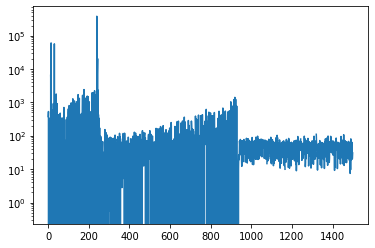

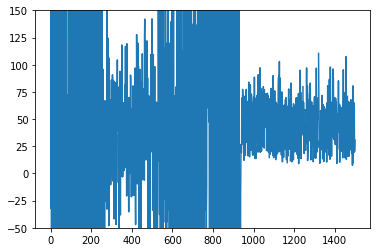


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:36,  1.58s/it]

0 198.83413210511208


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

1 168.24114775657654


  3%|▎         | 3/100 [00:04<02:35,  1.61s/it]

2 167.15408581495285


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

3 166.08518102765083


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 165.70181539654732


  6%|▌         | 6/100 [00:09<02:32,  1.63s/it]

5 165.30436477065086


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 165.18046563863754


  8%|▊         | 8/100 [00:13<02:30,  1.63s/it]

7 165.0938312113285


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 164.93244951963425


 10%|█         | 10/100 [00:16<02:24,  1.61s/it]

9 164.9853981435299


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 164.78849440813065


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 164.59669288992882


 13%|█▎        | 13/100 [00:21<02:20,  1.62s/it]

12 164.85838916897774


 14%|█▍        | 14/100 [00:22<02:19,  1.62s/it]

13 164.78813469409943


 15%|█▌        | 15/100 [00:24<02:16,  1.61s/it]

14 164.54638266563416


 16%|█▌        | 16/100 [00:25<02:15,  1.61s/it]

15 164.63220250606537


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 164.49360930919647


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 164.54822754859924


 19%|█▉        | 19/100 [00:30<02:13,  1.65s/it]

18 164.41869667172432


 20%|██        | 20/100 [00:32<02:13,  1.66s/it]

19 164.19448149204254


 21%|██        | 21/100 [00:34<02:11,  1.66s/it]

20 164.40653324127197


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 164.2948994934559


 23%|██▎       | 23/100 [00:37<02:05,  1.63s/it]

22 164.16745176911354


 24%|██▍       | 24/100 [00:39<02:05,  1.66s/it]

23 164.0621938109398


 25%|██▌       | 25/100 [00:40<02:05,  1.67s/it]

24 164.11121690273285


 26%|██▌       | 26/100 [00:42<02:01,  1.65s/it]

25 164.15250968933105


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 164.11202663183212


 28%|██▊       | 28/100 [00:45<01:56,  1.62s/it]

27 164.12471896409988


 29%|██▉       | 29/100 [00:47<01:55,  1.62s/it]

28 164.21552523970604


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 164.12152257561684


 31%|███       | 31/100 [00:50<01:51,  1.61s/it]

30 164.04827144742012


 32%|███▏      | 32/100 [00:52<01:50,  1.62s/it]

31 163.95905390381813


 33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

32 164.02326625585556


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 164.1894628405571


 35%|███▌      | 35/100 [00:57<01:46,  1.64s/it]

34 163.7902195751667


 36%|███▌      | 36/100 [00:58<01:45,  1.65s/it]

35 164.01690569519997


 37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

36 163.86685705184937


 38%|███▊      | 38/100 [01:01<01:41,  1.63s/it]

37 163.83067750930786


 39%|███▉      | 39/100 [01:03<01:39,  1.64s/it]

38 164.0036698281765


 40%|████      | 40/100 [01:05<01:37,  1.63s/it]

39 163.87304213643074


 41%|████      | 41/100 [01:06<01:36,  1.63s/it]

40 163.8271630704403


 42%|████▏     | 42/100 [01:08<01:35,  1.64s/it]

41 163.82552993297577


 43%|████▎     | 43/100 [01:10<01:34,  1.66s/it]

42 163.6741545498371


 44%|████▍     | 44/100 [01:11<01:33,  1.67s/it]

43 163.80848667025566


 45%|████▌     | 45/100 [01:13<01:31,  1.66s/it]

44 163.75211960077286


 46%|████▌     | 46/100 [01:15<01:28,  1.64s/it]

45 163.67237481474876


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 163.78102323412895


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 163.74854657053947


 49%|████▉     | 49/100 [01:19<01:22,  1.63s/it]

48 163.69211041927338


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 163.69324737787247


 51%|█████     | 51/100 [01:23<01:19,  1.63s/it]

50 163.94129556417465


 52%|█████▏    | 52/100 [01:24<01:17,  1.62s/it]

51 163.7222726047039


 53%|█████▎    | 53/100 [01:26<01:15,  1.62s/it]

52 163.8117574453354


 54%|█████▍    | 54/100 [01:28<01:15,  1.63s/it]

53 163.66593930125237


 55%|█████▌    | 55/100 [01:29<01:13,  1.63s/it]

54 163.59443870186806


 56%|█████▌    | 56/100 [01:31<01:11,  1.63s/it]

55 163.6758216023445


 57%|█████▋    | 57/100 [01:33<01:10,  1.64s/it]

56 163.66823706030846


 58%|█████▊    | 58/100 [01:34<01:09,  1.65s/it]

57 163.65782424807549


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 163.63634851574898


 60%|██████    | 60/100 [01:37<01:05,  1.63s/it]

59 163.72122156620026


 61%|██████    | 61/100 [01:39<01:03,  1.63s/it]

60 163.6073139309883


 62%|██████▏   | 62/100 [01:41<01:02,  1.65s/it]

61 163.5830462872982


 63%|██████▎   | 63/100 [01:42<01:01,  1.66s/it]

62 163.59029135107994


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 163.67812949419022


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 163.60130456089973


 66%|██████▌   | 66/100 [01:47<00:55,  1.64s/it]

65 163.51540884375572


 67%|██████▋   | 67/100 [01:49<00:54,  1.64s/it]

66 163.58598950505257


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 163.55262583494186


 69%|██████▉   | 69/100 [01:52<00:51,  1.65s/it]

68 163.66129302978516


 70%|███████   | 70/100 [01:54<00:49,  1.64s/it]

69 163.74757200479507


 71%|███████   | 71/100 [01:56<00:47,  1.63s/it]

70 163.53497377038002


 72%|███████▏  | 72/100 [01:57<00:45,  1.61s/it]

71 163.53884521126747


 73%|███████▎  | 73/100 [01:59<00:43,  1.63s/it]

72 163.63782104849815


 74%|███████▍  | 74/100 [02:00<00:42,  1.64s/it]

73 163.64796659350395


 75%|███████▌  | 75/100 [02:02<00:40,  1.64s/it]

74 163.4567288160324


 76%|███████▌  | 76/100 [02:04<00:39,  1.65s/it]

75 163.56994631886482


 77%|███████▋  | 77/100 [02:05<00:37,  1.64s/it]

76 163.59782275557518


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 163.53663256764412


 79%|███████▉  | 79/100 [02:09<00:34,  1.64s/it]

78 163.66592234373093


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 163.50203824043274


 81%|████████  | 81/100 [02:12<00:30,  1.62s/it]

80 163.50736090540886


 82%|████████▏ | 82/100 [02:14<00:30,  1.67s/it]

81 163.5618232190609


 83%|████████▎ | 83/100 [02:15<00:27,  1.64s/it]

82 163.50539562106133


 84%|████████▍ | 84/100 [02:17<00:26,  1.63s/it]

83 163.51525363326073


 85%|████████▌ | 85/100 [02:18<00:24,  1.63s/it]

84 163.55290642380714


 86%|████████▌ | 86/100 [02:20<00:22,  1.64s/it]

85 163.58012226223946


 87%|████████▋ | 87/100 [02:22<00:21,  1.66s/it]

86 163.60942190885544


 88%|████████▊ | 88/100 [02:23<00:19,  1.64s/it]

87 163.407602339983


 89%|████████▉ | 89/100 [02:25<00:17,  1.63s/it]

88 163.60221621394157


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 163.42902666330338


 91%|█████████ | 91/100 [02:28<00:14,  1.61s/it]

90 163.5602574646473


 92%|█████████▏| 92/100 [02:30<00:13,  1.63s/it]

91 163.5231736600399


 93%|█████████▎| 93/100 [02:31<00:11,  1.62s/it]

92 163.501302421093


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 163.44341936707497


 95%|█████████▌| 95/100 [02:35<00:08,  1.63s/it]

94 163.55155593156815


 96%|█████████▌| 96/100 [02:36<00:06,  1.62s/it]

95 163.38044118881226


 97%|█████████▋| 97/100 [02:38<00:04,  1.61s/it]

96 163.50572809576988


 98%|█████████▊| 98/100 [02:40<00:03,  1.61s/it]

97 163.43726232647896


 99%|█████████▉| 99/100 [02:41<00:01,  1.61s/it]

98 163.50007358193398


100%|██████████| 100/100 [02:43<00:00,  1.60s/it]

99 163.55120518803596

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07415603846311569	

epoch 9000/10000, policy loss 0.0009309895685873926	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_thneg1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_neg1 = policy_loss_list

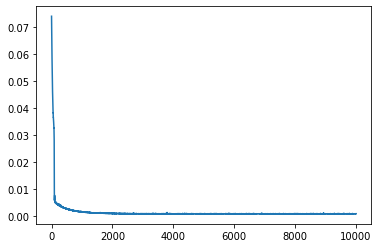

In [ ]:
import matplotlib.pyplot as plt
plt.plot(policy_loss_list_neg1)

In [ ]:
with open('policy_loss_list_neg1.npy', 'wb') as f:
    np.save(f, policy_loss_list_neg1)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 0]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 0

batch size =  50000
Config: {'ALG': 'May1_test1_th0_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 0, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

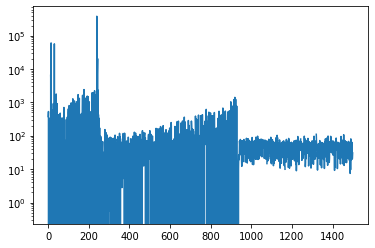

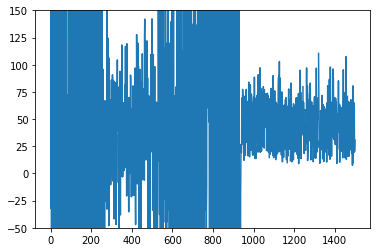


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:50,  1.72s/it]

0 198.83413210511208


  2%|▏         | 2/100 [00:03<02:48,  1.72s/it]

1 168.24114775657654


  3%|▎         | 3/100 [00:05<02:43,  1.69s/it]

2 167.15408581495285


  4%|▍         | 4/100 [00:06<02:40,  1.67s/it]

3 166.08518102765083


  5%|▌         | 5/100 [00:08<02:37,  1.66s/it]

4 165.70181539654732


  6%|▌         | 6/100 [00:09<02:34,  1.64s/it]

5 165.30436477065086


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 165.18046563863754


  8%|▊         | 8/100 [00:13<02:29,  1.62s/it]

7 165.0938312113285


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 164.93244951963425


 10%|█         | 10/100 [00:16<02:26,  1.63s/it]

9 164.9853981435299


 11%|█         | 11/100 [00:17<02:23,  1.62s/it]

10 164.78849440813065


 12%|█▏        | 12/100 [00:19<02:22,  1.62s/it]

11 164.59669288992882


 13%|█▎        | 13/100 [00:21<02:20,  1.61s/it]

12 164.85838916897774


 14%|█▍        | 14/100 [00:22<02:19,  1.63s/it]

13 164.78813469409943


 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]

14 164.54638266563416


 16%|█▌        | 16/100 [00:26<02:18,  1.64s/it]

15 164.63220250606537


 17%|█▋        | 17/100 [00:27<02:15,  1.64s/it]

16 164.49360930919647


 18%|█▊        | 18/100 [00:29<02:13,  1.62s/it]

17 164.54822754859924


 19%|█▉        | 19/100 [00:31<02:12,  1.64s/it]

18 164.41869667172432


 20%|██        | 20/100 [00:32<02:11,  1.64s/it]

19 164.19448149204254


 21%|██        | 21/100 [00:34<02:09,  1.64s/it]

20 164.40653324127197


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 164.2948994934559


 23%|██▎       | 23/100 [00:37<02:04,  1.62s/it]

22 164.16745176911354


 24%|██▍       | 24/100 [00:39<02:03,  1.62s/it]

23 164.0621938109398


 25%|██▌       | 25/100 [00:40<02:02,  1.64s/it]

24 164.11121690273285


 26%|██▌       | 26/100 [00:42<02:01,  1.64s/it]

25 164.15250968933105


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 164.11202663183212


 28%|██▊       | 28/100 [00:45<01:59,  1.66s/it]

27 164.12471896409988


 29%|██▉       | 29/100 [00:47<01:57,  1.65s/it]

28 164.21552523970604


 30%|███       | 30/100 [00:49<01:55,  1.65s/it]

29 164.12152257561684


 31%|███       | 31/100 [00:50<01:55,  1.68s/it]

30 164.04827144742012


 32%|███▏      | 32/100 [00:52<01:54,  1.68s/it]

31 163.95905390381813


 33%|███▎      | 33/100 [00:54<01:51,  1.66s/it]

32 164.02326625585556


 34%|███▍      | 34/100 [00:55<01:49,  1.66s/it]

33 164.1894628405571


 35%|███▌      | 35/100 [00:57<01:47,  1.66s/it]

34 163.7902195751667


 36%|███▌      | 36/100 [00:59<01:45,  1.65s/it]

35 164.01690569519997


 37%|███▋      | 37/100 [01:00<01:43,  1.65s/it]

36 163.86685705184937


 38%|███▊      | 38/100 [01:02<01:42,  1.66s/it]

37 163.83067750930786


 39%|███▉      | 39/100 [01:04<01:41,  1.67s/it]

38 164.0036698281765


 40%|████      | 40/100 [01:05<01:39,  1.65s/it]

39 163.87304213643074


 41%|████      | 41/100 [01:07<01:36,  1.64s/it]

40 163.8271630704403


 42%|████▏     | 42/100 [01:09<01:35,  1.65s/it]

41 163.82552993297577


 43%|████▎     | 43/100 [01:10<01:34,  1.65s/it]

42 163.6741545498371


 44%|████▍     | 44/100 [01:12<01:32,  1.65s/it]

43 163.80848667025566


 45%|████▌     | 45/100 [01:14<01:31,  1.67s/it]

44 163.75211960077286


 46%|████▌     | 46/100 [01:15<01:30,  1.68s/it]

45 163.67237481474876


 47%|████▋     | 47/100 [01:17<01:28,  1.66s/it]

46 163.78102323412895


 48%|████▊     | 48/100 [01:19<01:26,  1.66s/it]

47 163.74854657053947


 49%|████▉     | 49/100 [01:20<01:24,  1.67s/it]

48 163.69211041927338


 50%|█████     | 50/100 [01:22<01:25,  1.71s/it]

49 163.69324737787247


 51%|█████     | 51/100 [01:24<01:22,  1.68s/it]

50 163.94129556417465


 52%|█████▏    | 52/100 [01:25<01:19,  1.65s/it]

51 163.7222726047039


 53%|█████▎    | 53/100 [01:27<01:18,  1.67s/it]

52 163.8117574453354


 54%|█████▍    | 54/100 [01:29<01:15,  1.65s/it]

53 163.66593930125237


 55%|█████▌    | 55/100 [01:30<01:13,  1.63s/it]

54 163.59443870186806


 56%|█████▌    | 56/100 [01:32<01:11,  1.63s/it]

55 163.6758216023445


 57%|█████▋    | 57/100 [01:33<01:10,  1.63s/it]

56 163.66823706030846


 58%|█████▊    | 58/100 [01:35<01:08,  1.62s/it]

57 163.65782424807549


 59%|█████▉    | 59/100 [01:37<01:06,  1.61s/it]

58 163.63634851574898


 60%|██████    | 60/100 [01:38<01:04,  1.61s/it]

59 163.72122156620026


 61%|██████    | 61/100 [01:40<01:02,  1.61s/it]

60 163.6073139309883


 62%|██████▏   | 62/100 [01:41<01:00,  1.61s/it]

61 163.5830462872982


 63%|██████▎   | 63/100 [01:43<01:00,  1.64s/it]

62 163.59029135107994


 64%|██████▍   | 64/100 [01:45<00:58,  1.64s/it]

63 163.67812949419022


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 163.60130456089973


 66%|██████▌   | 66/100 [01:48<00:55,  1.63s/it]

65 163.51540884375572


 67%|██████▋   | 67/100 [01:50<00:53,  1.63s/it]

66 163.58598950505257


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 163.55262583494186


 69%|██████▉   | 69/100 [01:53<00:50,  1.64s/it]

68 163.66129302978516


 70%|███████   | 70/100 [01:55<00:49,  1.64s/it]

69 163.74757200479507


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 163.53497377038002


 72%|███████▏  | 72/100 [01:58<00:45,  1.64s/it]

71 163.53884521126747


 73%|███████▎  | 73/100 [02:00<00:44,  1.66s/it]

72 163.63782104849815


 74%|███████▍  | 74/100 [02:01<00:43,  1.66s/it]

73 163.64796659350395


 75%|███████▌  | 75/100 [02:03<00:41,  1.67s/it]

74 163.4567288160324


 76%|███████▌  | 76/100 [02:05<00:39,  1.66s/it]

75 163.56994631886482


 77%|███████▋  | 77/100 [02:06<00:37,  1.65s/it]

76 163.59782275557518


 78%|███████▊  | 78/100 [02:08<00:35,  1.64s/it]

77 163.53663256764412


 79%|███████▉  | 79/100 [02:09<00:34,  1.63s/it]

78 163.66592234373093


 80%|████████  | 80/100 [02:11<00:32,  1.62s/it]

79 163.50203824043274


 81%|████████  | 81/100 [02:13<00:31,  1.63s/it]

80 163.50736090540886


 82%|████████▏ | 82/100 [02:14<00:29,  1.66s/it]

81 163.5618232190609


 83%|████████▎ | 83/100 [02:16<00:28,  1.68s/it]

82 163.50539562106133


 84%|████████▍ | 84/100 [02:18<00:26,  1.66s/it]

83 163.51525363326073


 85%|████████▌ | 85/100 [02:19<00:24,  1.66s/it]

84 163.55290642380714


 86%|████████▌ | 86/100 [02:21<00:23,  1.66s/it]

85 163.58012226223946


 87%|████████▋ | 87/100 [02:23<00:21,  1.65s/it]

86 163.60942190885544


 88%|████████▊ | 88/100 [02:24<00:19,  1.65s/it]

87 163.407602339983


 89%|████████▉ | 89/100 [02:26<00:18,  1.67s/it]

88 163.60221621394157


 90%|█████████ | 90/100 [02:28<00:16,  1.67s/it]

89 163.42902666330338


 91%|█████████ | 91/100 [02:29<00:14,  1.67s/it]

90 163.5602574646473


 92%|█████████▏| 92/100 [02:31<00:13,  1.68s/it]

91 163.5231736600399


 93%|█████████▎| 93/100 [02:33<00:11,  1.67s/it]

92 163.501302421093


 94%|█████████▍| 94/100 [02:34<00:09,  1.67s/it]

93 163.44341936707497


 95%|█████████▌| 95/100 [02:36<00:08,  1.66s/it]

94 163.55155593156815


 96%|█████████▌| 96/100 [02:38<00:06,  1.65s/it]

95 163.38044118881226


 97%|█████████▋| 97/100 [02:39<00:04,  1.64s/it]

96 163.50572809576988


 98%|█████████▊| 98/100 [02:41<00:03,  1.65s/it]

97 163.43726232647896


 99%|█████████▉| 99/100 [02:43<00:01,  1.66s/it]

98 163.50007358193398


100%|██████████| 100/100 [02:44<00:00,  1.67s/it]

99 163.55120518803596

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07415603846311569	

epoch 9000/10000, policy loss 0.0009309895685873926	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th0_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        #for run_seed in range(config["NUM_REPETITIONS"]):
        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_0 = policy_loss_list

In [ ]:
with open('policy_loss_list_0.npy', 'wb') as f:
    np.save(f, policy_loss_list_0)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 1]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 1

batch size =  50000
Config: {'ALG': 'May1_test1_th1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

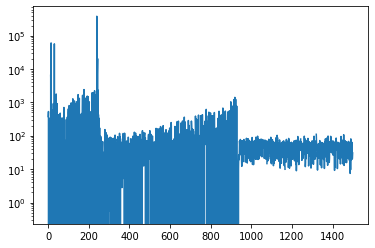

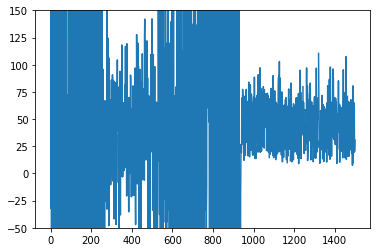


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:38,  1.60s/it]

0 173.48468151688576


  2%|▏         | 2/100 [00:03<02:36,  1.60s/it]

1 147.72795072197914


  3%|▎         | 3/100 [00:04<02:37,  1.62s/it]

2 146.03174817562103


  4%|▍         | 4/100 [00:06<02:35,  1.62s/it]

3 144.6511772274971


  5%|▌         | 5/100 [00:08<02:33,  1.62s/it]

4 144.21071165800095


  6%|▌         | 6/100 [00:09<02:31,  1.61s/it]

5 143.9515316784382


  7%|▋         | 7/100 [00:11<02:29,  1.60s/it]

6 143.39084860682487


  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]

7 143.4088019132614


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 143.22464799880981


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 143.04051831364632


 11%|█         | 11/100 [00:17<02:23,  1.62s/it]

10 142.87224128842354


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 142.85448510944843


 13%|█▎        | 13/100 [00:21<02:22,  1.64s/it]

12 142.95822994410992


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

13 142.8875399082899


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 142.72742387652397


 16%|█▌        | 16/100 [00:26<02:19,  1.66s/it]

15 142.66595178842545


 17%|█▋        | 17/100 [00:27<02:16,  1.64s/it]

16 142.67981265485287


 18%|█▊        | 18/100 [00:29<02:14,  1.64s/it]

17 142.5779106914997


 19%|█▉        | 19/100 [00:30<02:12,  1.63s/it]

18 142.53466802835464


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 142.32784405350685


 21%|██        | 21/100 [00:34<02:07,  1.62s/it]

20 142.48350608348846


 22%|██▏       | 22/100 [00:35<02:09,  1.65s/it]

21 142.3737137913704


 23%|██▎       | 23/100 [00:37<02:11,  1.71s/it]

22 142.2871055006981


 24%|██▍       | 24/100 [00:39<02:07,  1.68s/it]

23 142.2011902332306


 25%|██▌       | 25/100 [00:40<02:04,  1.66s/it]

24 142.29973801970482


 26%|██▌       | 26/100 [00:42<02:02,  1.66s/it]

25 142.2851139307022


 27%|██▋       | 27/100 [00:44<02:00,  1.65s/it]

26 142.15067201852798


 28%|██▊       | 28/100 [00:45<01:58,  1.65s/it]

27 142.26092115044594


 29%|██▉       | 29/100 [00:47<01:57,  1.65s/it]

28 142.19534794986248


 30%|███       | 30/100 [00:49<01:55,  1.65s/it]

29 142.336190238595


 31%|███       | 31/100 [00:50<01:54,  1.66s/it]

30 142.1312538087368


 32%|███▏      | 32/100 [00:52<01:53,  1.67s/it]

31 142.04886239767075


 33%|███▎      | 33/100 [00:54<01:51,  1.66s/it]

32 142.17832800745964


 34%|███▍      | 34/100 [00:55<01:49,  1.66s/it]

33 142.1948668062687


 35%|███▌      | 35/100 [00:57<01:48,  1.66s/it]

34 141.94075210392475


 36%|███▌      | 36/100 [00:59<01:47,  1.68s/it]

35 141.98756954073906


 37%|███▋      | 37/100 [01:00<01:44,  1.65s/it]

36 141.99865865707397


 38%|███▊      | 38/100 [01:02<01:41,  1.64s/it]

37 141.96826921403408


 39%|███▉      | 39/100 [01:03<01:38,  1.62s/it]

38 142.06269040703773


 40%|████      | 40/100 [01:05<01:38,  1.63s/it]

39 142.05796533823013


 41%|████      | 41/100 [01:07<01:35,  1.62s/it]

40 141.90473027527332


 42%|████▏     | 42/100 [01:08<01:35,  1.65s/it]

41 141.9539389014244


 43%|████▎     | 43/100 [01:10<01:33,  1.64s/it]

42 141.91789485514164


 44%|████▍     | 44/100 [01:12<01:30,  1.62s/it]

43 141.97578336298466


 45%|████▌     | 45/100 [01:13<01:29,  1.63s/it]

44 141.95500844717026


 46%|████▌     | 46/100 [01:15<01:27,  1.62s/it]

45 141.83824172616005


 47%|████▋     | 47/100 [01:16<01:25,  1.62s/it]

46 141.87401585280895


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 141.84159994125366


 49%|████▉     | 49/100 [01:20<01:22,  1.62s/it]

48 141.83182632923126


 50%|█████     | 50/100 [01:21<01:20,  1.62s/it]

49 141.8903431892395


 51%|█████     | 51/100 [01:23<01:19,  1.62s/it]

50 141.9774239808321


 52%|█████▏    | 52/100 [01:25<01:17,  1.62s/it]

51 141.92585642635822


 53%|█████▎    | 53/100 [01:26<01:16,  1.62s/it]

52 141.90286365151405


 54%|█████▍    | 54/100 [01:28<01:14,  1.62s/it]

53 141.6527271270752


 55%|█████▌    | 55/100 [01:29<01:13,  1.62s/it]

54 141.72266256809235


 56%|█████▌    | 56/100 [01:31<01:11,  1.62s/it]

55 141.81636033952236


 57%|█████▋    | 57/100 [01:33<01:09,  1.61s/it]

56 141.80914497375488


 58%|█████▊    | 58/100 [01:34<01:07,  1.61s/it]

57 141.81816405057907


 59%|█████▉    | 59/100 [01:36<01:06,  1.61s/it]

58 141.8234865218401


 60%|██████    | 60/100 [01:38<01:04,  1.62s/it]

59 141.7881373167038


 61%|██████    | 61/100 [01:39<01:04,  1.65s/it]

60 141.7731975018978


 62%|██████▏   | 62/100 [01:41<01:03,  1.66s/it]

61 141.8017753660679


 63%|██████▎   | 63/100 [01:43<01:00,  1.64s/it]

62 141.68875554203987


 64%|██████▍   | 64/100 [01:44<00:59,  1.64s/it]

63 141.75734663009644


 65%|██████▌   | 65/100 [01:46<00:57,  1.63s/it]

64 141.89097732305527


 66%|██████▌   | 66/100 [01:48<00:56,  1.65s/it]

65 141.6288635134697


 67%|██████▋   | 67/100 [01:49<00:55,  1.67s/it]

66 141.659940674901


 68%|██████▊   | 68/100 [01:51<00:53,  1.67s/it]

67 141.72191351652145


 69%|██████▉   | 69/100 [01:52<00:51,  1.65s/it]

68 141.76373142004013


 70%|███████   | 70/100 [01:54<00:49,  1.66s/it]

69 141.86020997166634


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 141.68974283337593


 72%|███████▏  | 72/100 [01:57<00:46,  1.66s/it]

71 141.8311131298542


 73%|███████▎  | 73/100 [01:59<00:45,  1.67s/it]

72 141.76859322190285


 74%|███████▍  | 74/100 [02:01<00:43,  1.66s/it]

73 141.74418288469315


 75%|███████▌  | 75/100 [02:02<00:41,  1.65s/it]

74 141.72872853279114


 76%|███████▌  | 76/100 [02:04<00:39,  1.63s/it]

75 141.7132216244936


 77%|███████▋  | 77/100 [02:06<00:37,  1.62s/it]

76 141.65201944112778


 78%|███████▊  | 78/100 [02:07<00:35,  1.63s/it]

77 141.69405549764633


 79%|███████▉  | 79/100 [02:09<00:34,  1.62s/it]

78 141.75324311852455


 80%|████████  | 80/100 [02:11<00:32,  1.65s/it]

79 141.70046338438988


 81%|████████  | 81/100 [02:12<00:31,  1.65s/it]

80 141.55046227574348


 82%|████████▏ | 82/100 [02:14<00:29,  1.63s/it]

81 141.77949894964695


 83%|████████▎ | 83/100 [02:15<00:27,  1.63s/it]

82 141.69786716997623


 84%|████████▍ | 84/100 [02:17<00:26,  1.64s/it]

83 141.73595371842384


 85%|████████▌ | 85/100 [02:19<00:24,  1.64s/it]

84 141.67204120755196


 86%|████████▌ | 86/100 [02:20<00:22,  1.64s/it]

85 141.70084902644157


 87%|████████▋ | 87/100 [02:22<00:21,  1.66s/it]

86 141.7158525288105


 88%|████████▊ | 88/100 [02:24<00:19,  1.64s/it]

87 141.6074246764183


 89%|████████▉ | 89/100 [02:25<00:17,  1.64s/it]

88 141.6108176857233


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 141.6674730181694


 91%|█████████ | 91/100 [02:29<00:14,  1.63s/it]

90 141.7377314865589


 92%|█████████▏| 92/100 [02:30<00:13,  1.63s/it]

91 141.60641238093376


 93%|█████████▎| 93/100 [02:32<00:11,  1.64s/it]

92 141.66148880124092


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 141.55813911557198


 95%|█████████▌| 95/100 [02:35<00:08,  1.63s/it]

94 141.65882486104965


 96%|█████████▌| 96/100 [02:37<00:06,  1.62s/it]

95 141.46812435984612


 97%|█████████▋| 97/100 [02:38<00:04,  1.62s/it]

96 141.68223389983177


 98%|█████████▊| 98/100 [02:40<00:03,  1.63s/it]

97 141.5583133995533


 99%|█████████▉| 99/100 [02:42<00:01,  1.63s/it]

98 141.57174889743328


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

99 141.65230774879456

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.073660708963871	

epoch 9000/10000, policy loss 0.0010546579724177718	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_1 = policy_loss_list

In [ ]:
with open('policy_loss_list_1.npy', 'wb') as f:
    np.save(f, policy_loss_list_1)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 2]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 2

batch size =  50000
Config: {'ALG': 'May1_test1_th2_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 2, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

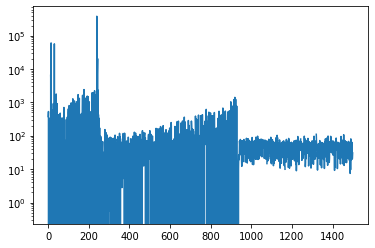

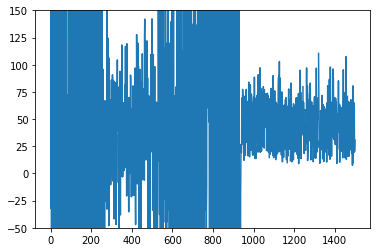


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:42,  1.65s/it]

0 223.2892910838127


  2%|▏         | 2/100 [00:03<02:41,  1.65s/it]

1 190.86424526572227


  3%|▎         | 3/100 [00:04<02:40,  1.66s/it]

2 189.83276018500328


  4%|▍         | 4/100 [00:06<02:37,  1.65s/it]

3 188.45459845662117


  5%|▌         | 5/100 [00:08<02:35,  1.64s/it]

4 187.85277324914932


  6%|▌         | 6/100 [00:09<02:33,  1.63s/it]

5 187.7192989885807


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 187.34361284971237


  8%|▊         | 8/100 [00:13<02:28,  1.62s/it]

7 187.30750381946564


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 186.8571950495243


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 187.09012207388878


 11%|█         | 11/100 [00:17<02:24,  1.63s/it]

10 186.63316264748573


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 186.71074962615967


 13%|█▎        | 13/100 [00:21<02:23,  1.65s/it]

12 186.7717032134533


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

13 186.7928744852543


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 186.49444988369942


 16%|█▌        | 16/100 [00:26<02:16,  1.62s/it]

15 186.56471702456474


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 186.51241973042488


 18%|█▊        | 18/100 [00:29<02:11,  1.61s/it]

17 186.40492498874664


 19%|█▉        | 19/100 [00:30<02:11,  1.62s/it]

18 186.3739876449108


 20%|██        | 20/100 [00:32<02:11,  1.65s/it]

19 186.13015151023865


 21%|██        | 21/100 [00:34<02:10,  1.65s/it]

20 186.4420903623104


 22%|██▏       | 22/100 [00:35<02:08,  1.65s/it]

21 186.01797914505005


 23%|██▎       | 23/100 [00:37<02:06,  1.64s/it]

22 186.1226080954075


 24%|██▍       | 24/100 [00:39<02:04,  1.64s/it]

23 186.00765866041183


 25%|██▌       | 25/100 [00:40<02:03,  1.64s/it]

24 185.90693926811218


 26%|██▌       | 26/100 [00:42<02:01,  1.65s/it]

25 186.01365131139755


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 185.87429150938988


 28%|██▊       | 28/100 [00:45<01:58,  1.64s/it]

27 185.91071313619614


 29%|██▉       | 29/100 [00:47<01:56,  1.64s/it]

28 185.89232182502747


 30%|███       | 30/100 [00:49<01:54,  1.64s/it]

29 186.1568884253502


 31%|███       | 31/100 [00:50<01:52,  1.64s/it]

30 185.88049280643463


 32%|███▏      | 32/100 [00:52<01:52,  1.65s/it]

31 185.7849758565426


 33%|███▎      | 33/100 [00:53<01:50,  1.65s/it]

32 185.96425804495811


 34%|███▍      | 34/100 [00:55<01:48,  1.64s/it]

33 185.98745784163475


 35%|███▌      | 35/100 [00:57<01:45,  1.62s/it]

34 185.72625583410263


 36%|███▌      | 36/100 [00:58<01:44,  1.63s/it]

35 185.77708917856216


 37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

36 185.8945066332817


 38%|███▊      | 38/100 [01:02<01:40,  1.62s/it]

37 185.63016599416733


 39%|███▉      | 39/100 [01:03<01:38,  1.62s/it]

38 185.92640191316605


 40%|████      | 40/100 [01:05<01:38,  1.65s/it]

39 185.7859444618225


 41%|████      | 41/100 [01:07<01:37,  1.65s/it]

40 185.65180572867393


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 185.64221921563148


 43%|████▎     | 43/100 [01:10<01:33,  1.63s/it]

42 185.5505010187626


 44%|████▍     | 44/100 [01:11<01:31,  1.64s/it]

43 185.6212317943573


 45%|████▌     | 45/100 [01:13<01:29,  1.63s/it]

44 185.64851582050323


 46%|████▌     | 46/100 [01:15<01:28,  1.63s/it]

45 185.57081761956215


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 185.48350685834885


 48%|████▊     | 48/100 [01:18<01:24,  1.62s/it]

47 185.5927678644657


 49%|████▉     | 49/100 [01:20<01:22,  1.62s/it]

48 185.6034722328186


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 185.54561886191368


 51%|█████     | 51/100 [01:23<01:20,  1.64s/it]

50 185.7311596274376


 52%|█████▏    | 52/100 [01:24<01:18,  1.64s/it]

51 185.6763395667076


 53%|█████▎    | 53/100 [01:26<01:16,  1.63s/it]

52 185.55066591501236


 54%|█████▍    | 54/100 [01:28<01:14,  1.62s/it]

53 185.34095266461372


 55%|█████▌    | 55/100 [01:29<01:12,  1.62s/it]

54 185.55099207162857


 56%|█████▌    | 56/100 [01:31<01:10,  1.61s/it]

55 185.47304672002792


 57%|█████▋    | 57/100 [01:32<01:09,  1.61s/it]

56 185.29896929860115


 58%|█████▊    | 58/100 [01:34<01:08,  1.63s/it]

57 185.5480798780918


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 185.42377680540085


 60%|██████    | 60/100 [01:37<01:05,  1.64s/it]

59 185.4587526023388


 61%|██████    | 61/100 [01:39<01:03,  1.63s/it]

60 185.31228232383728


 62%|██████▏   | 62/100 [01:41<01:02,  1.64s/it]

61 185.43431475758553


 63%|██████▎   | 63/100 [01:42<01:00,  1.64s/it]

62 185.3770859837532


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 185.36181235313416


 65%|██████▌   | 65/100 [01:46<00:58,  1.66s/it]

64 185.4603129029274


 66%|██████▌   | 66/100 [01:47<00:56,  1.66s/it]

65 185.07617008686066


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 185.39790657162666


 68%|██████▊   | 68/100 [01:51<00:52,  1.64s/it]

67 185.27060124278069


 69%|██████▉   | 69/100 [01:52<00:50,  1.63s/it]

68 185.31933906674385


 70%|███████   | 70/100 [01:54<00:49,  1.65s/it]

69 185.4543222784996


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 185.37445494532585


 72%|███████▏  | 72/100 [01:57<00:45,  1.63s/it]

71 185.4899162054062


 73%|███████▎  | 73/100 [01:59<00:43,  1.62s/it]

72 185.4009444117546


 74%|███████▍  | 74/100 [02:00<00:41,  1.61s/it]

73 185.11696791648865


 75%|███████▌  | 75/100 [02:02<00:40,  1.61s/it]

74 185.41752728819847


 76%|███████▌  | 76/100 [02:04<00:39,  1.63s/it]

75 185.36312049627304


 77%|███████▋  | 77/100 [02:05<00:36,  1.61s/it]

76 185.33598411083221


 78%|███████▊  | 78/100 [02:07<00:35,  1.61s/it]

77 185.26896691322327


 79%|███████▉  | 79/100 [02:08<00:33,  1.60s/it]

78 185.46326300501823


 80%|████████  | 80/100 [02:10<00:32,  1.60s/it]

79 185.32718542218208


 81%|████████  | 81/100 [02:12<00:30,  1.59s/it]

80 185.1139039993286


 82%|████████▏ | 82/100 [02:13<00:28,  1.60s/it]

81 185.49988582730293


 83%|████████▎ | 83/100 [02:15<00:27,  1.60s/it]

82 185.17612195014954


 84%|████████▍ | 84/100 [02:16<00:25,  1.62s/it]

83 185.19824868440628


 85%|████████▌ | 85/100 [02:18<00:24,  1.61s/it]

84 185.30785992741585


 86%|████████▌ | 86/100 [02:20<00:22,  1.60s/it]

85 185.16383001208305


 87%|████████▋ | 87/100 [02:21<00:20,  1.61s/it]

86 185.29975670576096


 88%|████████▊ | 88/100 [02:23<00:19,  1.64s/it]

87 185.16308107972145


 89%|████████▉ | 89/100 [02:25<00:18,  1.65s/it]

88 185.33415803313255


 90%|█████████ | 90/100 [02:26<00:16,  1.64s/it]

89 185.27692666649818


 91%|█████████ | 91/100 [02:28<00:14,  1.65s/it]

90 185.21141001582146


 92%|█████████▏| 92/100 [02:29<00:13,  1.63s/it]

91 185.26757860183716


 93%|█████████▎| 93/100 [02:31<00:11,  1.64s/it]

92 185.17595487833023


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 185.33630123734474


 95%|█████████▌| 95/100 [02:34<00:08,  1.65s/it]

94 185.17711699008942


 96%|█████████▌| 96/100 [02:36<00:06,  1.64s/it]

95 184.93442958593369


 97%|█████████▋| 97/100 [02:38<00:04,  1.63s/it]

96 185.20353704690933


 98%|█████████▊| 98/100 [02:39<00:03,  1.62s/it]

97 185.35120877623558


 99%|█████████▉| 99/100 [02:41<00:01,  1.62s/it]

98 185.07706689834595


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

99 185.36947363615036

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07309768348932266	

epoch 9000/10000, policy loss 0.0011201589368283749	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th2_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_2 = policy_loss_list

In [ ]:
with open('policy_loss_list_2.npy', 'wb') as f:
    np.save(f, policy_loss_list_2)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 3]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 3

batch size =  50000
Config: {'ALG': 'May1_test1_th3_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 3, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

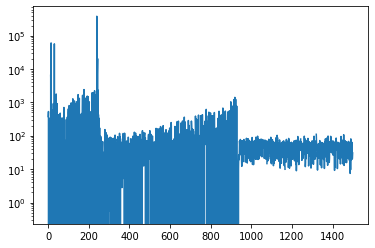

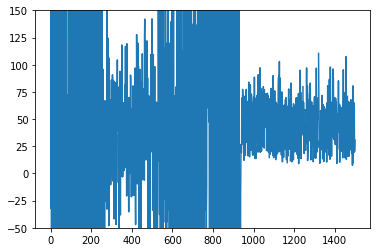


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:46,  1.68s/it]

0 331.1370737552643


  2%|▏         | 2/100 [00:03<02:43,  1.67s/it]

1 280.2598352730274


  3%|▎         | 3/100 [00:04<02:41,  1.67s/it]

2 278.9625595808029


  4%|▍         | 4/100 [00:06<02:38,  1.65s/it]

3 277.5366276204586


  5%|▌         | 5/100 [00:08<02:36,  1.65s/it]

4 276.2170387804508


  6%|▌         | 6/100 [00:09<02:33,  1.64s/it]

5 275.9663231372833


  7%|▋         | 7/100 [00:11<02:30,  1.62s/it]

6 276.14849931001663


  8%|▊         | 8/100 [00:13<02:29,  1.62s/it]

7 275.5466256439686


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 275.5074882209301


 10%|█         | 10/100 [00:16<02:25,  1.62s/it]

9 275.4225805103779


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 274.99415904283524


 12%|█▏        | 12/100 [00:19<02:21,  1.60s/it]

11 274.98768001794815


 13%|█▎        | 13/100 [00:21<02:19,  1.60s/it]

12 274.98843336105347


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

13 275.1361231505871


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 274.80184730887413


 16%|█▌        | 16/100 [00:25<02:16,  1.62s/it]

15 274.85611858963966


 17%|█▋        | 17/100 [00:27<02:15,  1.63s/it]

16 274.4100962281227


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 274.7122690975666


 19%|█▉        | 19/100 [00:30<02:11,  1.62s/it]

18 274.44699984788895


 20%|██        | 20/100 [00:32<02:12,  1.65s/it]

19 274.2395139336586


 21%|██        | 21/100 [00:34<02:11,  1.67s/it]

20 274.63301825523376


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 274.45681950449944


 23%|██▎       | 23/100 [00:37<02:06,  1.65s/it]

22 274.29103350639343


 24%|██▍       | 24/100 [00:39<02:04,  1.64s/it]

23 274.08579114079475


 25%|██▌       | 25/100 [00:40<02:03,  1.65s/it]

24 274.02194422483444


 26%|██▌       | 26/100 [00:42<02:00,  1.63s/it]

25 274.3318381309509


 27%|██▋       | 27/100 [00:44<01:58,  1.62s/it]

26 273.83103758096695


 28%|██▊       | 28/100 [00:45<01:57,  1.63s/it]

27 274.17993798851967


 29%|██▉       | 29/100 [00:47<01:55,  1.62s/it]

28 274.23418962955475


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 274.1642828285694


 31%|███       | 31/100 [00:50<01:52,  1.63s/it]

30 273.70837876200676


 32%|███▏      | 32/100 [00:52<01:51,  1.64s/it]

31 273.87390729784966


 33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

32 273.8703398704529


 34%|███▍      | 34/100 [00:55<01:48,  1.65s/it]

33 274.16256657242775


 35%|███▌      | 35/100 [00:57<01:46,  1.64s/it]

34 273.423868060112


 36%|███▌      | 36/100 [00:58<01:45,  1.65s/it]

35 274.00400826334953


 37%|███▋      | 37/100 [01:00<01:43,  1.65s/it]

36 273.85234636068344


 38%|███▊      | 38/100 [01:02<01:42,  1.66s/it]

37 273.5247763991356


 39%|███▉      | 39/100 [01:03<01:41,  1.66s/it]

38 273.91088250279427


 40%|████      | 40/100 [01:05<01:39,  1.66s/it]

39 273.7802450656891


 41%|████      | 41/100 [01:07<01:36,  1.64s/it]

40 273.4092101752758


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 273.8441425859928


 43%|████▎     | 43/100 [01:10<01:32,  1.63s/it]

42 273.5028932392597


 44%|████▍     | 44/100 [01:11<01:32,  1.64s/it]

43 273.2845428586006


 45%|████▌     | 45/100 [01:13<01:30,  1.65s/it]

44 273.3468194901943


 46%|████▌     | 46/100 [01:15<01:28,  1.63s/it]

45 273.4767259955406


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 273.4473971426487


 48%|████▊     | 48/100 [01:18<01:25,  1.65s/it]

47 273.57755744457245


 49%|████▉     | 49/100 [01:20<01:23,  1.63s/it]

48 273.49204018712044


 50%|█████     | 50/100 [01:21<01:21,  1.64s/it]

49 273.3232891857624


 51%|█████     | 51/100 [01:23<01:20,  1.65s/it]

50 273.61479690670967


 52%|█████▏    | 52/100 [01:25<01:18,  1.64s/it]

51 273.7128612399101


 53%|█████▎    | 53/100 [01:26<01:16,  1.64s/it]

52 273.6814542710781


 54%|█████▍    | 54/100 [01:28<01:15,  1.65s/it]

53 273.1243350505829


 55%|█████▌    | 55/100 [01:29<01:13,  1.63s/it]

54 273.3565848171711


 56%|█████▌    | 56/100 [01:31<01:11,  1.62s/it]

55 273.6353197991848


 57%|█████▋    | 57/100 [01:33<01:09,  1.62s/it]

56 273.112540602684


 58%|█████▊    | 58/100 [01:34<01:07,  1.62s/it]

57 273.2410719692707


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 273.5548580288887


 60%|██████    | 60/100 [01:38<01:04,  1.62s/it]

59 273.191652148962


 61%|██████    | 61/100 [01:39<01:04,  1.64s/it]

60 273.25413849949837


 62%|██████▏   | 62/100 [01:41<01:02,  1.63s/it]

61 273.356076836586


 63%|██████▎   | 63/100 [01:43<01:00,  1.65s/it]

62 273.4614462554455


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 273.3745560348034


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 272.99108216166496


 66%|██████▌   | 66/100 [01:48<00:56,  1.66s/it]

65 273.018123537302


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 273.21648198366165


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 272.97126868367195


 69%|██████▉   | 69/100 [01:52<00:50,  1.64s/it]

68 273.2804522514343


 70%|███████   | 70/100 [01:54<00:49,  1.63s/it]

69 273.20512250065804


 71%|███████   | 71/100 [01:56<00:46,  1.62s/it]

70 273.3050141632557


 72%|███████▏  | 72/100 [01:57<00:46,  1.65s/it]

71 273.2083608210087


 73%|███████▎  | 73/100 [01:59<00:44,  1.63s/it]

72 273.1368930339813


 74%|███████▍  | 74/100 [02:01<00:42,  1.63s/it]

73 273.24853533506393


 75%|███████▌  | 75/100 [02:02<00:41,  1.64s/it]

74 273.34189823269844


 76%|███████▌  | 76/100 [02:04<00:39,  1.66s/it]

75 273.04744005203247


 77%|███████▋  | 77/100 [02:06<00:37,  1.64s/it]

76 272.93242159485817


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 272.8865285217762


 79%|███████▉  | 79/100 [02:09<00:34,  1.66s/it]

78 273.3119262754917


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 273.1531668007374


 81%|████████  | 81/100 [02:12<00:31,  1.67s/it]

80 272.8070638179779


 82%|████████▏ | 82/100 [02:14<00:30,  1.67s/it]

81 273.27856838703156


 83%|████████▎ | 83/100 [02:16<00:28,  1.66s/it]

82 273.20801573991776


 84%|████████▍ | 84/100 [02:17<00:26,  1.68s/it]

83 272.92715069651604


 85%|████████▌ | 85/100 [02:19<00:25,  1.67s/it]

84 273.00831389427185


 86%|████████▌ | 86/100 [02:20<00:23,  1.64s/it]

85 272.95148089528084


 87%|████████▋ | 87/100 [02:22<00:21,  1.64s/it]

86 273.42742761969566


 88%|████████▊ | 88/100 [02:24<00:19,  1.63s/it]

87 272.7301535010338


 89%|████████▉ | 89/100 [02:25<00:17,  1.63s/it]

88 273.3336791098118


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 273.0287007987499


 91%|█████████ | 91/100 [02:29<00:14,  1.61s/it]

90 273.2448498606682


 92%|█████████▏| 92/100 [02:30<00:12,  1.61s/it]

91 273.0912160873413


 93%|█████████▎| 93/100 [02:32<00:11,  1.61s/it]

92 272.88679111003876


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 273.2870182096958


 95%|█████████▌| 95/100 [02:35<00:08,  1.62s/it]

94 272.88769924640656


 96%|█████████▌| 96/100 [02:37<00:06,  1.62s/it]

95 272.6806816458702


 97%|█████████▋| 97/100 [02:38<00:04,  1.64s/it]

96 272.9183651506901


 98%|█████████▊| 98/100 [02:40<00:03,  1.62s/it]

97 272.9765895307064


 99%|█████████▉| 99/100 [02:42<00:01,  1.63s/it]

98 272.68312284350395


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

99 273.04564675688744

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.5826263427734375	

epoch 9000/10000, policy loss 0.001883620978333056	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th3_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_3 = policy_loss_list

In [ ]:
with open('policy_loss_list_3.npy', 'wb') as f:
    np.save(f, policy_loss_list_3)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 4]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 4

batch size =  50000
Config: {'ALG': 'May1_test1_th4_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 4, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

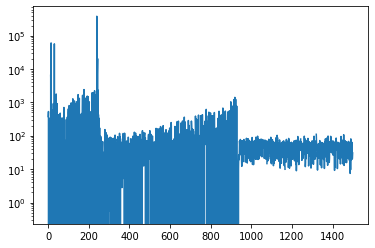

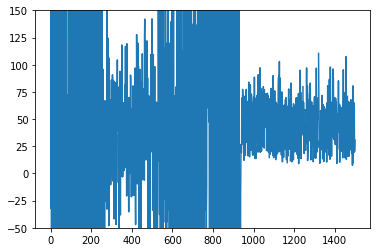


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:39,  1.61s/it]

0 458.14095240831375


  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

1 385.53909945487976


  3%|▎         | 3/100 [00:04<02:36,  1.61s/it]

2 382.1601721048355


  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]

3 380.2224694490433


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 379.5685480237007


  6%|▌         | 6/100 [00:09<02:32,  1.62s/it]

5 378.52447777986526


  7%|▋         | 7/100 [00:11<02:30,  1.61s/it]

6 378.4989966750145


  8%|▊         | 8/100 [00:12<02:28,  1.61s/it]

7 377.95162189006805


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 377.735186457634


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 377.8160279393196


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 377.1444729566574


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 376.85272789001465


 13%|█▎        | 13/100 [00:21<02:20,  1.61s/it]

12 377.10765236616135


 14%|█▍        | 14/100 [00:22<02:17,  1.60s/it]

13 377.159645318985


 15%|█▌        | 15/100 [00:24<02:17,  1.61s/it]

14 376.75308805704117


 16%|█▌        | 16/100 [00:25<02:15,  1.62s/it]

15 376.94828975200653


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 376.78533178567886


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 376.730981528759


 19%|█▉        | 19/100 [00:30<02:11,  1.63s/it]

18 376.724601149559


 20%|██        | 20/100 [00:32<02:09,  1.62s/it]

19 376.32525008916855


 21%|██        | 21/100 [00:34<02:09,  1.63s/it]

20 376.78580194711685


 22%|██▏       | 22/100 [00:35<02:06,  1.62s/it]

21 376.3378132581711


 23%|██▎       | 23/100 [00:37<02:04,  1.62s/it]

22 376.5279993414879


 24%|██▍       | 24/100 [00:38<02:02,  1.61s/it]

23 376.0284957885742


 25%|██▌       | 25/100 [00:40<02:02,  1.63s/it]

24 375.9956703186035


 26%|██▌       | 26/100 [00:42<02:00,  1.63s/it]

25 376.22467935085297


 27%|██▋       | 27/100 [00:43<01:58,  1.63s/it]

26 375.7737295627594


 28%|██▊       | 28/100 [00:45<01:58,  1.64s/it]

27 375.99238216876984


 29%|██▉       | 29/100 [00:47<01:55,  1.63s/it]

28 376.12437492609024


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 376.42395532131195


 31%|███       | 31/100 [00:50<01:51,  1.62s/it]

30 375.82136833667755


 32%|███▏      | 32/100 [00:51<01:50,  1.62s/it]

31 375.7602673172951


 33%|███▎      | 33/100 [00:53<01:50,  1.64s/it]

32 376.07972556352615


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 376.10817378759384


 35%|███▌      | 35/100 [00:56<01:46,  1.63s/it]

34 375.3499831557274


 36%|███▌      | 36/100 [00:58<01:45,  1.64s/it]

35 376.005636036396


 37%|███▋      | 37/100 [01:00<01:43,  1.64s/it]

36 375.83478885889053


 38%|███▊      | 38/100 [01:01<01:41,  1.63s/it]

37 374.99941688776016


 39%|███▉      | 39/100 [01:03<01:39,  1.62s/it]

38 376.43352872133255


 40%|████      | 40/100 [01:04<01:37,  1.62s/it]

39 375.50174218416214


 41%|████      | 41/100 [01:06<01:34,  1.61s/it]

40 375.508504986763


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 375.7503463625908


 43%|████▎     | 43/100 [01:09<01:32,  1.63s/it]

42 375.54787516593933


 44%|████▍     | 44/100 [01:11<01:30,  1.62s/it]

43 375.0511623620987


 45%|████▌     | 45/100 [01:12<01:28,  1.61s/it]

44 375.8259227871895


 46%|████▌     | 46/100 [01:14<01:28,  1.63s/it]

45 375.4002010822296


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 375.19975984096527


 48%|████▊     | 48/100 [01:17<01:25,  1.63s/it]

47 375.29962438344955


 49%|████▉     | 49/100 [01:19<01:23,  1.64s/it]

48 375.3646755218506


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 375.53023594617844


 51%|█████     | 51/100 [01:22<01:19,  1.62s/it]

50 375.35339576005936


 52%|█████▏    | 52/100 [01:24<01:18,  1.63s/it]

51 375.4846222996712


 53%|█████▎    | 53/100 [01:26<01:16,  1.62s/it]

52 375.5020549893379


 54%|█████▍    | 54/100 [01:27<01:14,  1.62s/it]

53 375.22646266222


 55%|█████▌    | 55/100 [01:29<01:13,  1.62s/it]

54 375.26334977149963


 56%|█████▌    | 56/100 [01:30<01:10,  1.61s/it]

55 375.20898205041885


 57%|█████▋    | 57/100 [01:32<01:09,  1.61s/it]

56 375.1432646512985


 58%|█████▊    | 58/100 [01:34<01:07,  1.61s/it]

57 375.20448929071426


 59%|█████▉    | 59/100 [01:35<01:05,  1.60s/it]

58 375.2159181237221


 60%|██████    | 60/100 [01:37<01:04,  1.60s/it]

59 375.25027334690094


 61%|██████    | 61/100 [01:38<01:02,  1.59s/it]

60 375.0934066772461


 62%|██████▏   | 62/100 [01:40<01:00,  1.59s/it]

61 374.86243534088135


 63%|██████▎   | 63/100 [01:42<00:58,  1.59s/it]

62 375.11958891153336


 64%|██████▍   | 64/100 [01:43<00:57,  1.59s/it]

63 375.37538427114487


 65%|██████▌   | 65/100 [01:45<00:56,  1.63s/it]

64 375.1102687716484


 66%|██████▌   | 66/100 [01:46<00:55,  1.62s/it]

65 374.3982310295105


 67%|██████▋   | 67/100 [01:48<00:54,  1.64s/it]

66 375.28113359212875


 68%|██████▊   | 68/100 [01:50<00:52,  1.63s/it]

67 374.77266842126846


 69%|██████▉   | 69/100 [01:51<00:50,  1.61s/it]

68 375.43507170677185


 70%|███████   | 70/100 [01:53<00:48,  1.63s/it]

69 375.23262894153595


 71%|███████   | 71/100 [01:55<00:46,  1.61s/it]

70 374.8462089896202


 72%|███████▏  | 72/100 [01:56<00:45,  1.61s/it]

71 374.9030736088753


 73%|███████▎  | 73/100 [01:58<00:43,  1.63s/it]

72 375.07585632801056


 74%|███████▍  | 74/100 [02:00<00:42,  1.64s/it]

73 374.89128905534744


 75%|███████▌  | 75/100 [02:01<00:40,  1.64s/it]

74 374.74499183893204


 76%|███████▌  | 76/100 [02:03<00:39,  1.63s/it]

75 374.860904276371


 77%|███████▋  | 77/100 [02:04<00:37,  1.64s/it]

76 374.7465372681618


 78%|███████▊  | 78/100 [02:06<00:35,  1.63s/it]

77 374.9660003185272


 79%|███████▉  | 79/100 [02:08<00:34,  1.64s/it]

78 375.1763818860054


 80%|████████  | 80/100 [02:09<00:32,  1.65s/it]

79 375.19243413209915


 81%|████████  | 81/100 [02:11<00:31,  1.66s/it]

80 374.12847208976746


 82%|████████▏ | 82/100 [02:13<00:29,  1.65s/it]

81 374.77064579725266


 83%|████████▎ | 83/100 [02:14<00:27,  1.63s/it]

82 374.7438830733299


 84%|████████▍ | 84/100 [02:16<00:26,  1.63s/it]

83 374.48867785930634


 85%|████████▌ | 85/100 [02:18<00:24,  1.63s/it]

84 374.7136719226837


 86%|████████▌ | 86/100 [02:19<00:23,  1.66s/it]

85 374.8500249385834


 87%|████████▋ | 87/100 [02:21<00:21,  1.64s/it]

86 374.80240046977997


 88%|████████▊ | 88/100 [02:22<00:19,  1.63s/it]

87 374.32861137390137


 89%|████████▉ | 89/100 [02:24<00:17,  1.63s/it]

88 374.71640318632126


 90%|█████████ | 90/100 [02:26<00:16,  1.64s/it]

89 374.44784939289093


 91%|█████████ | 91/100 [02:27<00:14,  1.64s/it]

90 374.7888387441635


 92%|█████████▏| 92/100 [02:29<00:12,  1.62s/it]

91 374.6575449705124


 93%|█████████▎| 93/100 [02:31<00:11,  1.63s/it]

92 374.4447611570358


 94%|█████████▍| 94/100 [02:32<00:09,  1.62s/it]

93 374.8049605488777


 95%|█████████▌| 95/100 [02:34<00:08,  1.61s/it]

94 374.2784759402275


 96%|█████████▌| 96/100 [02:35<00:06,  1.61s/it]

95 374.16536086797714


 97%|█████████▋| 97/100 [02:37<00:04,  1.60s/it]

96 374.5168690085411


 98%|█████████▊| 98/100 [02:39<00:03,  1.59s/it]

97 374.3861135840416


 99%|█████████▉| 99/100 [02:40<00:01,  1.59s/it]

98 374.38456904888153


100%|██████████| 100/100 [02:42<00:00,  1.61s/it]

99 374.5071594119072

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.06912165135145187	

epoch 9000/10000, policy loss 0.006667280104011297	
***** test student *****
epoch 0/100 return: 162.0
epoch 1/100 return: 173.0
epoch 2/100 return: 174.0
epoch 3/100 return: 164.0
epoch 4/100 return: 152.0
epoch 5/100 return: 162.0
epoch 6/100 return: 144.0
epoch 7/100 return: 157.0
epoch 8/100 return: 173.0
epoch 9/100 return: 145.0
epoch 10/100 return: 190.0
epoch 11/100 return: 155.0
epoch 12/100 return: 168.0
epoch 13/100 return: 174.0
epoch 14/100 return: 156.0
epoch 15/100 return: 160.0
epoch 16/100 return: 213.0
epoch 17/100 return: 146.0
epoch 18/100 return: 169.0
epoch 19/100 return: 175.0
epoch 20/100 return: 157.0
epoch 21/100 return: 149.0
epoch 22/100 return: 167.0
epoch 23/100 return: 240.0
epoch 24/100 return: 157.0
epoch 25/100 return: 150.0
epoch 26/100 return: 169.0
epoch 27/100 return: 159.0
epoch 28/100 return: 164.0
epoch 29/100 return: 159.0
epoch 30/100 return: 142.0
epoch 31/100 return: 197.0
epoch 32/100 return: 161.0
epoch 33/100 return: 172.0
epoch 34/100 re

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th4_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_4 = policy_loss_list

In [ ]:
with open('policy_loss_list_4.npy', 'wb') as f:
    np.save(f, policy_loss_list_4)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 5]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 5

batch size =  50000
Config: {'ALG': 'May1_test1_th5_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 5, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

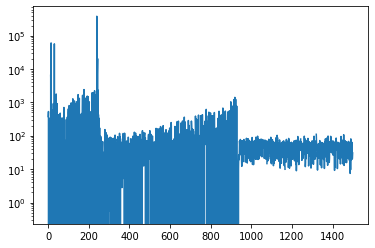

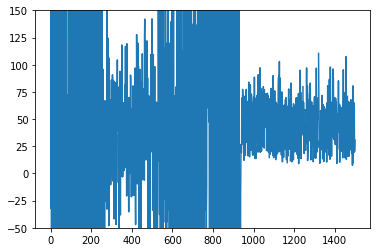


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:39,  1.61s/it]

0 31.430748090147972


  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

1 27.96618688106537


  3%|▎         | 3/100 [00:04<02:38,  1.63s/it]

2 27.539222944527864


  4%|▍         | 4/100 [00:06<02:36,  1.63s/it]

3 27.45961194112897


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 27.380707565695047


  6%|▌         | 6/100 [00:09<02:34,  1.65s/it]

5 27.243543837219477


  7%|▋         | 7/100 [00:11<02:34,  1.67s/it]

6 27.19235296919942


  8%|▊         | 8/100 [00:13<02:32,  1.66s/it]

7 27.220689356327057


  9%|▉         | 9/100 [00:14<02:30,  1.66s/it]

8 27.271565042436123


 10%|█         | 10/100 [00:16<02:29,  1.66s/it]

9 27.16327530518174


 11%|█         | 11/100 [00:18<02:25,  1.64s/it]

10 27.125561982393265


 12%|█▏        | 12/100 [00:19<02:25,  1.66s/it]

11 27.192689336836338


 13%|█▎        | 13/100 [00:21<02:25,  1.68s/it]

12 27.162919532507658


 14%|█▍        | 14/100 [00:23<02:21,  1.64s/it]

13 27.08353278040886


 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]

14 27.09537871554494


 16%|█▌        | 16/100 [00:26<02:19,  1.65s/it]

15 27.111227978020906


 17%|█▋        | 17/100 [00:28<02:15,  1.64s/it]

16 27.105205971747637


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 27.100356720387936


 19%|█▉        | 19/100 [00:31<02:12,  1.64s/it]

18 27.049072679132223


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 27.036110039800406


 21%|██        | 21/100 [00:34<02:09,  1.63s/it]

20 27.026373986154795


 22%|██▏       | 22/100 [00:36<02:06,  1.62s/it]

21 27.399547427892685


 23%|██▎       | 23/100 [00:37<02:05,  1.63s/it]

22 26.96771239489317


 24%|██▍       | 24/100 [00:39<02:03,  1.63s/it]

23 26.98185132816434


 25%|██▌       | 25/100 [00:41<02:03,  1.65s/it]

24 27.015547025948763


 26%|██▌       | 26/100 [00:42<02:02,  1.66s/it]

25 27.032600659877062


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 27.011740375310183


 28%|██▊       | 28/100 [00:45<01:57,  1.63s/it]

27 26.98699000477791


 29%|██▉       | 29/100 [00:47<01:56,  1.64s/it]

28 26.98887737840414


 30%|███       | 30/100 [00:49<01:53,  1.62s/it]

29 26.986677836626768


 31%|███       | 31/100 [00:50<01:53,  1.64s/it]

30 26.994559302926064


 32%|███▏      | 32/100 [00:52<01:51,  1.63s/it]

31 26.988013707101345


 33%|███▎      | 33/100 [00:54<01:49,  1.63s/it]

32 26.974317986518145


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 27.019695691764355


 35%|███▌      | 35/100 [00:57<01:45,  1.62s/it]

34 26.991749484091997


 36%|███▌      | 36/100 [00:58<01:43,  1.61s/it]

35 26.949822064489126


 37%|███▋      | 37/100 [01:00<01:40,  1.60s/it]

36 27.01940482482314


 38%|███▊      | 38/100 [01:02<01:39,  1.61s/it]

37 26.98875590786338


 39%|███▉      | 39/100 [01:03<01:37,  1.61s/it]

38 26.96767470613122


 40%|████      | 40/100 [01:05<01:36,  1.61s/it]

39 26.979380387812853


 41%|████      | 41/100 [01:07<01:35,  1.62s/it]

40 26.95222719758749


 42%|████▏     | 42/100 [01:08<01:35,  1.65s/it]

41 26.939196288585663


 43%|████▎     | 43/100 [01:10<01:35,  1.67s/it]

42 26.94247369468212


 44%|████▍     | 44/100 [01:12<01:34,  1.68s/it]

43 27.455670565366745


 45%|████▌     | 45/100 [01:13<01:31,  1.66s/it]

44 26.92575139924884


 46%|████▌     | 46/100 [01:15<01:29,  1.65s/it]

45 26.953996051102877


 47%|████▋     | 47/100 [01:17<01:26,  1.64s/it]

46 26.93560580909252


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 26.915674339979887


 49%|████▉     | 49/100 [01:20<01:22,  1.63s/it]

48 26.950653821229935


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 26.972627002745867


 51%|█████     | 51/100 [01:23<01:20,  1.64s/it]

50 26.971100453287363


 52%|█████▏    | 52/100 [01:25<01:18,  1.63s/it]

51 26.933019619435072


 53%|█████▎    | 53/100 [01:26<01:16,  1.63s/it]

52 26.97305813804269


 54%|█████▍    | 54/100 [01:28<01:15,  1.63s/it]

53 26.929980773478746


 55%|█████▌    | 55/100 [01:30<01:13,  1.62s/it]

54 26.936838429421186


 56%|█████▌    | 56/100 [01:31<01:10,  1.61s/it]

55 26.936962489038706


 57%|█████▋    | 57/100 [01:33<01:09,  1.61s/it]

56 27.002780862152576


 58%|█████▊    | 58/100 [01:34<01:07,  1.62s/it]

57 26.919540729373693


 59%|█████▉    | 59/100 [01:36<01:06,  1.62s/it]

58 26.946787927299738


 60%|██████    | 60/100 [01:38<01:04,  1.61s/it]

59 27.209279868751764


 61%|██████    | 61/100 [01:39<01:02,  1.61s/it]

60 26.881166711449623


 62%|██████▏   | 62/100 [01:41<01:01,  1.62s/it]

61 26.891642529517412


 63%|██████▎   | 63/100 [01:42<01:00,  1.63s/it]

62 26.91507249325514


 64%|██████▍   | 64/100 [01:44<00:58,  1.64s/it]

63 26.94960942491889


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 26.928269557654858


 66%|██████▌   | 66/100 [01:47<00:56,  1.65s/it]

65 26.970831405371428


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 26.89310609549284


 68%|██████▊   | 68/100 [01:51<00:53,  1.66s/it]

67 26.9091114141047


 69%|██████▉   | 69/100 [01:52<00:51,  1.66s/it]

68 26.931326020509005


 70%|███████   | 70/100 [01:54<00:49,  1.64s/it]

69 26.933834496885538


 71%|███████   | 71/100 [01:56<00:47,  1.63s/it]

70 26.92482865974307


 72%|███████▏  | 72/100 [01:57<00:45,  1.63s/it]

71 26.938866320997477


 73%|███████▎  | 73/100 [01:59<00:44,  1.65s/it]

72 26.915178529918194


 74%|███████▍  | 74/100 [02:01<00:42,  1.65s/it]

73 26.92467650398612


 75%|███████▌  | 75/100 [02:02<00:40,  1.63s/it]

74 26.932261258363724


 76%|███████▌  | 76/100 [02:04<00:39,  1.64s/it]

75 26.951839823275805


 77%|███████▋  | 77/100 [02:06<00:37,  1.65s/it]

76 26.90616011992097


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 26.89730279147625


 79%|███████▉  | 79/100 [02:09<00:34,  1.64s/it]

78 26.980937507003546


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 26.900748923420906


 81%|████████  | 81/100 [02:12<00:31,  1.64s/it]

80 26.911502316594124


 82%|████████▏ | 82/100 [02:14<00:29,  1.65s/it]

81 27.82052929699421


 83%|████████▎ | 83/100 [02:15<00:28,  1.65s/it]

82 26.924732640385628


 84%|████████▍ | 84/100 [02:17<00:26,  1.63s/it]

83 26.898652832955122


 85%|████████▌ | 85/100 [02:19<00:24,  1.63s/it]

84 26.900322750210762


 86%|████████▌ | 86/100 [02:20<00:22,  1.63s/it]

85 26.906231209635735


 87%|████████▋ | 87/100 [02:22<00:20,  1.61s/it]

86 26.89153379201889


 88%|████████▊ | 88/100 [02:23<00:19,  1.60s/it]

87 26.897764336317778


 89%|████████▉ | 89/100 [02:25<00:17,  1.60s/it]

88 26.923490338027477


 90%|█████████ | 90/100 [02:27<00:16,  1.61s/it]

89 26.88942576944828


 91%|█████████ | 91/100 [02:28<00:14,  1.62s/it]

90 26.95996391400695


 92%|█████████▏| 92/100 [02:30<00:13,  1.64s/it]

91 26.9106907248497


 93%|█████████▎| 93/100 [02:32<00:11,  1.64s/it]

92 26.91302650421858


 94%|█████████▍| 94/100 [02:33<00:09,  1.62s/it]

93 26.926015503704548


 95%|█████████▌| 95/100 [02:35<00:08,  1.62s/it]

94 26.947490096092224


 96%|█████████▌| 96/100 [02:36<00:06,  1.62s/it]

95 26.9219216927886


 97%|█████████▋| 97/100 [02:38<00:04,  1.63s/it]

96 26.915202870965004


 98%|█████████▊| 98/100 [02:40<00:03,  1.64s/it]

97 26.881365317851305


 99%|█████████▉| 99/100 [02:41<00:01,  1.63s/it]

98 26.94829571992159


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

99 26.920965041965246

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07600545138120651	

epoch 9000/10000, policy loss 0.058518052101135254	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 453.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th5_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_5 = policy_loss_list

In [ ]:
with open('policy_loss_list_5.npy', 'wb') as f:
    np.save(f, policy_loss_list_5)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 6]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 6

batch size =  50000
Config: {'ALG': 'May1_test1_th6_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 6, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

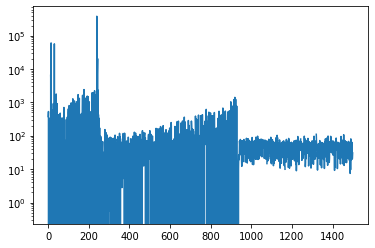

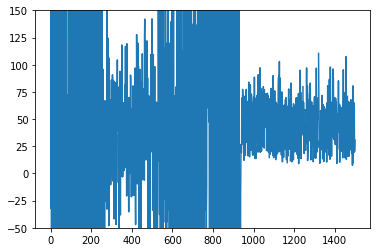


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:25,  1.47s/it]

0 nan


  2%|▏         | 2/100 [00:02<02:25,  1.49s/it]

1 nan


  3%|▎         | 3/100 [00:04<02:25,  1.50s/it]

2 nan


  4%|▍         | 4/100 [00:06<02:25,  1.51s/it]

3 nan


  5%|▌         | 5/100 [00:07<02:24,  1.52s/it]

4 nan


  6%|▌         | 6/100 [00:09<02:22,  1.52s/it]

5 nan


  7%|▋         | 7/100 [00:10<02:22,  1.54s/it]

6 nan


  8%|▊         | 8/100 [00:12<02:19,  1.52s/it]

7 nan


  9%|▉         | 9/100 [00:13<02:18,  1.52s/it]

8 nan


 10%|█         | 10/100 [00:15<02:15,  1.51s/it]

9 nan


 11%|█         | 11/100 [00:16<02:13,  1.50s/it]

10 nan


 12%|█▏        | 12/100 [00:18<02:11,  1.50s/it]

11 nan


 13%|█▎        | 13/100 [00:19<02:11,  1.51s/it]

12 nan


 14%|█▍        | 14/100 [00:21<02:09,  1.50s/it]

13 nan


 15%|█▌        | 15/100 [00:22<02:10,  1.53s/it]

14 nan


 16%|█▌        | 16/100 [00:24<02:09,  1.54s/it]

15 nan


 17%|█▋        | 17/100 [00:25<02:10,  1.57s/it]

16 nan


 18%|█▊        | 18/100 [00:27<02:09,  1.58s/it]

17 nan


 19%|█▉        | 19/100 [00:29<02:05,  1.55s/it]

18 nan


 20%|██        | 20/100 [00:30<02:05,  1.56s/it]

19 nan


 21%|██        | 21/100 [00:32<02:03,  1.56s/it]

20 nan


 22%|██▏       | 22/100 [00:33<02:00,  1.54s/it]

21 nan


 23%|██▎       | 23/100 [00:35<01:58,  1.53s/it]

22 nan


 24%|██▍       | 24/100 [00:36<01:57,  1.55s/it]

23 nan


 25%|██▌       | 25/100 [00:38<01:57,  1.57s/it]

24 nan


 26%|██▌       | 26/100 [00:39<01:55,  1.56s/it]

25 nan


 27%|██▋       | 27/100 [00:41<01:52,  1.54s/it]

26 nan


 28%|██▊       | 28/100 [00:42<01:49,  1.52s/it]

27 nan


 29%|██▉       | 29/100 [00:44<01:47,  1.52s/it]

28 nan


 30%|███       | 30/100 [00:45<01:46,  1.52s/it]

29 nan


 31%|███       | 31/100 [00:47<01:45,  1.53s/it]

30 nan


 32%|███▏      | 32/100 [00:48<01:43,  1.51s/it]

31 nan


 33%|███▎      | 33/100 [00:50<01:42,  1.52s/it]

32 nan


 34%|███▍      | 34/100 [00:52<01:40,  1.52s/it]

33 nan


 35%|███▌      | 35/100 [00:53<01:39,  1.52s/it]

34 nan


 36%|███▌      | 36/100 [00:55<01:37,  1.53s/it]

35 nan


 37%|███▋      | 37/100 [00:56<01:36,  1.53s/it]

36 nan


 38%|███▊      | 38/100 [00:58<01:34,  1.53s/it]

37 nan


 39%|███▉      | 39/100 [00:59<01:32,  1.52s/it]

38 nan


 40%|████      | 40/100 [01:01<01:30,  1.51s/it]

39 nan


 41%|████      | 41/100 [01:02<01:28,  1.50s/it]

40 nan


 42%|████▏     | 42/100 [01:04<01:26,  1.49s/it]

41 nan


 43%|████▎     | 43/100 [01:05<01:25,  1.50s/it]

42 nan


 44%|████▍     | 44/100 [01:07<01:23,  1.49s/it]

43 nan


 45%|████▌     | 45/100 [01:08<01:22,  1.50s/it]

44 nan


 46%|████▌     | 46/100 [01:10<01:20,  1.50s/it]

45 nan


 47%|████▋     | 47/100 [01:11<01:20,  1.52s/it]

46 nan


 48%|████▊     | 48/100 [01:13<01:18,  1.51s/it]

47 nan


 49%|████▉     | 49/100 [01:14<01:18,  1.53s/it]

48 nan


 50%|█████     | 50/100 [01:16<01:17,  1.54s/it]

49 nan


 51%|█████     | 51/100 [01:17<01:15,  1.54s/it]

50 nan


 52%|█████▏    | 52/100 [01:19<01:14,  1.54s/it]

51 nan


 53%|█████▎    | 53/100 [01:20<01:12,  1.53s/it]

52 nan


 54%|█████▍    | 54/100 [01:22<01:10,  1.54s/it]

53 nan


 55%|█████▌    | 55/100 [01:23<01:08,  1.53s/it]

54 nan


 56%|█████▌    | 56/100 [01:25<01:07,  1.54s/it]

55 nan


 57%|█████▋    | 57/100 [01:27<01:07,  1.56s/it]

56 nan


 58%|█████▊    | 58/100 [01:28<01:04,  1.55s/it]

57 nan


 59%|█████▉    | 59/100 [01:30<01:02,  1.53s/it]

58 nan


 60%|██████    | 60/100 [01:31<01:00,  1.52s/it]

59 nan


 61%|██████    | 61/100 [01:33<00:58,  1.51s/it]

60 nan


 62%|██████▏   | 62/100 [01:34<00:57,  1.51s/it]

61 nan


 63%|██████▎   | 63/100 [01:36<00:56,  1.52s/it]

62 nan


 64%|██████▍   | 64/100 [01:37<00:54,  1.52s/it]

63 nan


 65%|██████▌   | 65/100 [01:39<00:53,  1.54s/it]

64 nan


 66%|██████▌   | 66/100 [01:40<00:52,  1.53s/it]

65 nan


 67%|██████▋   | 67/100 [01:42<00:50,  1.53s/it]

66 nan


 68%|██████▊   | 68/100 [01:43<00:48,  1.53s/it]

67 nan


 69%|██████▉   | 69/100 [01:45<00:47,  1.52s/it]

68 nan


 70%|███████   | 70/100 [01:46<00:45,  1.53s/it]

69 nan


 71%|███████   | 71/100 [01:48<00:43,  1.52s/it]

70 nan


 72%|███████▏  | 72/100 [01:49<00:42,  1.52s/it]

71 nan


 73%|███████▎  | 73/100 [01:51<00:41,  1.52s/it]

72 nan


 74%|███████▍  | 74/100 [01:53<00:39,  1.53s/it]

73 nan


 75%|███████▌  | 75/100 [01:54<00:38,  1.53s/it]

74 nan


 76%|███████▌  | 76/100 [01:56<00:36,  1.53s/it]

75 nan


 77%|███████▋  | 77/100 [01:57<00:35,  1.55s/it]

76 nan


 78%|███████▊  | 78/100 [01:59<00:34,  1.56s/it]

77 nan


 79%|███████▉  | 79/100 [02:00<00:32,  1.55s/it]

78 nan


 80%|████████  | 80/100 [02:02<00:30,  1.53s/it]

79 nan


 81%|████████  | 81/100 [02:03<00:29,  1.54s/it]

80 nan


 82%|████████▏ | 82/100 [02:05<00:27,  1.55s/it]

81 nan


 83%|████████▎ | 83/100 [02:06<00:25,  1.53s/it]

82 nan


 84%|████████▍ | 84/100 [02:08<00:24,  1.55s/it]

83 nan


 85%|████████▌ | 85/100 [02:10<00:23,  1.58s/it]

84 nan


 86%|████████▌ | 86/100 [02:11<00:21,  1.55s/it]

85 nan


 87%|████████▋ | 87/100 [02:13<00:20,  1.54s/it]

86 nan


 88%|████████▊ | 88/100 [02:14<00:18,  1.53s/it]

87 nan


 89%|████████▉ | 89/100 [02:16<00:16,  1.53s/it]

88 nan


 90%|█████████ | 90/100 [02:17<00:15,  1.56s/it]

89 nan


 91%|█████████ | 91/100 [02:19<00:13,  1.55s/it]

90 nan


 92%|█████████▏| 92/100 [02:20<00:12,  1.52s/it]

91 nan


 93%|█████████▎| 93/100 [02:22<00:10,  1.51s/it]

92 nan


 94%|█████████▍| 94/100 [02:23<00:09,  1.51s/it]

93 nan


 95%|█████████▌| 95/100 [02:25<00:07,  1.50s/it]

94 nan


 96%|█████████▌| 96/100 [02:26<00:06,  1.51s/it]

95 nan


 97%|█████████▋| 97/100 [02:28<00:04,  1.50s/it]

96 nan


 98%|█████████▊| 98/100 [02:29<00:03,  1.51s/it]

97 nan


 99%|█████████▉| 99/100 [02:31<00:01,  1.52s/it]

98 nan


100%|██████████| 100/100 [02:32<00:00,  1.51s/it]

99 nan

***** train student policy network *****
train in NFiVAE



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/linear.py:103: UserWarning: An output with one or more elements was resized since it had shape [989, 64], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  return F.linear(input, self.weight, self.bias)


RuntimeError: ignored

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th6_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_6 = policy_loss_list

In [ ]:
with open('policy_loss_list_6.npy', 'wb') as f:
    np.save(f, policy_loss_list_6)

In [ ]:
plt.plot(policy_loss_list_neg1, labels='Threshold >=0')
plt.plot(policy_loss_list_0, labels='Threshold >=1')
plt.plot(policy_loss_list_1, labels='Threshold >=2')
plt.plot(policy_loss_list_2, labels='Threshold >=3')
plt.plot(policy_loss_list_3, labels='Threshold >=4')
plt.plot(policy_loss_list_4, labels='Threshold >=5')
plt.plot(policy_loss_list_5, labels='Threshold >=6')
plt.plot(policy_loss_list_6, labels='Threshold >=7')



In [ ]:
with open('policy_loss_list_neg1.npy', 'rb') as f:
    policy_loss_list_neg1 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_0.npy', 'rb') as f:
    policy_loss_list_0 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_1.npy', 'rb') as f:
    policy_loss_list_1 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_2.npy', 'rb') as f:
    policy_loss_list_2 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_3.npy', 'rb') as f:
    policy_loss_list_3 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_4.npy', 'rb') as f:
    policy_loss_list_4 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_5.npy', 'rb') as f:
    policy_loss_list_5 = np.load(f, allow_pickle = True)

In [ ]:
policy_loss_list_neg1 = np.stack([policy_loss_list_neg1[i].cpu().numpy() for i in range(len(policy_loss_list_neg1))])

AttributeError: ignored

In [ ]:
policy_loss_list_0 = np.stack([policy_loss_list_0[i].cpu().numpy() for i in range(len(policy_loss_list_0))])

AttributeError: ignored

In [ ]:
policy_loss_list_1 = np.stack([policy_loss_list_1[i].cpu().numpy() for i in range(len(policy_loss_list_1))])

AttributeError: ignored

In [ ]:
policy_loss_list_2 = np.stack([policy_loss_list_2[i].cpu().numpy() for i in range(len(policy_loss_list_2))])

AttributeError: ignored

In [ ]:
policy_loss_list_3 = np.stack([policy_loss_list_3[i].cpu().numpy() for i in range(len(policy_loss_list_3))])

In [ ]:
policy_loss_list_4 = np.stack([policy_loss_list_4[i].cpu().numpy() for i in range(len(policy_loss_list_4))])

In [ ]:
policy_loss_list_5 = np.stack([policy_loss_list_5[i].cpu().numpy() for i in range(len(policy_loss_list_5))])

In [ ]:
result = np.zeros((6, 10000))

In [ ]:
result[0] = policy_loss_list_neg1
result[1] = policy_loss_list_1
result[2] = policy_loss_list_2
result[3] = policy_loss_list_3
result[4] = policy_loss_list_4
result[5] = policy_loss_list_5

with open('phase3loss.npy', 'wb') as f:
    np.save(f, result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


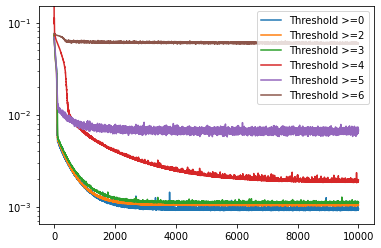

In [ ]:
import matplotlib.pyplot as plt
plt.plot(policy_loss_list_neg1, label='Threshold >=0')
#plt.plot(policy_loss_list_0, label='Threshold >=1')
plt.plot(policy_loss_list_1, label='Threshold >=2')
plt.plot(policy_loss_list_2, label='Threshold >=3')
plt.plot(policy_loss_list_3, label='Threshold >=4')
plt.plot(policy_loss_list_4, label='Threshold >=5')
plt.plot(policy_loss_list_5, label='Threshold >=6')
plt.yscale("log")
plt.ylim(0,0.15)

plt.legend()
